## Analysis code for 'Are colour experiences the same across the visual field?'
Written by Ariel Zeleznikow-Johnston, 2020  
ariel.zeleznikow-johnston@monash.edu  
Github link to experiment: https://github.com/ArielZJ/SimilarityColorProject-MultiplePatches  
Github link to this analysis code: https://github.com/ArielZJ/Precision-Phenomenology-Data-Analysis  

### Initialisations

In [1]:
filename = "data/pilotcompiled.csv"

In [2]:
# various parameters
stimuli_number = 9
response_type_list = c('during')
trial_types = c('during')
response_names = c('During')
catch_trial_number = 10 # what it's set at at the moment, arbitrary
condition_number = 3
max.DSR = 7
min.DSR = 0

In [3]:
trace_cutoff = 2 # mean dissimilarity for physically identical colours must be below this
antitrace_cutoff = 3.5 # mean dissimilarity accepted for maximally physically different colours must be above this
rt_cutoff = 600 # mean reaction times must be above this

In [4]:
exclude_noncompliant = FALSE

In [5]:
plotsubjects = FALSE
plotsubjects_mixed = FALSE
plot_within_between = FALSE
plotexpsummary = FALSE
across = FALSE
population = FALSE

In [6]:
# colors for the labels
# changed for this mixed version
colors <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9',"#00A9FF",'#0000FF','#AA00FF',"#FF00AA")
abcolors <- sort(colors)

eccens.colors <- c(
    'Foveal #FF0000',
    'Foveal #FFAA00',
    'Foveal #AAFF00',
    'Foveal #00FF00',
    'Foveal #00FFA9',
    "Foveal #00A9FF",
    'Foveal #0000FF',
    'Foveal #AA00FF',
    "Foveal #FF00AA",
    'Peripheral #FF0000',
    'Peripheral #FFAA00',
    'Peripheral #AAFF00',
    'Peripheral #00FF00',
    'Peripheral #00FFA9',
    "Peripheral #00A9FF",
    'Peripheral #0000FF',
    'Peripheral #AA00FF',
    "Peripheral #FF00AA")

inverted.colors <-  c('#FF0000','#FF00AA','#AA00FF','#0000FF','#00A9FF','#00FFA9','#00FF00','#AAFF00','#FFAA00')

### Initialisations

In [7]:
# live dangerously, get rid of pesky warnings
oldw <- getOption("warn")
options(warn = -1)

In [8]:
shhh <- suppressPackageStartupMessages # stops annoying warnings when loading libraries
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(MASS)
library(Matrix)
library(reshape2)
library(ape) # stats
library(vegan) # stats
library(RColorBrewer)
library(cocor)
library(DescTools)
library(reshape2)
library(grid)
library(ggplotify)
library(fclust)
library(plot.matrix)
library(gtools)
library(stringi)
library(Bolstad)


Attaching package: 'tidyr'

The following object is masked _by_ '.GlobalEnv':

    population


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Loading required package:

In [9]:
# rainbowcloud theme for plotting, stolen from: 
# https://micahallen.org/2018/03/15/introducing-raincloud-plots/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com
raincloud_theme = theme(
text = element_text(size = 10),
axis.title.x = element_text(size = 16),
axis.title.y = element_text(size = 16),
axis.text = element_text(size = 14),
axis.text.x = element_text(angle = 45, vjust = 0.5),
legend.title=element_text(size=16),
legend.text=element_text(size=16),
legend.position = "right",
plot.title = element_text(lineheight=.8, face="bold", size = 16),
panel.border = element_blank(),
panel.grid.minor = element_blank(),
panel.grid.major = element_blank(),
axis.line.x = element_line(colour = 'black', size=0.5, linetype='solid'),
axis.line.y = element_line(colour = 'black', size=0.5, linetype='solid'))

In [10]:
# stealing ability to make flat violin plots
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")

### Functions we're going to use to do the analysis later

#### Miscellaneous

In [11]:
# check our N 
get_n <- function(datadf){
    n <- length(unique(datadf$subject))
    print(paste("There are",n,"unique subjects"))
    return(n)
}

In [12]:
# get plot eccentricity labels
ploteccen <- function(datadf){
    if(datadf$Circle_1[1] == -1){
            label1 = 'Foveal'
        } else {
            label1 = 'Peripheral'
        }
        if(datadf$Circle_2[1] == -1){
            label2 = 'Foveal'
        } else {
            label2 = 'Peripheral'
        }
    return(c(label1,label2))
}

e2l <- function(eccentricity){
    if(eccentricity == -1){
        return('Foveal')
    } else {
        return('Peripheral')
    }
}

l2e <- function(eccentricity){
    if(eccentricity == 'Foveal'){
        return(-1)
    } else {
        return(1)
    }
}

#### Dissimilarity Matrices

In [13]:
# obtain dissimilarity matrices with particular eccentricity values from dataframes
# doesn't care whether this comes from individual subjects or whole populations
dissimdata <- function(datadf, colors, eccentricity1, eccentricity2){
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datatemp = subset(datadf, Circle_1 == eccentricity1)
    datatemp = subset(datatemp, Circle_2 == eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [14]:
# plot a dissimilarity matrix
dissimplot <- function(datadf,colors,dependent='color'){
    
   # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    
    if(dependent == 'position'){ # use position to generate matrix (as a negative control)
        plot <- ggplot(datadf, aes(x = bin1, y = bin2)) +
        theme(        axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                      scale_x_discrete(limits=c(1,2,3,4,5,6,7,8,9)) + scale_y_discrete(limits=c(1,2,3,4,5,6,7,8,9))
    } else { # use the colors to generate the matrix
        plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    }
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = similarity)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [15]:
# plot a shuffled dissimilarity matrix, for visualisation purposes only
dissimplot_shuffled <- function(datadf){
    # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    datadf$similarity = sample(datadf$similarity, replace=FALSE) # shuffle colour 2
    
     plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    plot <- plot + geom_raster(aes(fill = similarity)) +
                labs(title = paste("SHUFFLED\n",label1, " - ", label2)) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [16]:
# making a matrix symmetric. Stolen from dclone: https://rdrr.io/github/datacloning/dclone/src/R/make.symmetric.R
make.symmetric <-function(x)
{
    if (dim(x)[1] != dim(x)[2])
        stop("'x' is not a square matrix")
    rval <- t(x)
    m <- (x[lower.tri(x)] + rval[lower.tri(rval)]) / 2
    rval[lower.tri(rval)] <- m
    rval <- t(rval)
    rval[lower.tri(rval)] <- m
    rval
}

In [17]:
# obtain dissimilarity dataframe that corresponds to all of a subject's judgements
# symmeterises XY & YX by taking the mean if asked
dissimdata.subject <- function(datadf, colors=colors, duplicate=TRUE, symmeterise=TRUE, diagnose=FALSE){
    
    if(diagnose){print(paste("Duplicate:",duplicate,"Symmetrise:", symmeterise))}
    
    # first, get a full label for each trial
    datadf <- subset(datadf, trial_type != 'catch')
    
    if(symmeterise){
        
        if(diagnose){print(paste("Initiate symmeterisation"))}
        
        datadf <- datadf %>%
        rowwise() %>%
        mutate(color.eccen1 = paste(c(e2l(Circle_1),Color_1),collapse=' - ')) %>%
        mutate(color.eccen2 = paste(c(e2l(Circle_2),Color_2),collapse=' - ')) %>%
        mutate(color.eccen = paste(sort(c(e2l(Circle_1),Color_1,e2l(Circle_2),Color_2)),collapse=':')) %>%
        ungroup()

        # take the average across symmetric trials (e.g. C-blue, P-green & C-green, P-blue)

        datadf <- aggregate(datadf, by = list(datadf$color.eccen),mean)
        datadf$color.eccen <- datadf$Group.1 

        # get some labels back for plotting below that we destroyed in the process
        datadf$color.eccen.sacrifice <- datadf$color.eccen

        datadf <- datadf %>% separate(color.eccen.sacrifice, c("color.1","color.2","eccen.1","eccen.2"),':')



        datadf$color1.eccen1 <- paste(datadf$eccen.1,datadf$color.1)
        datadf$color2.eccen2 <- paste(datadf$eccen.2,datadf$color.2)
    }
    
    # duplicate some rows if we want to plot a full matrix - for aesthetic reasons
    # I'm sorry for how ugly this is but I had so many bugs making it for unfathomable reasons (to me) that I'm not
    # going to change it now. Feel free to clean it up for me
    if(duplicate){
        if(diagnose){print(paste("Initiate CP/PC duplication"))}
        tempdf <- subset(datadf,(color.1 != color.2))
        
        tempdf$color1.eccen1.temp <- tempdf$color1.eccen1
        tempdf$color2.eccen2.temp <- tempdf$color2.eccen2

        tempdf$color1.eccen1 <- tempdf$color2.eccen2.temp
        tempdf$color2.eccen2 <- tempdf$color1.eccen1.temp
             
        
        tempdf <- subset(tempdf, select = -c(color1.eccen1.temp, color2.eccen2.temp))
        
        tempdf2 <- subset(tempdf, substr(tempdf$color.eccen, 16, nchar(tempdf$color.eccen)) == ':Foveal:Peripheral')
        
        tempdf <- subset(tempdf, substr(tempdf$color.eccen, 16, nchar(tempdf$color.eccen)) != ':Foveal:Peripheral')
        
        tempdf2$temp1 <- tempdf2$color1.eccen1
        tempdf2$color1.eccen1 <- paste('Foveal',substr(tempdf2$temp1,nchar(tempdf2$temp1)-7+1,nchar(tempdf2$temp1)))
        tempdf2$temp2 <- tempdf2$color2.eccen2
        tempdf2$color2.eccen2 <- paste('Peripheral',substr(tempdf2$temp2,nchar(tempdf2$temp2)-7+1,nchar(tempdf2$temp2)))
        debug <- subset(tempdf2, select=c(color1.eccen1,temp1,color2.eccen2,temp2))
        tempdf2 <- subset(tempdf2, select = -c(temp1,temp2))
        
        
        datadf <- rbind(datadf,tempdf,tempdf2)
        
    
        datadf$color <- substr(datadf$color.eccen, 1, 15) # get a colour pair label
        datadf$color1 <- substr(datadf$color, 1, 7)
        datadf$color2 <- substr(datadf$color, 9, 15)
    } else {
        datadf$Circle_1[datadf$Circle_1 == -1] <- 'Foveal'
        datadf$Circle_2[datadf$Circle_2 == -1] <- 'Foveal'
        datadf$Circle_1[datadf$Circle_1 == 1] <- 'Peripheral'
        datadf$Circle_2[datadf$Circle_2 == 1] <- 'Peripheral'
        datadf$color1.eccen1 <- paste(datadf$Circle_1,datadf$Color_1,sep=' ')
        datadf$color2.eccen2 <- paste(datadf$Circle_2,datadf$Color_2,sep=' ')

    }
    
    # refactor the levels so they can be plotted properly later if need be
       datadf$color1.eccen1 <- with(datadf, factor(color1.eccen1, levels = eccens.colors))
       datadf$color2.eccen2 <- with(datadf, factor(color2.eccen2, levels = eccens.colors))
    if(diagnose){print(paste("Subject trial number:", nrow(datadf)))}
     
    
    #print(datadf$color1.eccen1)
    return(datadf)
}

In [18]:
# convert a df to a group of subject matrices
dissimgroup2matlist <- function(df){
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    mat.list <- list()
    k = 1
    for(ID in subjectlist){
        subjectdf <- subset(df, subject == ID)
        subject.mat <- color.eccen.mat(dissimdata.subject(subjectdf), output='matrix')
        mat.list[[k]] <- subject.mat
        k = k + 1
    }
    return(mat.list)
} 

In [19]:
# convert a groups of matrices to a group average matrix
group.mat.average <- function(mat.list){
    # average the matrices
    mat.average <- Reduce('+',mat.list)/length(mat.list)
    return(mat.average)
}
   

In [20]:
# testing
test <- FALSE
test <- TRUE
if(test){
    testdf <- subset(datadf, subject == 790529144)
    data <- dissimdata.subject(testdf,symmeterise=TRUE, duplicate=TRUE)
    data2 <- dissimdata.subject(testdf,symmeterise=TRUE, duplicate=TRUE, diagnose=TRUE)
    data$color1.eccen1
    dissimplot.full(data)
    dissimplot.full(data2)
    data2 <- color.eccen.mat(data2,duplicate=TRUE)
    color.eccen.mat(testdf, output='matrix')
    datamat2 <- color.eccen.mat(data2, output='matrix',duplicate=FALSE)
    datamat2
    dissimplot.full(data2)
    CPmat <- data[1:9,10:18]
    PCmat <- t(CPmat)
    CPmat
    PCmat
}


ERROR: Error in subset(datadf, subject == 790529144): object 'datadf' not found


In [21]:
# rotate a vector
rotate.vec <- function(vec, rotation){
    indexshift = round((rotation/360)*length(vec),0)
    if (indexshift == 0){
        return(vec)
    } else {
        return(c(tail(vec, -indexshift), head(vec, indexshift)))
    }
}

In [22]:
# swap the labels
matswap <- function(mat,mode='random',rotation=90){
    
    labels <- rownames(mat)
    if(mode=='random'){
        labels.swapped <- sample(labels)
    } else if (mode=='inversion'){
        labels.swapped <- c('#FF0000','#FF00AA','#AA00FF','#0000FF','#00A9FF','#00FFA9','#00FF00','#AAFF00','#FFAA00')
    } else if (mode=='rotation'){
        labels.swapped <- rotate.vec(labels,rotation)
    }
    
    rownames(mat) <- labels.swapped
    colnames(mat) <- labels.swapped
    
    # sort the matrix
    mat <- mat[, sort(colnames(mat))][sort(rownames(mat)),]
    
    return(mat)
    
}

In [23]:
# label the rows with the two colours independent of arbitrary ordering
dissimplot.full <- function(datadf, mode='standard',rotation=90,dependent='dissimilarity'){
        
    if(dependent=='RT'){
        #datadf$similarity <- log10(datadf$similarity)
    }
    
    plot <- ggplot(datadf, aes(x = color1.eccen1, y = color2.eccen2)) 
    
    if(mode=='standard'){
        color.list <- c(colors,colors)
    } else if (mode=='inversion'){
        color.list <- c(colors, inverted.colors)
    } else if (mode == 'rotation'){
        color.list <- c(colors, rotate.vec(colors,rotation))
    }
    plot <- plot + theme(axis.text.x = element_text(colour=color.list,angle=90),
                        axis.text.y = element_text(colour=color.list),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    
    
    # dissimilarity plot
    if(dependent=='dissimilarity'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"),
                                    limits=c(0,7),
                                    breaks=c(0,1,2,3,4,5,6,7)) +
                guides(fill=guide_legend(title="Dissimilarity"))
    }
    # reaction time plot
    if(dependent=='RT'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"), trans = "log",
                                    #limits=c(1000,1600),
                                    #limits=c(2.9,3.3),
                                    #breaks=c(2.9,3,3.146,3.255,3.3),
                                     limits = c(800,2000),
                                    breaks=c(800,1000,1400,1800),
                                    labels=c(800,1000,1400,1800)
                                    ) +
                guides(fill=guide_legend(title="RT (log)"))
    }
    # variance plot
    if(dependent=='variance'){
        
    }
    return(plot)
    
}

In [24]:
# convert a dataframe to a matrix. Automatically symmeterises the data. Only works on submatrices
df2mat.full <- function(datadf,eccentricity1=l2e('Foveal'),eccentricity2=l2e('Foveal')){
 
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datadf <- subset(datadf, Circle_1 == eccentricity1 & Circle_2 == eccentricity2)

    # aggregate over the remaining columns of interest
    datadf <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
    datadf$Color_1 <- datadf$Group.1
    datadf$Color_2 <- datadf$Group.2

    datadf = subset(datadf, select = c("Color_1","Color_2","similarity"))  # get rid of unnecessary columns
    datadf <- spread(datadf, Color_1, similarity)
    
    # convert the dataframe to a matrix
    datamatrix <- data.matrix(datadf)
    datamatrix <- datamatrix[,-1] # get rid of the labels in the first column, it messes up the code
    datamatrix <- make.symmetric(datamatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    rownames(datamatrix) <- colnames(datamatrix)
    
    # sort the matrix
    datamatrix <- datamatrix[, sort(colnames(datamatrix))][sort(rownames(datamatrix)),]
    
    return(datamatrix)
    
}

In [25]:
# calculate within-subject variance in responses
# do this on symmeterised or unsymmeterised data?
dissimvar.within <- function(subjectdf){
    subject.data <- color.eccen.mat(subjectdf,
                                    duplicate=FALSE,
                                    symmeterise=FALSE,
                                    output='matrix')
    if(comparison='cells'){ # compare the variability between trials of the same type
        
    } else if (comparison='CC.PP'){
        
    } # compare variability across CC/CP trials
    else if (comparison='CC.CP'){
        
    } # compare variability across CP/PP trials
    else if (comparison='CP.PP'){
        
    }
    
    # return a variance matrix
    return(var.mat)
}

ERROR: Error in parse(text = x, srcfile = src): <text>:8:18: unexpected '='
7:                                     output='matrix')
8:     if(comparison=
                    ^


In [26]:
# take a list of matrices, return a matrix with the variance of cell entries
mat.variance <- function(mat.list){
    n.cells <- length(mat.list[[1]]) # how many cells per matrix
    
    var.mat <- matrix(
                       apply(sapply(1:n.cells, function(x) unlist(mat.list)[
                           seq(x, length(unlist(mat.list)),n.cells)]),
                            2, var),
                            ncol = ncol(mat.list[[1]]))
    return(var.mat)
}

In [27]:
# calculate between-subject variance in responses
dissimvar.between <- function(datadf){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    mat.list <- list()
    k=1
    # get a list of individual subject matrices
    for(ID in subjectlist){
        subjectdf <- subset(datadf, subject == ID)
        subjectdata <- dissimdata.subject(subjectdf)
        subject.mat <- color.eccen.mat(subjectdata,
                                      output='matrix')
        mat.list[[k]] <- subject.mat
        k = k + 1
    }
    # calculate variance for each cell entry
    var.mat <- (mat.variance(mat.list))
    
    rownames(var.mat) <- eccens.colors
    colnames(var.mat) <- eccens.colors
    return(var.mat)
}

In [28]:
testvar <- dissimvar.between(testdf)


ERROR: Error in unique(datadf$subject): object 'testdf' not found


In [29]:
# variance plot
variance.plot <- function(mat,
                         col1='blue',col2='yellow',na.col='green',
                                  legend.title='Variance',
                                  xlabel='',ylabel='',
                                  low.lim=0,up.lim=10){
    if(ncol(mat)<10){
        color.list <- colors
    } else {
        color.list <- c(colors,colors)
    }
    longData <- melt(mat)
    
    
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    scale_fill_gradientn(legend.title,colours = c(col1,col2),
                         limits = c(low.lim,up.lim), 
                         breaks=c(low.lim,up.lim),
                        na.value=na.col) + 
    theme(axis.text.x = element_text(colour=color.list,angle=90),
                        axis.text.y = element_text(colour=color.list),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))

    return(plot)
}
    

In [30]:
variance.plot(testvar)

ERROR: Error in ncol(mat): object 'testvar' not found


#### Testing different method using matrix plots

In [31]:
# convert a dataframe to a matrix v2, with some added functionality and without automatic
# symmeterisation
color.eccen.mat <- function(datadf,output='DF',mode='identity',rotation=90,plot=FALSE,dependent='dissimilarity',
                           duplicate=TRUE){
    library('plot.matrix')
    if(dependent=='RT'){
        datadf$similarity <- datadf$response_time
    }
    data <- subset(datadf, select = c(color1.eccen1, color2.eccen2, similarity))
    data <- spread(data, color1.eccen1, similarity)
    row.names <- data$color2.eccen2
    data.mat <- data.matrix(data)
    rownames(data.mat) <- row.names
    data.mat <- data.mat[,-1] # get rid of the redundant first column
    
    # duplicate Foveal x Peripheral matrix
    # 1. Make this only if requested
    # 2. Shouldn't this be transposed?
    if(duplicate){
        PF <- data.mat[10:18, 1:9]
        data.mat[1:9,10:18] <- t(PF)
    }
    
    
    # perform a label swap
    peripheral.labels <- c(10:18)
    if(mode == 'random'){
        swap.vec <- sample(peripheral.labels) # pick a random ordering of the peripheral labels
    } else if (mode == 'rotate'){
        swap.vec <- rotate.vec(peripheral.labels,rotation=rotation)
    } else if (mode == 'invert'){
        swap.vec <- match(inverted.colors,colors) + 9
    }
    if(mode != 'identity'){ # do the swap
        data.mat[10:18,] <- data.mat[swap.vec, ] # reorder the rows
        data.mat[,10:18] <- data.mat[, swap.vec] # reorder the columns
    }
        
    
    # plot the data
    if(plot){
        plot(data.mat, col=gray.colors(8, start=0, end=1, gamma=0.75, rev=TRUE),
         xlab = 'Fovea                                      Periphery',
        ylab = 'Fovea                                      Periphery')
    }
    
    
    # choose output type
    if(output == 'DF'){
        data <- as.data.frame(as.table(data.mat))
        colnames(data) <- c("color1.eccen1","color2.eccen2","similarity")
        return(data)
    } else if (output == 'matrix'){
        return(data.mat)
    }
}

#### Examining stimulus location

In [32]:
# label the hemifield that a stimulus was in
label.val <- function(angle){
    val <- abs(as.numeric(angle))
    print(val) # testing
    if((val) <= 30){
        return('RIGHT')
    } else {
        return('LEFT')
    }
}

label.hemifield <- function(datadf){
    
    datadf$angle_1 <- as.vector(datadf$angle_1)
    datadf$angle_2 <- as.vector(datadf$angle_2)
    datadf$stim_1_hemifield <- label.val(datadf$angle_1)
    datadf$stim_2_hemifield <- label.val(datadf$angle_2)
    return(datadf)
}

In [33]:
#testdf <- label.hemifield(testdf)

In [34]:
#testdf$stim_1_hemifield

#### Multidimensional Scaling Plots

In [35]:
# turn a dataset into a matrix
# DO NOT USE, MDS METHOD BROKEN
df2mat <- function(datadf,eccentricity1,eccentricity2,dependent='color'){
    
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datadf = subset(datadf, Circle_1 == eccentricity1 & Circle_2 == eccentricity2)
    
    if(dependent == 'position'){ # using stimulus location as a negative control
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$bin1, datadf$bin2),FUN=mean)
        nmdsdata$bin1 <- nmdsdata$Group.1
        nmdsdata$bin2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("bin1","bin2","similarity"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, bin1, similarity)
    } else { # color as per normal
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
        nmdsdata$Color_1 <- nmdsdata$Group.1
        nmdsdata$Color_2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("Color_1","Color_2","similarity"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, Color_1, similarity)
    }
    
    # convert the dataframe to a matrix
    nmdsmatrix <- data.matrix(nmdsmatrix)
    nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
    
    # having 0 dissimilarity between identical objects messes up the algorithm
    # changing the 0 values to an arbitrarily small value, but this is not a good long-term solution
    # need to find a better way of doing this
    nmdsmatrix[nmdsmatrix == 0] <- 0.01
    
    
    nmdsmatrix <- make.symmetric(nmdsmatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    return(nmdsmatrix)
}

In [36]:
# convert a standard matrix to a distance matrix
mat2dist <- function(mat){
    
    return(distmat <- as.dist(mat))
}

Non-metric multidimensional scaling (NMDS)

In [37]:
# find the nmds fit for a dataset
nmdsfit <- function(distmatrix){
      
    fit <- isoMDS(distmatrix,k=2, maxit=100)
    return(fit)
}

In [38]:
# plot the nmds fit
nmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = points.1, y = points.2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Non-metric MDS',sep=' - '))
    return(plot)
}

Classical multidimensional scaling

In [39]:
# find the cmds fit for a dataset
cmdsfit <- function(distmatrix){
    
    fit <- cmdscale(distmatrix,k=2)
    return(fit)
}

In [40]:
# plot the cmds fit
cmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = V1, y = V2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Classical MDS',sep=' - '))
    return(plot)
}

#### Some control measure plots

Reaction time vs. similarity judgements

In [41]:
# similarity judgement histogram
simhistplot <- function(datadf){
    
   plot <- ggplot(datadf, aes(x = similarity)) + geom_bar(aes(y = ..prop..)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
}

simhistplot_summary <- function(datadf,QDM='FULL'){
    
    if(QDM == 'FP'){
        datadf <- subset(datadf, ((Circle_1 == l2e('Foveal') & Circle_2 == l2e('Peripheral')) |
                                 (Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Foveal'))
                                 ))
    }
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x = similarity)) + 
    geom_line(stat='count',aes(y = ..prop..,group = subject),color='#CC9933') +
    geom_line(stat='count',aes(y = ..prop..),size=1.5) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = paste(QDM,'Dissimilarity')) +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
    
}

In [42]:
# reaction time for each similarity
rsplot <- function(datadf){
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time)) + 
    stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Reaction Time (ms)') +
    theme(legend.position = "none") +
    
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered
    
    return(plot)
}

rsplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time,group = subject, color = subject)) + 
    stat_summary(fun.y = mean, geom = "line", size=0.8) + 
    stat_summary(fun.y = mean, geom = "line", size=2.5, aes(group=1)) + # add a population summary
    #stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Mean Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered 
    
    return(plot)
    
}

In [43]:
# reaction time raincloud plot
rsplot_raincloud <- function(datadf,xtype='linear'){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation  
    datadf$similarity <- as.character(datadf$similarity) # necessary for visualisation
    
    ylabtext = 'Reaction Time (ms)'
    
    plot <- ggplot(datadf, aes(y = response_time, x = similarity, fill = similarity)) +
            geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8) +
            geom_point(aes(y = response_time, color = similarity),
                   position = position_jitter(width = .15), size = .5, alpha = 0.8) +
            geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, alpha = 0.5) +
            expand_limits(x = 5.25) +
            guides(fill = FALSE) +
            guides(color = FALSE) +
            scale_color_brewer(palette = "Spectral") +
            scale_fill_brewer(palette = "Spectral") +
            xlab('Dissimilarity') + ylab("Reaction Time (ms)")
            # coord_flip() +
            theme_bw() +
            raincloud_theme
    
    if(xtype == 'log'){
        plot <- plot + scale_y_continuous(trans='log10') + ylim(0,15000)
    } else{
        plot <- plot + ylim(0,5000)
    }
    
    return(plot)
}

In [44]:
# correlation between reaction times and similarity judgements
# grouping at individual trial, individual participant, experiment or entire population level
rt_similarity_cor <- function(datadf,level='participant'){
        
    if(level=="participant"){
        datadf <- datadf %>% 
                group_by(subject) %>% 
                mutate(rt_similarity_correlation = cor(similarity,response_time))
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)

                
    }
    return(datadf)
    
}

rt_similarity_plot <- function(datadf,xlabel='BLANK'){
    
    datadf <- rt_similarity_cor(datadf)
    
    datadf[xlabel] = xlabel
    
    plot <- ggplot(datadf,aes(x=xlabel,y=rt_similarity_correlation)) + 
                geom_boxplot() + 
                geom_dotplot(binaxis='y',stackdir='center',dotsize=0.75) +
                theme(text = element_text(size=15)) + xlab("")
                ggtitle(title)
    
    plot <- plot + ylab("Correlation (Spearman)") + ylim(-1,1)
    plot <- plot + geom_hline(yintercept=0, linetype="dashed", color = "blue")
    return(plot)
}

In [45]:
# mean reaction time vs. antitrace-trace difference
rt_difference <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        datadf$difference[datadf$subject == ID] = unlist(antitrace_avg(tempdf),use.names=FALSE)[1] - 
                   unlist(trace_avg(tempdf),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

rt_difference_plot <- function(datadf,xtype='linear'){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(rt_difference(datadf), aes(x=response_time, y=difference)) +
            geom_point() + xlab("Mean Reaction Time") + ylab("Antitrace - Trace")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')
    } else{
        plot <- plot + xlim(0,5000)
    }
    plot <- plot + geom_smooth(method=lm) # linear line of best fit
    return(plot)
}

In [46]:
# mean reaction time vs. catch trial score
rt_catch <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        datadf$catch_score[datadf$subject == ID] = unlist(catch_score(tempdf),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

rt_catch_plot <- function(datadf,xtype='linear',label=FALSE){
    
    datadf <- rt_catch(datadf)
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x=response_time, y=catch_score)) +
            geom_point() + xlab("Mean Reaction Time") + ylab("Catch Score")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')+ xlim(0,5000)
    } else{
        plot <- plot + xlim(0,5000)
    }
    plot <- plot + geom_smooth(method=lm) + ylim(0,1) # linear line of best fit
    #plot <- plot + geom_point(aes(color = subject))
    if(label){
        plot <- plot + geom_text(aes(label = subject),check_overlap=TRUE)
    }
    return(plot)
}

In [47]:
#rt_catch_plot(datadf, xtype='log')

In [48]:
# mean antitrace-trace difference vs. catch trial score
catch_difference <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf1 <- subset(datadf, subject == ID & trial_type!= 'catch') # remove catch trials for difference calculation
        tempdf2 <- subset(datadf, subject == ID) # keep catch trials for score calculation
        datadf$difference[datadf$subject == ID] = 
                   unlist(antitrace_avg(tempdf1),use.names=FALSE)[1] - 
                   unlist(trace_avg(tempdf1),use.names=FALSE)[1]
        datadf$catch_score[datadf$subject == ID] = unlist(catch_score(tempdf2),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

catch_difference_plot <- function(datadf,xtype='linear',label=FALSE){
    
    datadf <- catch_difference(datadf)
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x=difference, y=catch_score)) +
            geom_point() + xlab("Antitrace - Trace") + ylab("Catch Score")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')
    } else{
        plot <- plot
    }
    plot <- plot + geom_smooth(method=lm) + ylim(0,1) # linear line of best fit
    #plot <- plot + geom_point(aes(color = subject))
    if(label){
        plot <- plot + geom_text(aes(label = subject),check_overlap=TRUE)
    }
    return(plot)
}

In [49]:
# trace values vs. trial #
trace_by_trial_plot <- function(datadf,graph='point',mode='relative'){
    
     datadf$subject <- as.character(datadf$subject) # necessary for visualisation  
    
    datadf <- subset(datadf, Color_1 == Color_2)
    
    if(mode=='relative'){
        datadf <- datadf %>% group_by(subject) %>% mutate(trialnum = row_number())
    } else{
        datadf$trialnum <- datadf$trial_number
    }
        
    if(graph=='point'){
        plot <- ggplot(datadf, aes(x=trialnum, y = similarity, group = subject, color = subject)) + geom_point()
    } else if (graph == 'boxplot'){
        plot <- ggplot(datadf, aes(x=trialnum,y = similarity, group = trialnum)) + geom_boxplot() #????
    } else if (graph == 'lineplot'){
        plot <- ggplot(datadf, aes(x=trialnum, y = similarity,group=subject, color = subject)) + geom_line()
    }
    
    plot <- plot + ylab('Dissimilarity') +  theme(legend.position='none')
    
    return(plot)
    
}

In [50]:
# subject info
sumplot <- function(datadf){
    
    # change ms to s, add the delay for each trial
    datadf$response_time <- ((datadf$response_time + 0.125*nrow(datadf)) / 1000)
    
    plot <- ggplot(datadf, aes(x=subject, y = response_time)) + 
    stat_summary(fun.y = sum, geom = "bar") + ylim(0,1000) +
    ylab('Response Time Total') + theme(axis.title.x=element_blank(), axis.text.x = element_text(size=20))
    
    return(plot)
}

In [51]:
# plot to show if swaps increase or decrease correlations
colour_connect <- function(datadf,swap='random',comparison='FFvPP',fisher=FALSE){
    
    datadf <- subset(datadf, magnification != 1) # only use scaled data
    datadf <- subset(datadf, select=c(comparison,"ID","mode"))
    datadf <- subset(datadf, (mode == 'identity' | (mode == swap)))
    
    # had a weird bug so hardcoded for now, sorry
    if(swap == 'random'){
        datadf <- datadf %>%
                    spread(mode,comparison) %>%
                    mutate(is_increasing = random > identity) %>%
                    gather('mode','comparison',2:3)
        fill.colors <- c("red","green")
    } else if (swap == 'invert'){
        datadf <- datadf %>%
                    spread(mode,comparison) %>%
                    mutate(is_increasing = invert > identity) %>%
                    gather('mode','comparison',2:3)
        fill.colors <- c("red","blue")
    } else if (swap == 'rotate'){
        datadf <- datadf %>%
                    spread(mode,comparison) %>%
                    mutate(is_increasing = rotate > identity) %>%
                    gather('mode','comparison',2:3)
        fill.colors <- c("red","purple")
    }
    
                     
    
    datadf$correlations <- datadf$comparison
    # return to non-fisher-transformed correlation if applicable
    if(!fisher){
        datadf$correlations <- FisherZInv(datadf$correlations)
    }
    
    # plot it
    plot <- ggplot(datadf, aes(y=correlations, x=mode,
                               #color=mode, 
                               fill=mode,
                               #group=stimulus_radius
                              )) +
        geom_boxplot(aes(alpha=0.5)) + 
        geom_point() +
        geom_line(aes(x=mode,y=correlations,group=ID,color=is_increasing)) +
        scale_colour_manual(values = c("black","red"),guide='none') +
        scale_fill_manual(values = fill.colors) +
        xlab('Swap') + labs(color = 'Swap') + theme(axis.text.x = element_text(size = 15),
                                         axis.text.y = element_text(size = 15),
                                         axis.title.y = element_text(size = 20),
                                         axis.title.x = element_text(size=20)) +
        scale_alpha(guide='none')
        
    
    if(fisher){
        plot <- plot + ylab('Fisher-Transformed Correlation') + ylim(-0.6,2.6)
    } else {
        plot <- plot + ylab('Correlation') + ylim(-0.2,1)
    }
      #   
                    
    
    return(plot)
}

#colour_connect(within_distribution_df,swap='random')
#colour_connect(within_distribution_df,swap='invert')
#colour_connect(within_distribution_df,swap='rotate')

In [52]:
# plot a correlation distribution
r_distribution_plot <- function(datadf,fisher=TRUE,comparison='FFvPP',title=TRUE,swaps=TRUE,scaling=TRUE,connected=FALSE){
    
    if(connected){
       datadf <- colour_connect(datadf)
    }
    
    if(!scaling){
        datadf <- subset(datadf, magnification != 1) # only use the scaled data
    }
    
    if(comparison == 'FFvPP'){
        datadf$correlations <- datadf$FFvPP
    } else if (comparison == 'FFvFP'){
        datadf$correlations <- datadf$FFvFP
    } else if (comparison == 'FPvPP'){
        datadf$correlations <- datadf$FPvPP
    } else if (comparison == 'all'){
        if(!swaps){
            datadf <- subset(datadf, mode == 'identity') # get rid of the swaps
        }
        # Change names for plotting purposes
        colnames(datadf)[which(names(datadf) == "FFvPP")] <- "CC - PP"
        colnames(datadf)[which(names(datadf) == "FFvFP")] <- "CC - CP"
        colnames(datadf)[which(names(datadf) == "FPvPP")] <- "CP - PP"

        
        datadf <- datadf %>% gather(comparison, correlations, 3:5) # gather up the comparisons
    }
    
    # return to non-fisher-transformed correlation if applicable
    if(!fisher){
        datadf$correlations <- FisherZInv(datadf$correlations)
    }
    
    #testing
    #print(head(datadf,10))    
    
    # swap plotting
    if(comparison != 'all'){
        
        datadf$magnification <- as.character(datadf$magnification) # needed for axes to work properly
        datadf$stimulus_radius <- as.character(datadf$stimulus_radius)
        
        if(scaling){
            if(swaps){
                plot <- ggplot(datadf, aes(y=correlations, x=stimulus_radius,color=mode))
            } else {
                plot <- ggplot(datadf, aes(y=correlations, x=stimulus_radius))
            }
            plot <- plot + 
        xlab('Stimulus Size (DVA)') + labs(color = 'Swap') + theme(axis.text.x = element_text(size = 20),
                                         axis.text.y = element_text(size = 20),
                                         axis.title.y = element_text(size = 25),
                                         axis.title.x = element_text(size=25))
        } else if(!scaling) {
            plot <- ggplot(datadf, aes(y=correlations, x=mode,
                                   color=mode, 
                                   #fill=mode,
                                   #group=stimulus_radius
                                  )
                                  ) +
        xlab('Swap') + labs(color = 'Swap') + theme(axis.text.x = element_text(size = 15),
                                         axis.text.y = element_text(size = 15),
                                         axis.title.y = element_text(size = 20),
                                         axis.title.x = element_text(size=20))
        }
        if(connected){
            plot <- plot + geom_line(aes(x=mode,y=correlations,group=ID))
        }
        
    }
    # comparison plotting
    if(comparison == 'all'){
        plot <- ggplot(datadf, aes(y=correlations, x=comparison,
                                  #color=mode
                                  )) +
                        xlab("") + theme(axis.text.x = element_text(size = 15),
                                         axis.text.y = element_text(size = 15),
                                         axis.title.y = element_text(size = 18))
                        
    }
    
    
    # generic stuff
    if(fisher){
        plot <- plot + ylab('Fisher-Transformed Correlation') + ylim(-0.6,2.6)
    } else {
        plot <- plot + ylab('Correlation') + ylim(-0.2,1)
    }
    plot <- plot + geom_point(position=position_dodge(width=0.75)) + 
        geom_boxplot(aes(alpha=0.01)) + 
        scale_alpha(guide='none') 
    
    if(title){
        plot <- plot + ggtitle(paste("Comparison:",comparison,"---","Magnification:",datadf$magnification[1])) +
            theme(plot.title = element_text(hjust = 0.5))
    }
    
    return(plot)
    
}
#r_distribution_plot(testdf,fisher=FALSE,comparison='all',title=FALSE)
#r_distribution_plot(cleandf)


In [53]:
#head(within_distribution_df)

#### Check their screen size & viewing distance

In [54]:
# screen size in mm
screen_size <- function(datadf){
    
    datadf <- subset(datadf, trialcode == 'centermouse') # make sure calibrations have finished first
    
    width <- as.numeric(substr(as.character(datadf$screen_size_x)[1],1,6))
    height <- as.numeric(substr(as.character(datadf$screen_size_y)[1],1,6))
    
    # use pythagoras to just get the hypotenuse. Subjects have a fixed 16/9 aspect ratio so these are all comparable
    return(sqrt(width*width + height*height))
}

In [55]:
# viewing distance in mm
view_distance <- function(datadf){
    return(as.numeric(substr(as.character(datadf$viewer_distance)[1],1,6)))
}

### Statistics

Useful functions

In [56]:
# compare the foveal and peripheral matrices to each other
fvp_test <- function(datadf,dependent='color'){
    
    if(dependent=='position'){
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else{
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    }
    #Fovea vs Periphery
    test <- mantel(fmatrix, pmatrix, method="spearman",permutations = 9999)
    return(test)
}

In [57]:
# compare the each of the foveal and peripheral matrices to a random uniform distribution using a ... test
# not actually sure this is conceptually possible or even makes sense
rand_test <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    # compare
    ftest <- 
    ptest <- 
    return(list("ftest" = ftest, "ptest" = ptest)) # use index of result to get the foveal or peripheral comparison
}



In [58]:
# calculate trace average, small values presumably indicate subjects not just saying everything is completely dissimilar
# will also need a complementary method to deal with them saying everything is the same? Might be an inappropriate
# a-priori imposition though, I probably can't tell people how similar different colours should be...

trace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    
    return(list( (sum(diag(fmatrix))/nrow(fmatrix)), (sum(diag(pmatrix))/nrow(pmatrix))))
}

In [59]:
# calculate the average of the main or off-main diagonal for a QDM for a group of subjects
group_trace <- function(datadf,QDM='FP',mode='trace'){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    trace.vec <- vector()
    
    for (subjectid in subjectlist){
        tempdf <- subset(datadf, subject == subjectid)
        if(QDM=='FF'){
            matrix <- df2mat.full(tempdf, l2e('Foveal'),l2e('Foveal'))
        } else if (QDM == 'FP'){
            matrix <- df2mat.full(tempdf, l2e('Foveal'),l2e('Peripheral'))
        } else if (QDM == 'PP'){
            matrix <- df2mat.full(tempdf, l2e('Peripherial'),l2e('Peripheral'))
        }
        
        #obtain relevant value
        if(mode == 'trace'){
            trace <- sum(diag(matrix))/nrow(matrix)
        } else if (mode=='antitrace'){
            trace <- antitrace(matrix)
        }
        
        trace.vec <- c(trace.vec, trace)
    }
    return(trace.vec)
}

In [60]:
group_trace_plot <- function(datadf,QDM='FP'){
    
    subjects <- unique(datadf$subject)
    Main <- group_trace(datadf,QDM=QDM,mode='trace')
    Antimain <- group_trace(datadf,QDM=QDM,mode='antitrace')
    
    tempdf <- data.frame(subjects,Main,Antimain)
    tempdf <- tempdf %>% gather(feature,value,Main:Antimain)
    
    plot <- ggplot(tempdf, aes(x=feature,y=value)) + 
        geom_boxplot() + geom_point() + geom_line(aes(group=paired)) +
        ylab("Dissimilarity") + xlab("") + scale_x_discrete(limits=rev(levels(as.factor(tempdf$feature))))
    return(plot)
}

In [61]:
# find the 'anti-trace' of a matrix
antitrace <- function(mat){
    
    sum = 0
    for(i in (1:nrow(mat))){
        k = as.numeric(mat[ i, as.integer((ncol(mat)/2+i) %% ncol(mat))+1 ])
        sum = sum + k
    }
    return(sum/nrow(mat))
}

In [62]:
# calculates the average of the 'anti-trace', the values I'd expect to be the most dissimilar.
# this may not be an appropriate imposition on subjects...

antitrace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    return(list(antitrace(fmatrix), antitrace(pmatrix)))
}

In [63]:
# just get a simple measure of if the matrices are correlated, irrespective of treating them as distance matrices
# updated from df2mat to df2mat.full
# half version just uses half the matrix as it's symmetrical anyway
matrixcor <- function(datadf,M1='FF',M2='PP',dependent='color', mode='half'){
    
    if(dependent == 'position'){
        # first, turn the dataframe into the relevant matrices
        matrix1 <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        matrix2 <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else {
        if((M1 == 'FF' & M2 == 'PP') | (M1 == 'PP' & M2 == 'FF')){
            matrix1 <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'))
            matrix2 <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))   
        } else if((M1 == 'FF' & M2 == 'FP') | (M1 == 'FP' & M2 == 'FF')) {
            matrix1 <- df2mat.full(datadf, l2e('Foveal'), l2e('Foveal'))
            matrix2 <- df2mat.full(datadf, l2e('Foveal'), l2e('Peripheral'))
        } else if ((M1 == 'FP' & M2 == 'PP') | (M1 == 'PP' & M2 == 'FP')){
            matrix1 <- df2mat.full(datadf, l2e('Foveal'), l2e('Peripheral'))
            matrix2 <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))
        }
    }
    
    # just take the upper half (including the diagonal)
    if(mode=='half'){
        matrix1 <- matrix1[upper.tri(matrix1, diag = TRUE)]
        matrix2 <- matrix2[upper.tri(matrix2, diag = TRUE)]
    }
    
    return(cor(c(matrix1), c(matrix2), method = "spearman"))
}

In [64]:
# get median reaction time
rt_avg <- function(datadf){
    return(median(datadf$response_time))
}

Run the analysis

In [65]:
# stats for all the subjects
allsubjectstats <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects


    for (subjectid in subjectlist){
        
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        cat("SUBJECT: ",subjectid,'\n') # print subject id
        print("Mantel Test: ")
        print(fvp_test(subjectdf))
        print("Matrices correlation: ")
        print(matrixcor(subjectdf))
        print("Quality control measures:")
        print("Trace average:")
        print(trace_avg(subjectdf))
        print("Anti-trace average:")
        print(antitrace_avg(subjectdf))
    }
}

In [66]:
# function to aggregate everyone's data together
aggregate_df <- function(datadf,dependent='color'){

    # aggregate everyone's data together for the matrices
    everyonedata <- aggregate(datadf, by=list(
        datadf$Color_1,
        datadf$Color_2,
        datadf$Circle_1,
        datadf$Circle_2,
        datadf$bin1,
        datadf$bin2
        ), FUN=mean, 
    )

    # correct the column names
    everyonedata$Color_1 <- everyonedata$Group.1
    everyonedata$Color_2 <- everyonedata$Group.2
    everyonedata$Circle_1 <- everyonedata$Group.3
    everyonedata$Circle_2 <- everyonedata$Group.4
    everyonedata$bin1 <- everyonedata$Group.5
    everyonedata$bin2 <- everyonedata$Group.6
    
    return(everyonedata)
}

In [67]:
# compliance checker
compliance_checker <- function(datadf,eccentricity,trace_cutoff,antitrace_cutoff){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    n_subject = length(subjectlist)
    trace_fail = 0
    antitrace_fail = 0
    
    if(eccentricity == 'Foveal'){
        e_ind = 1
    } else if (eccentricity == 'Peripheral'){
        e_ind = 2
    }

    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        if(trace_avg(subjectdf)[e_ind] > trace_cutoff){
            trace_fail = trace_fail + 1
        }
        if(antitrace_avg(subjectdf)[e_ind] < antitrace_cutoff){
            antitrace_fail = antitrace_fail + 1
        }
    }
    print(paste("Trace non-compliance: ",trace_fail,"/",n_subject))
    print(paste("Anti-trace non-compliance: ",antitrace_fail,"/",n_subject))
}

In [68]:
# calculate the catch trial score for a subject
catch_score <- function(datadf){
    datadf <- subset(datadf, trial_type == 'catch')
    datadf$correct <- ifelse(as.character(datadf$similarity) == as.character(datadf$catch_vals), 1, 0) # determine whether they got the catch trials right
    score <- sum(datadf$correct)/nrow(datadf) # get the score
    return(score)
}

In [69]:
# catch trial checker
catch_trial_checker <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject))
    print("Catch scores")
    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid)
        
        catch_trials <- subset(subjectdf, trial_type == 'catch')
        catch_num = nrow(catch_trials)
        catch_correct = nrow(subset(catch_trials, as.character(catch_vals) == as.character(similarity))) # had to add the as.character to block a bug, don't know why
        
        print(paste("Subject",subjectid,":",catch_correct,"/",catch_num))
    }
}

In [70]:
# screen parameters
screen_parameters <- function(datadf,individual=FALSE){
    
    subjectlist <- sort(unique(datadf$subject))
    print("Screen Parameters")
    screen_fail = 0
    viewing_fail = 0
    for (subjectid in subjectlist){

        subjectdf = subset(datadf, subject == subjectid)
        
        screen_size <- round(screen_size(subjectdf)/10,1)
        viewing_distance <- round(view_distance(subjectdf)/10,1)
        
        if(screen_size < 20){screen_fail = screen_fail + 1}
        if(viewing_distance < 30){viewing_fail = viewing_fail + 1}
        
        if(individual){
            print(paste("Subject",subjectid,":"))
            print(paste("Screen size:",screen_size,"cm"))
            print(paste("Viewing distance:",viewing_distance,"cm"))
            print("")
        }
        
        
    }
    print("")
    print(paste("Screen size issues:",screen_fail,"/",length(subjectlist)))
    print(paste("Viewing distance issues:",viewing_fail,"/",length(subjectlist)))
}

In [71]:
# summary stats
summarystats <- function(datadf,dependent='color'){
    if(dependent=='position'){
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf),'position'))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf),'position'))
    } else {
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf)))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf)))
    }
    
    
    print("Foveal compliance:")
    compliance_checker(datadf,'Foveal')
    print("Peripheral compliance:")
    compliance_checker(datadf,'Peripheral')
}

### Get structural measures

##### Triangle Inequality Tests

In [72]:
# test for triangle inequality violation given three values
tri.violate <- function(vals){
        
    vals <- sort(vals) # sort from smallest to largest dissimilarity
    if(vals[3] > (vals[1] + vals[2])){ # I think this is all that's needed
        return(TRUE)
    } else if (vals[2] > vals[1] + vals[3]) { # don't think this is possible
        return(TRUE)
    } else if (vals[1] > vals[2] + vals[1]){ # don't think this is possible
        return(TRUE)
    }
    else {
        return(FALSE)
    }
}

In [73]:
# perform the test across all of a subject's judgments
mat.tri.violate <- function(mat){
    n.stim <- nrow(mat)
    violations <- list()
    i.violate = 1
    for(i in 1:(n.stim-3)){
        for(j in (i+1):(n.stim-2)){
            k = 1
            while(k < (n.stim-j+1)){
                
                #testing
                #print(paste("i:",i,"j:",j,"k:",k,"k+j",k+j))
                
                stimuli <- c(i,j,j+k)
                d.ij <- mat[i,j]
                d.jk <- mat[j,j+k]
                d.ik <- mat[i,j+k]
                vals <- c(d.ij, d.jk, d.ik)
                if(tri.violate(vals)){
                    violations[[i.violate]] <- stimuli
                    i.violate <- i.violate+1
                }
                k <- k + 1
            }
        }
    }
    return(violations)
}

In [74]:
# get a score for what proportion of judgments violate triangle inequality in a matrix
score.tri.violate <- function(mat){
    count <- length(mat.tri.violate(mat))
    n.stim <- nrow(mat)
    n.combo <- length(combinations(n.stim,3))
    return(count/n.combo)
}

In [75]:
#score.tri.violate(matrix(runif(81),ncol=9))

### Rank-order Similarity Tests

#### Rank structure matrix method

Going to try a rank-order similarity comparison suggested by Nao, related to an analysis already done by Elise

##### Obtain rank-cubes

In [76]:
# test for rank order violation given two values
rank.obtain <- function(vals,invert=FALSE){
    if(vals[1] < vals[2]){ # d(x,y) < d(y,z)
        rank = -1
    } else if (vals[1] == vals[2]){ # d(x,y) = d(y,z)
        rank = 0
    } else if (vals[1] > vals[2]){ # d(x,y) > d(y,z)
        rank = 1
    }
    if(invert){
        return(-rank)
    }
    return(rank)
}

In [276]:
# obtain a set of rank-order matrices within-subject
# if 'stat' is true, removes bottom triangle to avoid data duplication in statistical analysis
rank.mat.obtain <- function(mat,smooth=FALSE,stat=TRUE){
    n.stim <- nrow(mat)
    mat.list <- list()
    for(i in 1:(n.stim)){ # y = i
        rank.mat <- matrix(,nrow(mat),ncol(mat))
        for(j in 1:(n.stim)){ # x = j
            for(k in 1:(n.stim)){ # z = k                
                d.xy <- mat[j,i]
                d.yz <- mat[i,k]
                vals <- c(d.xy, d.yz)
                if( (j==i) | (k==i) | (j==k)){ # remove trivial comparisons
                    rank <- NA
                } else {
                    if(smooth){ # rank based on continuous dissimilarities
                        rank <- (vals[1] - vals[2])
                    } else{ # rank based on binarised dissimilarities
                        rank <- rank.obtain(vals)
                    }
                }
                rank.mat[j,k] <- rank # y = i, place value in a x * z matrix
            }
        }
        if(stat){
            rank.mat[lower.tri(rank.mat)] <- NA #replace duplicates with NA
        }
        mat.list[[i]] <- rank.mat # y = i, full x * z matrix
    }
    return(mat.list)
}

In [78]:
# plot a rank matrix
plot.rank.matrix <- function(mat,title,method='nao'){
    
    
    
    if(nrow(mat)==18){ # full matrix
        colnames(mat) <- eccens.colors
        rownames(mat) <- eccens.colors
        cols <- c(colors,colors)
    } else if (nrow(mat)==9){ # partial matrix
        colnames(mat) <- colors
        rownames(mat) <- colors
        cols <- colors
    }
    
    longData <- melt(mat)
    #longData$Var1 <- as.character(longData$Var1)
    #longData$Var2 <- as.character(longData$Var2)
    
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    scale_fill_gradientn(colours = c('blue','yellow'),
                         limits = c(-1,1), 
                         breaks=c(-1,0,1),
                        na.value='purple')
    if(method=='nao'){
        plot <- plot + ggtitle(paste('y =',title)) + xlab("x") + ylab("z") +
        theme(axis.text.x = element_text(colour=cols,angle=90)) + 
        theme(axis.text.y = element_text(colour=cols),
         plot.title=element_text(hjust = 0.5, colour=stri_sub(title,-7,-1)))
    } else if (method=='gradient'){
        plot <- plot + ggtitle('Gradient') + xlab("") + ylab("") +
        theme(axis.text.x=element_blank(), axis.text.y=element_blank(),
             axis.title.x=element_blank(),axis.title.y=element_blank()
             )
    }
    return(plot)
}

In [79]:
# generic matrix plot stuff
plot.rank.mat.generic <- function(mat,
                                  col1='blue',col2='yellow',na.col='green',
                                  legend.title='value',overall.title='',
                                  xlabel='Var2',ylabel='Var1',
                                  low.lim=-1,up.lim=1,
                                 white=FALSE){
    
    longData <- melt(mat)
    if(white){
        grads <- c(col1,'white',col2)
    } else {
        grads <- c(col1,col2)
    }
    
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    scale_fill_gradientn(legend.title,colours = grads,
                         limits = c(low.lim,up.lim), 
                         breaks=c(low.lim,0,up.lim),
                        na.value=na.col) +
    xlab("") + ggtitle(overall.title)

    return(plot)
}

In [80]:
# plot a set of rank-order matrices
rank.mat.plot.set <- function(mat.list,label='DEMO',save.str='TEST.png',smooth=TRUE,method='nao'){
    k = 1 # counter
    plot_list <- list()
    
    if(smooth){
        ll <- -7
        ul <- 7
    } else {
        ll <- -1
        ul <- 1
    }
    
    for(mat in mat.list){
        title <- paste('y = ',eccens.colors[k])
        colnames(mat) <- colors
        rownames(mat) <- colors
        plot <- plot.rank.mat.generic(mat,overall.title=title,
                                       low.lim=ll,up.lim=ul,
                                       col1='yellow',col2='blue',
                                       xlabel='x',ylabel='y',
                                      na.col='green')
        
        if(method=='nao'){
            
            cols <- colors
            plot <- plot + xlab("x") + ylab("z") +
            theme(axis.text.x = element_text(colour=cols,angle=90)) + 
            theme(axis.text.y = element_text(colour=cols),
             plot.title=element_text(hjust = 0.5, colour=stri_sub(title,-7,-1)))
        }
        
        plot_list[[k]] <- as.grob(plot)
        k = k + 1
    }
    title <- textGrob(label, gp=gpar(fontsize=35))
    g <- arrangeGrob(grobs = plot_list, ncol = 9, nrow = 2, top=title)
    ggsave(save.str,g,height=8,width=39)
    return(g)
}

In [81]:
#testing shit
testdf <- subset(datadf, subject == 80499026)
testdata <- dissimdata.subject(testdf)
testmat <- color.eccen.mat(testdata,output='matrix')
testmat.cc <- testmat[1:9,1:9]
testmat.pp <- testmat[10:18,10:18]
#print(testmat.cc)
rankmat.cc <- flatten(rank.mat.obtain(testmat.cc,smooth=TRUE))
rankmat.pp <- flatten(rank.mat.obtain(testmat.pp,smooth=TRUE))
#test.mat <- rankmat.cc-rankmat.pp
#plot.rank.mat.generic(test.mat,low.lim=-7,up.lim=7)
#print(rankmat.cc[[1]])
#rankmat.cc
#rank.mat.plot.set(rankmat.cc)
#dissimplot.full(color.eccen.mat(testdata))
plot.rank.mat.generic(rankmat.cc,low.lim=-7,up.lim=7,col1='yellow',col2='blue',white=TRUE)
plot.rank.mat.generic(rankmat.pp,low.lim=-7,up.lim=7,col1='yellow',col2='blue',white=TRUE)
plot.rank.mat.generic(rankmat.cc-rankmat.pp,low.lim=-7,up.lim=7,col1='yellow',col2='blue',white=TRUE)

ERROR: Error in subset(datadf, subject == 80499026): object 'datadf' not found


##### Flatten into one giant matrix

In [82]:
# take a set of rank matrices, flatten into one giant matrix
flatten <- function(mat.list){
    n.mats <- length(mat.list)
    x <- sqrt(n.mats)
    n.elements <- n.mats*n.mats
    flat.mat <- matrix(,n.mats*ceiling(x),n.mats*floor(x))  
   
    count = 1
    
    for(i in 1:ceiling(x)){
        for(j in 1:floor(x)){

            if(count <= length(mat.list)){
                flat.mat[((i*n.mats)-(n.mats-1)):((i*n.mats)) , ((j*n.mats)-(n.mats-1)):((j*n.mats))] <- mat.list[[count]]
                count = count + 1
            }
            
        }
    }
    
    return(flat.mat)
}

In [83]:
#flat.test.cc <- flatten(rankmat.cc)
#flat.test.pp <- flatten(rankmat.pp)
#test.difference <- flat.test.cc == flat.test.pp
#test.difference[test.difference==TRUE] = 1
#test.difference[test.difference==FALSE] = 0
#plot.rank.mat.generic(test.difference,'orange','purple','green')

In [84]:
#cor(na.omit(c(flat.test.cc)),na.omit(c(flat.test.pp)),method='spearman')
#table(na.omit(c(test.difference)))
#cor(flat.test.cc,flat.test.pp,method="spearman")

In [85]:
#random simulation
#rand.cc <- matrix(sample.int(3,9**3,replace=TRUE)-2,nrow=9*3,ncol=9*3)
#rand.pp <- matrix(sample.int(3,9**3,replace=TRUE)-2,nrow=9*3,ncol=9*3)
#rand.difference <- rand.cc == rand.pp
#rand.difference[test.difference==TRUE] = 1
#rand.difference[test.difference==FALSE] = 0
#plot.rank.mat.generic(rand.difference,'orange','purple','green')

#cor(na.omit(c(rand.cc)),na.omit(c(rand.pp)),method='spearman')
#table(na.omit(c(rand.difference)))
#cor(flat.test.cc,flat.test.pp,method="spearman")

#plot.rank.mat.generic(rand.cc)
#plot.rank.mat.generic(rand.pp)

In [86]:
#plot <- plot(flatten(rankmat.cc),col=topo.colors)
#plot
#plot.cc<- plot.rank.mat.generic(flatten(rankmat.cc))
#plot.cc
#plot.pp<- plot.rank.mat.generic(flatten(rankmat.pp))
#plot.pp


##### Between-subject analyses

In [87]:
obtain.subject.rankmat <- function(df,comparison='CC',smooth=FALSE){
    #print(subject.df$similarity[1:10]) # testing
    subjectdata <- dissimdata.subject(df)
    #print(subjectdata$similarity[1:10]) # testing
    subjectmat <- color.eccen.mat(subjectdata,output='matrix')
    #print(subjectmat[1:10,1:10]) # testing
    if(comparison=='CC'){
        subjectmat <- subjectmat[1:9,1:9]
    } else if (comparison=='CP'){
        subjectmat <- subjectmat[1:9,10:18]
    } else if (comparison=='PP'){
        subjectmat <- subjectmat[10:18,10:18]
    }
    rankmat <- rank.mat.obtain(subjectmat,smooth)
    return(rankmat)
}

In [88]:
group.rank.mat.list <- function(df,comparison='CC'){
    output <- list()
    k = 1
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    for(ID in subjectlist){
        subject.df <- subset(df, subject == ID)
        rankmat <- obtain.subject.rankmat(subject.df,comparison)
        output[[k]] <- rankmat
        k = k+1
    }
    return(output)
}

In [89]:
#function to transpose nesting in lists
transpose.lists <- function(nested.list){
    outer.length <- length(nested.list) # subjects
    inner.length <- length(nested.list[[1]]) # colours
    
    #initialise a nested list
    transpose.entry <- lapply(transpose.entry <- vector(mode='list',outer.length), function(x) x<-matrix(,nrow(nested.list[[1]][[1]]),ncol(nested.list[[1]][[1]])))
    #print(transpose.entry) # testing
    transpose.list <-list()
    for(i in 1:inner.length){
        #print(i) # testing
        transpose.list[[i]] <- transpose.entry
    }
    #print(transpose.list)
    #print(summary(transpose.list)) #testing
    #print(outer.length) # testing
    #print(inner.length) # testing
    
    for(outer.list in 1:outer.length){ # e.g. subject
        for(inner.entry in 1:inner.length){ # e.g. colour
            #print(paste("Outer.list:",outer.list,"Inner.entry:",inner.entry)) # testing
            tempmat <- nested.list[[outer.list]][[inner.entry]]
            #print(tempmat)
            #print(transpose.list[[inner.entry]][[outer.list]]) # testing
            transpose.list[[inner.entry]][[outer.list]] <- tempmat
            #print(transpose.list[[inner.entry]][[outer.list]]) # testing
        }
    }
    return(transpose.list)
}

In [90]:
# get a list of the flattened matrices for each subject
bs.flat.list <- function(df,comparison='CC',smooth=FALSE){
    output <- list()
    k = 1
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    for(ID in subjectlist){
        subject.df <- subset(df, subject == ID)
        rankmat <- obtain.subject.rankmat(subject.df,comparison,smooth)
        flatmat <- flatten(rankmat)
        #print(flatmat[1:10,1:10]) # testing
        output[[k]] <- flatmat
        k = k+1
    }
    return(output)
}

In [91]:
#testdf <- subset(cleandf, (stimulus_radius == 0.5) & (peripheral_scale == 4.5))
#head(testdf,5)
#colnames(testdf)
#test.list <- bs.flat.list(testdf,comparison='CC')
#print(test.list)

In [92]:
#test <- c(0,0,0,0,0,0,0,0)
#test <- wilcox.test(test, mu = 0, alternative = "two.sided")
#test$p.value
#test$p.value < 0.05
#if(TRUE){print('penis')}
#test.list[[1]]

In [93]:
# check whether cell values in a list of flattened matrices are statistically non-zero
flat.zero.test <- function(flat.list, mu = 0, threshold = 0.05, test.mat=FALSE){
    count.non.zero = 0
    count.cells = 0
    output.vec <- vector()
    for (i in 1:length(flat.list[[1]])){ # all the cells
        cell.vals <- vector()
        for (j in 1:length(flat.list)){ # all the matrices
            cell.vals <- c(cell.vals,flat.list[[j]][i])
        }
        if(!all(is.na(cell.vals))){
            count.cells = count.cells + 1
            test <- wilcox.test(cell.vals, mu = 0, alternative = "two.sided")
            non.zero <- (test$p.value < threshold)
            if(is.na(non.zero)){ # is this appropriate? Do we count the main diagonal?
                non.zero <- FALSE
            }
            if(non.zero){
                count.non.zero = count.non.zero + 1
            }
            if(test.mat){
                output.vec <- c(output.vec,non.zero)
            }
        } else {
            output.vec <- c(output.vec,NA)
        }
        
    }
    if(test.mat){
        output.mat <- matrix(output.vec,nrow(flat.list[[1]]),ncol(flat.list[[1]]))
        return(output.mat)
    }
    return(count.non.zero/count.cells)
}

In [94]:
#flat.zero.test(test.list,test.mat=TRUE)[1:10,1:10]
#flat.zero.test(test.list)

In [95]:
#test.average <- Reduce('+',test.list)/length(test.list)
#test.average[1:10,1:10]

In [96]:
# plot a group of flat matrices
flat.group.plot <- function(df,quadrant='CC',label='BLANK', magnification,scale,smooth=FALSE){
    
    if(smooth){
        low.mean = -7
        high.mean = 7
        low.var = 0
        high.var = 7
        extra = 'smooth'
    }else{
        low.mean = -1
        high.mean = 1
        low.var = 0
        high.var = 1
        extra = 'discrete'
    }
    
    subject.list <- bs.flat.list(df,comparison=quadrant,smooth)
    subjects <- unique(df$subject) # probably correct, haven't verified
    k = 1 # counter
    plot_list <- list()
    # individual subject plots
    for(subject in 1:length(subject.list)){
        graph <- plot.rank.mat.generic(subject.list[[subject]],low.lim=low.mean,up.lim=high.mean,overall.title=subjects[subject])
        plot_list[[k]] <- as.grob(graph)
        k = k + 1
    }
    # add a group average plot
    group.average <- Reduce('+',subject.list)/length(subject.list)
    group.average.plot <- plot.rank.mat.generic(group.average,legend.title='mean',
                                               low.lim=low.mean,up.lim=high.mean)
    plot_list[[k]] <- as.grob(group.average.plot)
    k = k + 1
    
    # add a group variance plot
    n.cells <- length(c(subject.list[[1]]**2))
    #print(n.cells)
    # DOCUMENT THIS PROPERLY. STOLEN FROM HERE: https://stackoverflow.com/questions/39351013/standard-deviation-over-a-list-of-matrices-in-r
    group.variance <- matrix(apply(sapply(1:n.cells, function(x) unlist(subject.list)[
        seq(x, length(unlist(subject.list)), n.cells)]), 2, var), ncol=ncol(group.average))
    group.variance.plot <- plot.rank.mat.generic(group.variance, 'orange','purple','green',
                                                 legend.title='Variance',low.lim=low.var,up.lim=high.var)
    plot_list[[k]] <- as.grob(group.variance.plot)
    k = k + 1
    
    # add a proportion plot
    non.zero.pr <- flat.zero.test(subject.list)
    plot_list[[k]] <- as.grob(proportion(non.zero.pr))
    k = k + 1
                                          
    # add a mean-by-variance plot
    scatter.flat <- plot.flat.mean.var(flat.mean.var(group.average,group.variance),mode='discrete')
    plot_list[[k]] <- as.grob(scatter.flat)
    k = k +1
    
    # add a standard group variance plot
    group.plot.var <- variance.plot(dissimvar.between(df))
    group.plot.var <- group.plot.var + ggtitle('Dissimilarity Variance') + theme(plot.title = element_text(hjust = 0.5))
    plot_list[[k]] <- as.grob(group.plot.var)
    k = k + 1
                                          
    # save everything
    title <- textGrob(label, gp=gpar(fontsize=35))
    x <- round(sqrt(k)) + 1
    g <- arrangeGrob(grobs = plot_list, ncol = x, nrow=x, top=title)
    ggsave(paste(savestr,"_Overall_Summary_Plots/Flat_Matrices/",
                 quadrant,'-','Magnification ',magnification,' - ','Scale ',scale,' - ',extra,"_plot.png",sep=""),
           g,height=x*4,width=x*4)
}

In [97]:
# same as the flat.group.plot, but group average over the individual plots
rank.group.plot <- function(df,quadrant='CC', magnification,scale){
    tempdf <- subset(df, peripheral_scale==magnification & stimulus_radius==scale)
    label <- paste(quadrant,' - ','Magnification',magnification,' - ','Scale:',scale)
    subject.mats <- group.rank.mat.list(tempdf, comparison=quadrant)
    
    color.mats <- transpose.lists(subject.mats) # flip around nesting of subjects and stimuli
    #print(subject.mats)[[1]] # testing
    
    group_list <- list()
    for(mat in 1:length(color.mats)){
        test <- (Reduce('+',color.mats[[mat]]))
        group_list[[mat]] <- test/length(color.mats[[mat]])
    }
    
    #print(group_list)
    
    save.str <- paste(savestr,"_Overall_Summary_Plots/Flat_Matrices/Grouped/",
                 'Magnification ',magnification,' - ','Scale ',scale,' - ',quadrant,"_group_plot.png",sep="")
    
    plots <- rank.mat.plot.set(group_list,label,save.str)
    return(plots)
}

In [98]:
#rank.group.plot(cleandf,quadrant='CC',magnification=4.5,scale=1)

In [99]:
# make a histogram for a particular cell from a flat matrix set
rank.hist.plot <- function(vals,x,y,z,folder){
    data <- data.frame(vals)
    plot <- ggplot(data, aes(x=vals)) + geom_histogram(aes(y=stat(density)),binwidth=1) +
    ylim(0,1) + xlim(-1.5,1.5)
    
    # make a title and colour it
    title=c('Sim(',x,',',y,') vs Sim(',y,',',z,')')
    title.colors <- c('black',stri_sub(x,-7,-1),'black',stri_sub(y,-7,-1),
                      'black',stri_sub(y,-7,-1),'black',stri_sub(z,-7,-1),'black')
    
    graph <- arrangeGrob(plot,
                             top = tableGrob(t(title),
                                            theme=ttheme_minimal(padding=unit(c(0,2),'mm'),
                                                                base_colour = title.colors,
                                                                base_size=5)))
    
    name <- paste(folder,round(runif(1,1,100)),".png",sep='') # remove
    ggsave(name,graph,height=3,width=3) # remove
    return(graph)
}

In [100]:
# plot the set of histograms for across-subject responses for each cell in a group of flat matrices
group.rank.hist.plot <- function(df,quadrant='CC', magnification,scale){
    tempdf <- subset(df, peripheral_scale==magnification & stimulus_radius==scale)
    label <- paste(quadrant,' - ','Magnification',magnification,' - ','Scale:',scale)
    
    save.str <- paste(savestr,"_Overall_Summary_Plots/Flat_Matrices/Histograms/",
                 'Magnification ',magnification,' - ','Scale ',scale,' - ',quadrant,"_group_plot.png",sep="")
    folder <- paste(stri_sub(save.str,1,-nchar("_group_plot.png")-1),'/',sep='')
    dir.create(folder)
    
    subject.mats <- group.rank.mat.list(tempdf, comparison=quadrant)
    
    k=1
    cell.vals <- vector()
    plot_list <- list()
    for(colour in 1:length(subject.mats[[1]])){ # for each colour
        y <- eccens.colors[colour] # fix this to work for foveal & peripheral
        for(cell in 1:length(subject.mats[[1]][[1]])){ # for each cell
            for(subject in 1:length(subject.mats)){ # for each subject
                   cell.vals <- c(cell.vals,subject.mats[[subject]][[colour]][cell])
            }
            x <- eccens.colors[cell%%nrow(subject.mats[[1]][[1]])] # fix this to work for foveal & peripheral
            z <- eccens.colors[ceiling(cell/nrow(subject.mats[[1]][[1]]))] # fix this to work for foveal & peripheral
            plot_list[k] <- rank.hist.plot(cell.vals,x,y,z,folder)
            k = k + 1
            #print(paste('x',x,'y',y,'z',z)) # testing
            if(k>10){return()} # testing
            cell.vals <- vector() #reset
        }
    }
    #compile plots
    
}

In [101]:
#group.rank.hist.plot(cleandf,quadrant='CC',magnification=4.5,scale=1)

In [102]:
color.mats <- transpose.lists(subject.mats) # flip around nesting of subjects and stimuli
    #print(subject.mats)[[1]] # testing
    
    for(subjectm in 1:length(color.mats)){ # for each colour
        for(subject in 1:length(mat))
        }

ERROR: Error in parse(text = x, srcfile = src): <text>:6:9: unexpected '}'
5:         for(subject in 1:length(mat))
6:         }
           ^


In [103]:
# Demo of how to combo grobs
#test1 <- rank.group.plot(cleandf,quadrant='CC',magnification=4.5,scale=1)
#test2 <- rank.group.plot(cleandf,quadrant='CC',magnification=1,scale=1)
#g <- arrangeGrob(test1,test2,nrow=2)
#ggsave(paste(savestr,"_Overall_Summary_Plots/Flat_Matrices/Grouped/",
#                 "DEMO_plot.png",sep=""),
#           g,height=15,width=30)

In [104]:
# proportion plot
proportion <- function(pr){
    prop <- 100*pr
    non.prop <- 100-prop
    vec <- c(prop,non.prop)
    #labels <- c('Non-zero','Zero')
    labels <- c(paste('Non-zero:',round(prop,1)),paste('Zero: ',round(non.prop,1)))
    df <- data.frame(
        group = labels, value = c(prop,non.prop))
    plot <- ggplot(df, aes(x="", y=value, fill=group)) + geom_bar(width=1, stat= 'identity') +
        xlab("") + ylab("Proportion Non-zero (nonparametric, p < 0.05)")
    return(plot)
}

In [105]:
#proportion(flat.zero.test(test.list))

In [106]:
#flat.group.plot(testdf,quadrant='CC',label='TEST',magnification=9,scale=9)

In [107]:
flat.population.plot <- function(df,quadrant='CC',
                                 magnification=4.5,scale=0.5,
                                smooth=FALSE){
    tempdf <- subset(df, peripheral_scale==magnification & stimulus_radius==scale)
    title <- paste(quadrant,' - ','Magnification',magnification,' - ','Scale:',scale)
    flat.group.plot(tempdf,quadrant,label=title,magnification,scale,smooth)
}

In [108]:
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=1,magnification=1)
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=1,magnification=4.5)
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=0.5,magnification=1)
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=0.5,magnification=4.5)
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=0.25,magnification=1)
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=0.25,magnification=4.5)
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=0.1,magnification=1)
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=0.1,magnification=4.5)
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=0.05,magnification=1)
#flat.population.plot(cleandf,quadrant='full',smooth=TRUE,scale=0.05,magnification=4.5)
#flat.population.plot(cleandf,quadrant='PP',magnification=1,scale=0.05)

In [109]:
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=1,magnification=1)
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=1,magnification=4.5)
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=0.5,magnification=1)
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=0.5,magnification=4.5)
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=0.25,magnification=1)
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=0.25,magnification=4.5)
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=0.1,magnification=1)
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=0.1,magnification=4.5)
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=0.05,magnification=1)
#flat.population.plot(cleandf,quadrant='CC',smooth=FALSE,scale=0.05,magnification=4.5)
#flat.population.plot(cleandf,quadrant='PP',magnification=1,scale=0.05)

In [110]:
# scatterplot showing variance plotted against mean for these between-subject ranking datasets
flat.mean.var <- function(mean.mat,var.mat){
    df <- data.frame(c(mean.mat),c(var.mat))
    colnames(df) <- c('mean','variance')
    return(df)
}

plot.flat.mean.var <- function(df,mode='?'){
    plot <- ggplot(df,aes(x=mean,y=variance)) 
    
    if(mode=='smooth'){
        plot <- plot + geom_point() + xlim(-max.DSR,max.DSR) + ylim(0,10)
    } else if (mode=='discrete'){
        plot <- plot + geom_jitter(height=0.025,width=0.025) + xlim(-1,1) + ylim(0,1.5)
    }
    return(plot)
}

#### Mucking about for Nao's grant

In [111]:
weird.list <- c(383674527,
               403595429,
                636181616,
                933150654,
                315222554,
                718139824,
                689093004,
                294207097,
                821695709,
                603387860,
                960528676,
                626450633,
                682309552,
                909015666,
                338738516,
                225280441,
                672521560,
                251360273
               )

In [112]:
#weird.data <- subset(cleandf, is.element(subject,weird.list))

In [113]:
#weird.mat <- dissimgroup2mat(weird.data)

In [209]:

#dissimplot.full(weird.mat)
#write.table(weird.mat, file='weird.Rdata')

scaled.data <- subset(cleandf,peripheral_scale == 4.5)
scaled.mat.list <- dissimgroup2matlist(scaled.data)
scaled.mat <-group.mat.average(scaled.mat.list)
write.table(scaled.mat, file='scaled.Rdata')

In [212]:
write.table(scaled.mat, file='scaled.Rdata')

#### Gradient Analysis Method

Testing a simple rank comparison between subjects. For each individual subject, find the differentiation matrix between colours. Then, compare these matrices between subjects

In [115]:
#testmat

In [116]:
gradient.mat.obtain <- function(mat){
    n.stim <- nrow(mat)
    #print(n.stim)
    output.mat <- matrix(,nrow(mat),ncol(mat))
    for(row in 1:n.stim){
        for(col in 1:n.stim){
            #print(col)
            j <- row
            k <- (col+1)%%(ncol(mat)+1)
           if(k==0){
                k=1
            }
            vals <- c(mat[row,col], mat[j,k])
            
            #print(vals)
            output.mat[row,col] <- rank.obtain(vals,invert=TRUE)
        }
    }
    return(output.mat)
}

In [117]:
#gradmat <- gradient.mat.obtain(testmat)
#gradmat
#plot.rank.matrix(gradmat,'gradient','gradient')

### Pathological subject generator

Want to test whether the methods below give sane results if participants enter insane data, so let's simulate some and find out

In [118]:
# generate pathological subject matrices
insane.mats <- function(n.subjects,CC='random',CP='random',PP='random',val=3.5,mu=3.5,sd=2){
    
    subjects.mat <- list()
    # initialise a template
    temp.mat <- matrix(,nrow=18,ncol=18)
    colnames(temp.mat) <- eccens.colors
    rownames(temp.mat) <- eccens.colors
    
    quadrants <- c('CC','CP','PP')
    
    for(subject in 1:n.subjects){
        subject.mat <- temp.mat
        for(quadrant in quadrants){
            if(quadrant=='CC'){
                type <- CC
                co.ords <- c(1,9,1,9)
            } else if(quadrant=='CP'){
                type <- CP
                co.ords <- c(1,9,10,18)
            } else if (quadrant=='PP'){
                type <- PP
                co.ords <- c(10,18,10,18)
            }
            
            # actually set the values
            if(type=='random'){
                # sneaky way of getting 0.5 increments
                vals <- round(runif(n=81,min=0,max=14))
                vals <- vals/2
            } else if (type=='uniform'){
                vals <- rep(val,81)
            } else if (type=='gaussian'){
                vals <- round(rnorm(81,mean=mu*2,sd=sd*2))/2
                vals[vals > 7] <- 7
                vals[vals < 0] <- 0
            }
            #allocate the values
            subject.mat[co.ords[1]:co.ords[2],co.ords[3]:co.ords[4]] <- vals
            
        }
        
        subject.mat[10:18,1:9] <- t(subject.mat[1:9,10:18])
        subjects.mat[[subject]] <- subject.mat
    }
    
    return(subjects.mat)
}

In [119]:
insane <- insane.mats(15,CC='uniform',CP='gaussian',PP='random')

### Local Within-Subject Analysis

In [112]:
# get a list of subject matrices based on conditions
subject.mats <- function(df,scaling,radius){
    subset.df <- subset(df, peripheral_scale == scaling & stimulus_radius == radius)
    group.mats <- dissimgroup2matlist(subset.df)
    return(group.mats)
}

In [113]:
test <- subject.mats(cleandf,1,1)

ERROR: Error in subset(df, peripheral_scale == scaling & stimulus_radius == radius): object 'cleandf' not found


In [114]:
# turn a list of full matrices into difference submatrices (e.g. CC - CP)
difference.mats <- function(subject.mats,submat='CCvPP',shuffle=FALSE){
    
    mat.list <- list()
    k = 1
    for(i in 1:length(subject.mats)){
        mat <- subject.mats[[i]]
        CC.mat <- mat[1:9,1:9]
        CP.mat <- mat[1:9,10:18]
        PP.mat <- mat[10:18,10:18]
        
        if(shuffle){
            CC.mat <- shuffle_matrix(CC.mat)
            CP.mat <- shuffle_matrix(CP.mat)
            PP.mat <- shuffle_matrix(PP.mat)
        }
        
        if(submat == 'CCvPP'){
            out.mat <- CC.mat - PP.mat
            colnames(out.mat) <- colnames(PP.mat)
        } else if (submat=='CPvPP'){
            out.mat <- CP.mat - PP.mat
            colnames(out.mat) <- colnames(PP.mat)
        } else if (submat=='CCvCP'){
            out.mat <- CC.mat - CP.mat
            colnames(out.mat) <- colnames(CP.mat)
        }
        
        mat.list[[k]] <- out.mat
        k = k + 1
    }
    return(mat.list)
}


In [115]:
# plot for a group of difference matrices
mat.summary.plot <- function(mat,reverse=TRUE,
                                 col1='blue',col2='orange',na.col='purple',
                                  legend.title='value',overall.title='',
                                  xlabel='CC?',
                                  ylabel='PP?',
                                  low.lim=-2,up.lim=2){
   
    
    # convert to df for plotting purposes
    if(reverse){
        mat <- mat[nrow(mat):1,]
    }
    longData <- melt(mat)
    
    # plot
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    scale_fill_gradientn(legend.title,colours = c(col1,col2),
                         limits = c(low.lim,up.lim), 
                         breaks=c(low.lim,0,up.lim),
                        na.value=na.col) +
    ggtitle(overall.title) + xlab(xlabel) + ylab(ylabel) + theme(axis.text.x = element_text(angle=90, vjust =0.5,hjust=1))

    return(plot)
    
}

In [116]:
#mat.summary.plot(group.mat.average(difference.mats(test)))               # mean plot for a group of difference matrices
#mat.summary.plot(mat.variance(difference.mats(test)),low.lim=0,up.lim=7) # variance plot for a group of difference matrices

In [117]:
# histogram plot for a cell in a difference matrix
cell.hist.plot <- function(v, color1, color2){
    df <- data.frame(v)
    
    plot <- ggplot(df, aes(x=v)) + geom_histogram(binwidth=1) + ggtitle(paste(color1,color2)) +
            xlim(-8,8) + ylim(0,length(v))

    return(plot)
}

In [118]:
# plot a sequence of histograms for each cell in a group matrix
mat.hist.plot <- function(group.mat, diagnose=FALSE,vals=FALSE){
    n.cells <- length(group.mat[[1]])
    n.subjects <- length(group.mat)
    n.qualia <- nrow(group.mat[[1]])
    
    if(diagnose){
        print(paste('n.cells',n.cells))
        print(paste('n.subjects',n.subjects))
        print(paste('n.qualia',n.qualia))
    }
    
    plot.list <- list()
    k=1
    vals.list <- list()
    
    for(cell in 1:n.cells){
        v <- vector()
        for(subject in 1:n.subjects){
            v <- c(v,group.mat[[subject]][cell])
        }
        if(vals){
            vals.list[[cell]] <- v
        } else{
            plot <- cell.hist.plot(v, 
                               rownames(group.mat[[1]])[floor((cell-1)/n.qualia)+1],
                               colnames(group.mat[[1]])[((cell-1)%%(n.qualia)) + 1])
            plot.list[[k]] <- as.grob(plot)
        }
        
        k = k + 1
        if(diagnose){
            print(paste('k',k))
        }
    }
    
    if(vals){
        return(vals.list)
    }
    
    g <- arrangeGrob(grobs = plot.list, ncol = n.qualia, nrow = n.qualia)
    ggsave(paste('demo','.png',sep=''),g,height=49,width=49)
}

In [119]:
test.mat <- (difference.mats(test))
#mat.hist.plot(test.mat)
test.vals <- mat.hist.plot(test.mat,vals=FALSE)
#test.vals

ERROR: Error in mat[1:9, 1:9]: incorrect number of dimensions


### Collect all the subject data, save

In [ ]:
# collect only the statistically relevant data for a ranksubmatrix


In [278]:
# collect & save the local within-subject data across a set of experiments
within.local.int <- function(cleandf,mode='local',submat='CCvPP',diagnose=FALSE){
    
    magnification_list <- sort(unique(cleandf$peripheral_scale))
    stim_sizes <- sort(unique(cleandf$stimulus_radius))
    
    names <- c('ID','comparison','magnification','size','mean','variance')
    return_df <- data.frame(matrix(nrow=0,ncol=length(names))) # initialisation
    colnames(return_df) <- names
    
    for(scale in magnification_list){
        temp_scale_df <- subset(cleandf, peripheral_scale == scale)
        for(stim_size in stim_sizes){
            tempdf <- subset(temp_scale_df, stimulus_radius == stim_size)
            subjects <- sort(unique(cleandf$subject))
            
            group.mats <- dissimgroup2matlist(tempdf) # group mats for each subject
            if(mode=='intermediate'){
                mls <- test.flat.mats(tempdf,submat=submat)
                diff.mats <- flat.diff.mats(mls[[1]],mls[[2]])
            } else if(mode=='local'){
                diff.mats <- difference.mats(group.mats,submat=submat) # difference mats for each subject
            }
            
            for(subject in 1:length(diff.mats)){ # grab the variance for each subject as the outcome measure
                subject.data <- na.omit(c(diff.mats[[subject]]))
                subject.mean <- mean(subject.data)
                subject.var <- var(subject.data)
                
                # record data
                subject.data <- data.frame(matrix(nrow=1,ncol=length(names)))
                colnames(subject.data) <- names
                if(diagnose){
                    print(subjects[subject])
                    print(submat)
                    print(scale)
                    print(stim_size)
                    print(subject.mean)
                    print(subject.var)
                }
                subject.data$ID <- subjects[subject]
                subject.data$comparison <- submat
                subject.data$magnification <- scale
                subject.data$size <- stim_size
                subject.data$mean <- subject.mean
                subject.data$variance <- subject.var
                
                return_df <- rbind(return_df,subject.data)
            }
            
        }
    }
    
    save(return_df,file=paste(mode,"within.Rda"))
    return(return_df)
    
}

In [279]:
#wl.data <- within.local(cleandf)
w.int.data <- within.local.int(cleandf,mode='intermediate')

head(w.int.data)

ID,comparison,magnification,size,mean,variance
3248455,CCvPP,1,0.05,0.170634921,1.201843
11005010,CCvPP,1,0.05,0.115079365,1.337302
13228849,CCvPP,1,0.05,-0.007936508,1.466072
35587329,CCvPP,1,0.05,0.222222222,2.301018
35716339,CCvPP,1,0.05,0.063492063,1.438184
40354804,CCvPP,1,0.05,-0.119047619,1.730791


In [302]:
# plot within-local data
var.plot <- function(data,name,bl=FALSE){
    
    data$magnification <- as.character(data$magnification) # needed for axes to work properly
    data$size <- as.character(data$size)
    
    if(bl){
        plot <- ggplot(data, aes(y=variance.corrected, x=size, color=magnification))
    }else {
        plot <- ggplot(data, aes(y=variance, x=size, color=magnification))
    }
    
    plot <- plot  +
                geom_point(position=position_dodge(width=0.75)) + 
        geom_boxplot(aes(alpha=0.01)) + 
        scale_alpha(guide='none') 
    
    ggsave(paste(name,".png"),plot,height=6,width=10)
    
    return(plot)
}

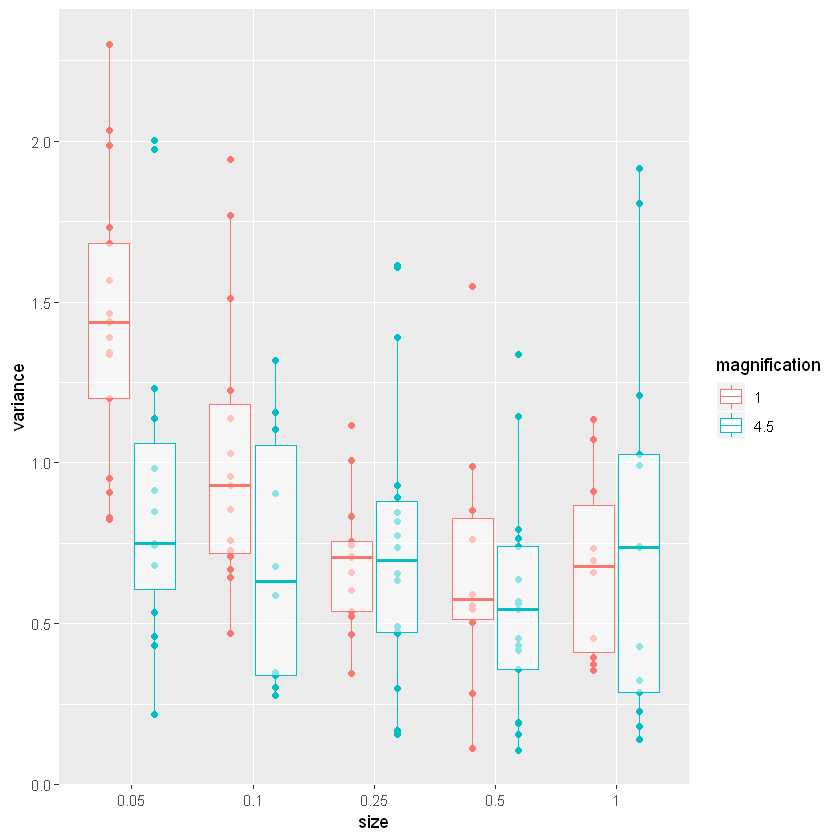

In [283]:
wl.var.plot(w.int.data,"within intermediate")

In [303]:
var.stats <- function(data,bl=FALSE){
    wl.data <- data
    wl.data$size <- as.numeric(wl.data$size)
    wl.data$magnification <- as.character(wl.data$magnification)
    
    if(bl){
        local.fit <- lm(formula = variance.corrected ~ size + magnification + magnification*size, data = wl.data)
    } else {
        local.fit <- lm(formula = variance ~ size + magnification + magnification*size, data = wl.data)
    }
    print(summary(local.fit))
    confint(local.fit,level=0.95)
}


In [287]:
var.stats(w.int.data)


Call:
lm(formula = variance ~ size + magnification + magnification * 
    size, data = wl.data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72495 -0.32326 -0.08163  0.22275  1.25217 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)             1.1670     0.0778  15.000  < 2e-16 ***
size                   -0.6568     0.1707  -3.848 0.000183 ***
magnification4.5       -0.3996     0.1119  -3.570 0.000496 ***
size:magnification4.5   0.5535     0.2338   2.368 0.019331 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4508 on 134 degrees of freedom
Multiple R-squared:  0.1531,	Adjusted R-squared:  0.1342 
F-statistic: 8.077 on 3 and 134 DF,  p-value: 5.506e-05



,2.5 %,97.5 %
(Intercept),1.01310437,1.3208507
size,-0.99437782,-0.3192246
magnification4.5,-0.62092267,-0.1782337
size:magnification4.5,0.09113371,1.0158775


##### Bayesian version: mu > adjacent colour scores

See whether the credible interval for the mean overlaps with some threshold cutoff, e.g. determined by the foveal para-diagonal values. Implement changes according to Gus' method

In [120]:
# discrete cdf function
cdf.discrete <- function(x,v){
    out <- vector()
    for(i in 1:length(v)){
        k <- sum(v[1:i])
        out[i] <- k
    }
    out.list <- list(x,out)
    names(out.list) <- c('x','y')
    return(out.list)
}

In [121]:
#sd(rep(0.1,10))

In [122]:
# specify possible values
possible <- seq(-7,7,0.5)
mu.prior <- rep(1/length(possible),length(possible)) # prior distribution is uniform over possible values

In [123]:
# obtain the credible interval for each cell in a difference matrix set
ci.mat <- function(diff.mats,ci=0.95){
    diff.vals <- mat.hist.plot(diff.mats,vals = TRUE) # distribution of subject values for each cell
    
    # specify possible values (min to max difference)
    possible <- seq(-7,7,0.5)
    prior <- rep(1/length(possible),length(possible))
    
    # for each entry in diff.vals, calculate a credible interval
    lb.v <- vector()
    ub.v <- vector()
    mean.v <- vector()
    for(cell in 1:length(diff.vals)){
        vals <- diff.vals[[cell]]
        # deal with NA cells
        if(anyNA(vals)){
            lb <- NA
            ub <- NA
        } else {
            # obtain the posterior. Assume normal with unknown mean and sd equal to that from the data (or 0.1 min sd)
            fit <- normdp(x=vals,sigma.x=max(sd(vals),0.1), mu=possible, mu.prior=prior,n.mu=length(possible),
                      plot=FALSE) 
            lb <- qnorm((1-ci)/2, mean=fit$mean, sd=sqrt(fit$var))
            ub <- qnorm(ci+(1-ci)/2, mean=fit$mean, sd=sqrt(fit$var))
        }
        
        lb.v <- c(lb.v,lb)
        ub.v <- c(ub.v,ub)
        mean.v <- c(mean.v,fit$mean)
        
    }
    out.list <- list(lb.v,ub.v,mean.v)
    names(out.list) <- c('lb','ub','mean')
    return(out.list)
}

In [124]:
# Plot the max(abs(lb,ub)) 
get.max.bounds <- function(ci.list){
    max.v <- vector()
    for(i in 1:length(ci.list$lb)){
        max.i <- max(abs(ci.list$lb[i]),abs(ci.list$ub[i]))
        max.v <- c(max.v,max.i)
    }
    return(max.v)
}

# get the proportion less than some threshold
ci.prop <- function(bounds,threshold=1){
    count <- sum(bounds >= threshold)
    return(round(count/length(bounds),2))
}

In [125]:
#ci.mat <- matrix(get.max.bounds(cis),9,9)
#round(ci.mat,2)
#mat.summary.plot(ci.mat,low.lim=0,up.lim=3,overall.title='credible interval bound',xlabel='',ylabel='',col1='green',col2='red')
#ci.prop(get.max.bounds(cis),1.92)

In [126]:
# make a plot, starting with the subset of the original df
ci.bayes.plot <- function(df,mats=FALSE,diff.mats=FALSE,submat='CCvPP',title='',out='plot'){
    if(mats){
        group.mats <- df
    } else {
        group.mats <- dissimgroup2matlist(df)
    }
    if(diff.mats){
        mls <- test.flat.mats(df,submat=submat)
        diff.mats <- flat.diff.mats(mls[[1]],mls[[2]])
    } else {
        diff.mats <- difference.mats(group.mats,submat=submat)
    }
    cis <- ci.mat(diff.mats)
    ci.mat <- matrix(get.max.bounds(cis),nrow(diff.mats[[1]]),ncol(diff.mats[[1]]))
    
    if(out=='v'){
        out.v <- na.omit(c(ci.mat))
        return(out.v)
    }
    
    plot <- mat.summary.plot(ci.mat,low.lim=0,up.lim=4,overall.title=title,xlabel='',ylabel='',col1='white',col2='blue',na.col='green')
    return(plot)
}

In [127]:
ci.summary.plot <- function(df,submat='CCvPP'){
    group.mats <- dissimgroup2matlist(df)
    diff.mats <- difference.mats(group.mats,submat=submat)
    cis <- ci.mat(diff.mats)
    
    mu <- mean(cis$mean)
    ub <- mean(cis$ub)
    lb <- mean(cis$lb)
    
    print(paste('mean',mu))
    print(paste('ub',ub))
    print(paste('lb',lb))
}

In [128]:
test.df <- subset(cleandf, peripheral_scale == 1 & stimulus_radius == 1)

ERROR: Error in subset(cleandf, peripheral_scale == 1 & stimulus_radius == 1): object 'cleandf' not found


In [129]:
ci.summary.plot(test.df)

ERROR: Error in unique(df$subject): object 'test.df' not found


In [130]:
#ci.bayes.plot(test.df,mats=TRUE,diff.mats=TRUE,out='v')

In [131]:
#insane[[1]]

#insane <- insane.mats(15,CC='uniform',PP='gaussian',val=4,mu=4)
#t.plot(insane,mats=TRUE)
#ci.bayes.plot(insane,mats=TRUE)
#difference.mats(insane)

##### t-score version: mu = 0

Obtain & plot the t-score for whether the mean of each difference cell is different to zero  
Null hypothesis that mu = 0

In [132]:
test.cell <- test.vals[[72]]
#test.cell

ERROR: Error in eval(expr, envir, enclos): object 'test.vals' not found


In [133]:
t.test.mu.zero <- function(cell, out='t', verbose=FALSE){
    test <- t.test(cell,
                  alternative = c("two.sided"),
                  mu = 0,
                  conf.level = 0.95)
    ci <- test$conf.int
    t <- test$statistic
    p <- test$p.value
    
    if(verbose){
        print(ci)
        print(t)
        print(p)
    }
    if(out=='t'){
        return(t)
    } else if(out=='ci'){
        return(ci)
    }
    
}

In [134]:
max(abs(t.test.mu.zero(test.cell,out='ci')))

ERROR: Error in t.test(cell, alternative = c("two.sided"), mu = 0, conf.level = 0.95): object 'test.cell' not found


In [135]:
# make a matrix out of the t-scores for plotting purposes
t.mat <- function(difference.mats){
    mat.vals <- mat.hist.plot(difference.mats,vals=TRUE)
    n.qualia <- nrow(difference.mats[[1]])
    out.mat <- matrix(,nrow=n.qualia,ncol=n.qualia)
    
    for(cell in 1:length(mat.vals)){
        t <- t.test.mu.zero(mat.vals[[cell]],'t')
        out.mat[cell] <- t
    }
    return(out.mat)
}

In [136]:
# make a plot, starting with the subset of the original df
t.plot <- function(df,mats=FALSE,submat='CCvPP',title=''){
    if(mats){
        group.mats <- df
    } else {
        group.mats <- dissimgroup2matlist(df)
    }
    
    diff.mats <- difference.mats(group.mats,submat=submat)
    t.test.mat <- t.mat(diff.mats)
    
    plot <- mat.summary.plot(t.test.mat, low.lim=-4,up.lim=4,
                            xlabel = '', ylabel = '', col1 = 'green', col2='red',overall.title=title,na.col='purple')
    return(plot)
}

In [137]:
test <- subset(cleandf, stimulus_radius==1 & peripheral_scale == 1)
t.plot(test)

ERROR: Error in subset(cleandf, stimulus_radius == 1 & peripheral_scale == 1): object 'cleandf' not found


In [138]:
t.test.mat <- t.mat(test.mat)
#max(t.test.mat)
#min(t.test.mat)
mat.summary.plot(t.test.mat, low.lim=-4,up.lim=1.5)

ERROR: Error in mat.hist.plot(difference.mats, vals = TRUE): object 'test.mat' not found


##### t-score version: mu > adjacent colour scores

Obtain & plot whether the confidence interval of the mean overlaps with some threshold dissimilarity value for each cell

In [139]:
ci.overlap <- function(difference.mats,threshold=1,binary=TRUE){
    mat.vals <- 
    (difference.mats,vals=TRUE)
    n.qualia <- nrow(difference.mats[[1]])
    out.mat <- matrix(,nrow=n.qualia,ncol=n.qualia)
    
    for(cell in 1:length(mat.vals)){
        ci <- t.test.mu.zero(mat.vals[[cell]],'ci')
        val <- max(abs(ci))
        if(binary){
            if(val <= threshold){
                out.mat[cell] <- 0 # mean is probably zero
            } else {
                out.mat[cell] <- 1 # mean might not be zero
            }
        } else {
            out.mat[cell] <- val
        }
        
        
    }
    return(out.mat)
}

ERROR: Error in parse(text = x, srcfile = src): <text>:3:21: unexpected ','
2:     mat.vals <- 
3:     (difference.mats,
                       ^


In [140]:
ci.test.mat <- ci.overlap(test.mat,threshold=1.5,binary=FALSE)
#mat.summary.plot(ci.test.mat,low.lim=0,up.lim=2.5)

ERROR: Error in ci.overlap(test.mat, threshold = 1.5, binary = FALSE): could not find function "ci.overlap"


##### Permutation version: difference XXi-YYi < difference XXi-XXj

Compare the abs(mean) of a cell (XXi-YYi) to the abs(mean) of 1000 randomly compared XXi-YYj cells. See how close to the bottom of the distribution it is, i.e. how similar it is compared to other judgments. Also collect the proportion of these random means that fall outside the cutoff threshold

In [141]:
#mat.summary.plot(test[[1]],low.lim=0,up.lim=7,xlabel='',ylabel='')
#mat <- test[[3]]
#CC.mat <- mat[1:9,1:9]
#PP.mat <- mat[10:18,10:18]
#mat.summary.plot(CC.mat,,low.lim=0,up.lim=7,xlabel='',ylabel='')
#PP.shuffle <- shuffle_matrix(PP.mat)
#mat.summary.plot(CC.mat-PP.shuffle,low.lim=-7,up.lim=7,xlabel='',ylabel='')

#mat.summary.plot(PP.shuffle,low.lim=0,up.lim=7,xlabel='',ylabel='')

In [142]:
# convert a list of vectors to a vector of just their mean values
list2mean <- function(list.vals){
    out <- vector()
    for(cell in 1:length(list.vals)){
        out[cell] <- mean(list.vals[[cell]])
    }
    return(out)
}

# what 

In [143]:
#list2mean(test.vals)
#mat.histdifference.mats(test,submat='CCvPP')

In [144]:
permute.test.mat <- function(subject.mats,n.perm=5,submat='CCvPP',diagnose=FALSE){
    diff.mats <- difference.mats(subject.mats,submat=submat) # list of difference matrices for each subject XXi-YYi
    diff.vals <- mat.hist.plot(diff.mats,vals=TRUE) # distribution of subject values for each cell
    diff.means <- list2mean(diff.vals) # vector of cell means
    
    if(diagnose){
        print("diff.means")
        print(diff.means)
    }
    
    # do the permutations
    k = 1
    permute.list <- list()
    for(i in 1:n.perm){ # for however many permutations
        if(diagnose){
            print(paste("permutation:",k))
        }
        perm.mats <- difference.mats(subject.mats,submat=submat,shuffle=TRUE) # list of difference matrices for each subject XXi-YYj (shuffled)
        if(diagnose){
            print(perm.mats)
        }
        perm.vals <- mat.hist.plot(perm.mats,vals=TRUE) # turn the shuffled list into difference values for each cell
        perm.means <- list2mean(perm.vals) # turn the difference values for each cell into just their means
        permute.list[[k]] <- perm.means # add vector to list (list of vectors of difference means)
        k = k + 1
    }
    
    if(diagnose){
        #print("permuted list")
        #print(permute.list)
    }
    
    # do the test
    # for each entry in diff.means, compare the entry to the corresponding entries in each vector in permute.list
    out <- vector()
    for(cell in 1:length(diff.means)){
        real.mean <- diff.means[cell]
        
        # grab the vector of shuffled means for this cell
        fake.vec <- vector()
        for(perm in 1:n.perm){
            fake.vec <- c(fake.vec, permute.list[[perm]][cell])
        }
        
        
        # calcualte the p-value
        count <- sum(abs(fake.vec) <= abs(real.mean))
        p <- round(count/length(fake.vec),2)
        out <- c(out,p)
        
        if(diagnose){
            print(paste("cell",cell))
            print(paste("real mean",real.mean))
            print("permuted means")
            print(fake.vec)
            print(paste("count",count))
            print(paste("p",p))
        }
    }
    
    return(out)
}

In [145]:
# permutation plot
permute.plot <- function(df,submat='CCvPP',n.perm=1000, title=''){
    group.mats <- dissimgroup2matlist(df)
    #diff.mats <- difference.mats(group.mats)
    
    p.mat <- matrix(permute.test.mat(group.mats,n.perm=n.perm,submat=submat),9,9)
    plot <- mat.summary.plot(p.mat,low.lim=0,up.lim=1,overall.title=title,xlabel='',ylabel='',col1='green',col2='red')
    return(plot)
}

In [146]:
permute.plot(test)

ERROR: Error: $ operator is invalid for atomic vectors


In [ ]:
print("1000")
p.mat <- matrix(permute.test.mat(test,n.perm=1000,diagnose=FALSE),9,9)
p.mat
mat.summary.plot(p.mat,low.lim=0,up.lim=1,overall.title='p.values',xlabel='',ylabel='',col1='red',col2='green')

### Intermediate Within-Subject Analysis

In [147]:
test.df <- subset(cleandf, peripheral_scale == 1 & stimulus_radius == 1)

ERROR: Error in subset(cleandf, peripheral_scale == 1 & stimulus_radius == 1): object 'cleandf' not found


In [148]:
test.mats.CC <- bs.flat.list(test.df,comparison='CC',smooth=TRUE)
test.mats.PP <- bs.flat.list(test.df,comparison='PP',smooth=TRUE)


ERROR: Error in unique(df$subject): object 'test.df' not found


In [149]:
# generate the appropriate flat rank matrices
test.flat.mats <- function(df,submat='CCvPP',smooth=FALSE){
    out.list <- list()
    if(submat=='CCvPP'){
        ml1 <- bs.flat.list(df,comparison='CC',smooth=smooth)
        ml2 <- bs.flat.list(df,comparison='PP',smooth=smooth)
    } else if (submat=='CPvPP'){
        ml1 <- bs.flat.list(df,comparison='CP',smooth=smooth)
        ml2 <- bs.flat.list(df,comparison='PP',smooth=smooth)
    } else if (submat=='CCvCP'){
        ml1 <- bs.flat.list(df,comparison='CC',smooth=smooth)
        ml2 <- bs.flat.list(df,comparison='CP',smooth=smooth)
    }
    out.list[[1]] <- ml1
    out.list[[2]] <- ml2
    return(out.list)
}

# generate the difference flat rank matrices within-subject
flat.diff.mats <- function(ml1,ml2){
    out.list <-list()
    for(i in 1:length(ml1)){
        diff.mat <- ml1[[i]] - ml2[[i]]
        out.list[[i]] <- diff.mat
    }
    return(out.list)
}
test.mats.diff <- flat.diff.mats(test.mats.CC,test.mats.PP)

ERROR: Error in flat.diff.mats(test.mats.CC, test.mats.PP): object 'test.mats.CC' not found


In [150]:
#test.mats.CC[1]
#test.mats.PP[1]
#test.mats.diff[1]
#plot.rank.mat.generic(test.mats.diff[[1]],low.lim=-7,up.lim=7)

In [151]:
# do the bayes test
ci.bayes.plot(test.mats.diff,mats=TRUE,diff.mats=TRUE)

ERROR: Error in ci.bayes.plot(test.mats.diff, mats = TRUE, diff.mats = TRUE): object 'test.mats.diff' not found


In [152]:
normdp(c(1),quiet=FALSE)

ERROR: Error in normdp(c(1), quiet = FALSE): unused argument (quiet = FALSE)


#### Plot Summary of everything

In [153]:
data.summary.test <- function(df,test='bayes',submat='CCvPP',diagnose=FALSE){
    
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_radius))
    
    return_df <- data.frame(matrix(nrow=0,ncol=3))
    names <- c('values','magnification','size')
    colnames(return_df) <- names
    
    for (stimulus in size_list){
        for (scale in magnification_list){
            tempdf <- subset(datadf, peripheral_scale == scale & stimulus_radius == stimulus)
            
            if(test=='bayes'){
                data <- ci.bayes.plot(tempdf,submat=submat,out='v')
            } else if(test=='bayes.rank'){
                data <- ci.bayes.plot(tempdf,mats=TRUE,diff.mats=TRUE,submat=submat,out='v')  
                
            } else if (test=='CI'){
                data <- ci.bayes.plot(tempdf,submat=submat,out='v') # max CI bound for each cell
                data <- median(data)  # median across all the cells
            }
            if(diagnose){
                print(head(data,5))
            }
            data.df <- data.frame(matrix(nrow=length(data),ncol=3))
            if(diagnose){
                print(data.df)
            }
            colnames(data.df) <- names
            if(diagnose){
                print(data.df)
            }
            data.df$values <- data
            data.df$magnification <- scale
            data.df$size <- stimulus
            if(diagnose){
                print(data.df)
            }
            return_df <- rbind(return_df,data.df)
            }
        }
    return(return_df)
}

In [154]:
summary.CI <- function(df,submat='CCvPP'){
    
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_radius))
    names <- c('magnification','size','mean','lb','ub')
    return_df <- data.frame(matrix(nrow=0,ncol=length(names)))
    colnames(return_df) <- names
    
    for (stimulus in size_list){
        for (scale in magnification_list){
            tempdf <- subset(datadf, peripheral_scale == scale & stimulus_radius == stimulus)
            
            group.mats <- dissimgroup2matlist(tempdf)
            diff.mats <- difference.mats(group.mats,submat=submat)
            cis <- ci.mat(diff.mats)

            mu <- mean(cis$mean)
            ub <- mean(cis$ub)
            lb <- mean(cis$lb)
            
            data.df <- data.frame(matrix(nrow=length(data),ncol=length(names)))
            colnames(data.df) <- names
            data.df$magnification <- scale
            data.df$size <- stimulus
            data.df$mean <- mu
            data.df$ub <- ub
            data.df$lb <- lb
            
            return_df <- rbind(return_df,data.df)
            }
        }
    return(return_df)
}

plot.summary.ci <- function(df){
    df$magnification <- as.character(df$magnification) # needed for axes to work properly
    df$size <- as.character(df$size)
    
    plot <- ggplot(df, aes(y=mean, x=magnification,color=size)) +
                    geom_point(position=position_dodge(width=0.75),size=4) +
                    geom_errorbar(aes(ymax = ub, ymin = lb),
                                  position=position_dodge(width=0.75),
                                 width=0.5,
                                 size=1) +
                    ylim(-1.5,1.5) +
                    geom_hline(yintercept=0) +
                    ylab('Dissimilarity Difference') + xlab('Peripheral Magnification') + 
                    guides(color=guide_legend(title = 'Stimulus Size\n(DVA)'))
    
    
    ggsave(plot = plot, width=10,height = 5, filename='ci.summary.png')
    
    return(plot)
}

In [155]:
#data.ci <- summary.CI(cleandf)

In [156]:
#data.ci

In [157]:
plot.summary.ci(data.ci)

ERROR: Error in plot.summary.ci(data.ci): object 'data.ci' not found


In [158]:
plot.summary.test <- function(df){
    
    df$magnification <- as.character(df$magnification) # needed for axes to work properly
    df$size <- as.character(df$size)
    
    plot <- ggplot(df, aes(y=values, x=magnification,color=size)) +
            geom_boxplot(aes(alpha=0.5)) + 
            geom_point(position=position_dodge(width=0.75),aes(alpha=0.01)) +
            ylab("Max(|95% CI Bound|)\nper cell") + 
            xlab("Peripheral Scaling") +
            guides(color=guide_legend(title = 'Stimulus Radius\n(DVA)')) + scale_alpha(guide='none') +
            theme(text=element_text(size=20)) +
            theme(axis.title.y = element_text(margin=margin(t=0,b=0,r=15,l=0)))
    
    ggsave(plot = plot, width=15,height = 7.5, filename='bayes.ci.test.png')
    
    return(plot)
    
}

In [159]:
#plot.summary.test(data)
#plot.summary.test(data.rank)
plot.summary.CI(data.CI)

ERROR: Error in plot.summary.CI(data.CI): could not find function "plot.summary.CI"


In [160]:
#data.rank <- data.summary.test(cleandf,test='bayes.rank')
data.CI <- data.summary.test(cleandf,test='CI')

ERROR: Error in unique(datadf$peripheral_scale): object 'datadf' not found


In [161]:
data <- data.summary.test(cleandf,diagnose=FALSE)

ERROR: Error in unique(datadf$peripheral_scale): object 'datadf' not found


In [ ]:
test.df <- subset(cleandf,  (peripheral_scale == 4.5))

In [162]:
FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(test.df,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(test.df,l2e('Foveal'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(test.df,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))


FFcmds
FPcmds
PPcmds

ERROR: Error in subset(datadf, Circle_1 == eccentricity1 & Circle_2 == eccentricity2): object 'test.df' not found


## Actual Data Analysis Time

#### Initial data pre-processing, before getting to the subject level

In [163]:
datadf = read.csv(filename)
savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later


In [164]:
#weird bug in a subject data for arielzj_fvp_2stim_fixed_point25dva_v2_20_08_30 (1)
datadf <- subset(datadf, (subject != 660294531) & (subject != 21721408) & (subject != 238973028))

In [165]:
# remove practice trial data
datadf <- subset(datadf, blockcode == 'experiment')

In [166]:
# changing color values from RGB to hex for graphing purpose
datadf$Color_1 <- as.character(datadf$Color_1)
datadf$Color_1 <- revalue(datadf$Color_1, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))
datadf$Color_2 <- as.character(datadf$Color_2)
datadf$Color_2 <- revalue(datadf$Color_2, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))



In [167]:
# changing from int indicators in the .csv file to more readable labels for eccentricity
foveal = -1
peripheral = 1

In [168]:
# set the maximum and minimum dissimilarity values for later analysis
min_val = 0
max_val = 6

In [169]:
# binning the positions the stimuli were displayed in to use as a control measure later
datadf$bin1 <- as.integer((datadf$Position_1+180) / 40) + 1
datadf$bin2 <- as.integer((datadf$Position_2+180) / 40) + 1

In [170]:
# adding a trial type label
label_eccen_type <- function(datadf){
    datadf <- datadf %>%
    mutate(eccen_type = case_when(Circle_1 == l2e('Foveal') & Circle_2 == l2e('Foveal') ~ 'FF',
                             Circle_1 == l2e('Foveal') & Circle_2 == l2e('Peripheral') ~ 'FP',
                             Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Peripheral') ~ 'PP'))
    return(datadf)
}

In [171]:
datadf <- label_eccen_type(datadf)

Some actual data cleaning

In [172]:
# function to throw out  participants who didn't finish
remove_incomplete <- function(datadf,stimuli_number){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    print(paste(length(subjectlist),"in dataset"))
    print("")
    
    for (ID in subjectlist){ # go through subject by subject
        
        trialnumber = stimuli_number*stimuli_number*condition_number + catch_trial_number
        
        trialsdone <- nrow(subset(datadf, subject == ID))
        print(paste("Subject",ID,"completed",trialsdone,"/",trialnumber))
        
        if ( trialsdone != trialnumber){ # see if they have the appropriate trial numbers
            datadf <- subset(datadf, subject != ID) # dump the subject
        }
    }
    return(datadf)
}

In [173]:
screen_parameters(datadf)

[1] "Screen Parameters"
[1] ""
[1] "Screen size issues: 0 / 191"
[1] "Viewing distance issues: 0 / 191"


In [174]:
# actually throw out the subjects who didn't complete
datadf <- remove_incomplete(datadf,stimuli_number)

[1] "191 in dataset"
[1] ""
[1] "Subject 3248455 completed 253 / 253"
[1] "Subject 9522584 completed 253 / 253"
[1] "Subject 11005010 completed 253 / 253"
[1] "Subject 13228849 completed 253 / 253"
[1] "Subject 35587329 completed 253 / 253"
[1] "Subject 35716339 completed 253 / 253"
[1] "Subject 40354804 completed 253 / 253"
[1] "Subject 41471776 completed 32 / 253"
[1] "Subject 48341337 completed 253 / 253"
[1] "Subject 50823202 completed 253 / 253"
[1] "Subject 51805023 completed 253 / 253"
[1] "Subject 53858324 completed 253 / 253"
[1] "Subject 63991259 completed 253 / 253"
[1] "Subject 64413254 completed 253 / 253"
[1] "Subject 74258126 completed 12 / 253"
[1] "Subject 75394365 completed 253 / 253"
[1] "Subject 80499026 completed 253 / 253"
[1] "Subject 81903961 completed 253 / 253"
[1] "Subject 95990930 completed 2 / 253"
[1] "Subject 98665966 completed 253 / 253"
[1] "Subject 99640956 completed 253 / 253"
[1] "Subject 107179842 completed 37 / 253"
[1] "Subject 120361401 completed

In [175]:
# function to label participants who meet statistical cleaning assumptions
label_noncompliant <- function(datadf,
                               screen_size_cutoff=26,viewing_distance_cutoff=30,rt_cutoff=600,score_cutoff=0.7){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest 
        
        screen_size <- round(screen_size(subjectdf)/10,1)
        viewing_distance <- round(view_distance(subjectdf)/10,1)
        catch_score <- catch_score(subjectdf)
        
        if(catch_score > score_cutoff){ # catch score cutoff
            if(screen_size > screen_size_cutoff){ # screen size cutoff
                if(viewing_distance > viewing_distance_cutoff){ # viewing distance cutoff
                    if(rt_avg(subjectdf) > rt_cutoff){ # rt cutoff
                        datadf$noncompliant[datadf$subject == ID] = 0
                    } else {
                        print(paste("Subject",ID,"reaction time of:",rt_avg(subjectdf),"ms",sep=' ')) # RT fail
                        datadf$noncompliant[datadf$subject == ID] = 1
                    }
                } else {
                    print(paste("Subject",ID,"viewing distance of:",viewing_distance,"cm",sep=' ')) # Viewing distance fail
                    datadf$noncompliant[datadf$subject == ID] = 2
                }
            } else {
                print(paste("Subject",ID,"had a screen size of:",screen_size,"cm",sep=' ')) # Screen size fail
                datadf$noncompliant[datadf$subject == ID] = 3
            } 
      } else {
            print(paste("Subject",ID,"had a catch score of: ",catch_score,sep=' ')) # Catch score faile
            datadf$noncompliant[datadf$subject == ID] = 4
        }
    }
    print(paste(length(unique(datadf$subject[datadf$noncompliant==0])),"of",length(unique(datadf$subject)),
                "were compliant",sep=' '))
    return(datadf)
}

In [176]:
catch_trial_checker(datadf)

[1] "Catch scores"
[1] "Subject 3248455 : 10 / 10"
[1] "Subject 9522584 : 6 / 10"
[1] "Subject 11005010 : 10 / 10"
[1] "Subject 13228849 : 9 / 10"
[1] "Subject 35587329 : 10 / 10"
[1] "Subject 35716339 : 10 / 10"
[1] "Subject 40354804 : 10 / 10"
[1] "Subject 48341337 : 10 / 10"
[1] "Subject 50823202 : 10 / 10"
[1] "Subject 51805023 : 10 / 10"
[1] "Subject 53858324 : 9 / 10"
[1] "Subject 63991259 : 10 / 10"
[1] "Subject 64413254 : 10 / 10"
[1] "Subject 75394365 : 10 / 10"
[1] "Subject 80499026 : 10 / 10"
[1] "Subject 81903961 : 6 / 10"
[1] "Subject 98665966 : 10 / 10"
[1] "Subject 99640956 : 10 / 10"
[1] "Subject 120361401 : 1 / 10"
[1] "Subject 133207874 : 7 / 10"
[1] "Subject 147071530 : 7 / 10"
[1] "Subject 165762185 : 10 / 10"
[1] "Subject 170537732 : 10 / 10"
[1] "Subject 172093576 : 7 / 10"
[1] "Subject 176476116 : 10 / 10"
[1] "Subject 176698125 : 10 / 10"
[1] "Subject 204525930 : 10 / 10"
[1] "Subject 211745977 : 10 / 10"
[1] "Subject 219326440 : 7 / 10"
[1] "Subject 225280441 :

In [177]:
datadf <- label_noncompliant(datadf)

[1] "Subject 9522584 had a catch score of:  0.6"
[1] "Subject 81903961 had a catch score of:  0.6"
[1] "Subject 120361401 had a catch score of:  0.1"
[1] "Subject 133207874 had a catch score of:  0.7"
[1] "Subject 147071530 had a catch score of:  0.7"
[1] "Subject 172093576 had a catch score of:  0.7"
[1] "Subject 219326440 had a catch score of:  0.7"
[1] "Subject 244316230 had a catch score of:  0.5"
[1] "Subject 252347716 had a catch score of:  0.6"
[1] "Subject 254207207 had a catch score of:  0.4"
[1] "Subject 265310712 had a catch score of:  0.1"
[1] "Subject 285550479 had a catch score of:  0.1"
[1] "Subject 307922435 had a catch score of:  0.4"
[1] "Subject 369400829 had a catch score of:  0.7"
[1] "Subject 373678849 reaction time of: 444 ms"
[1] "Subject 382104984 had a catch score of:  0"
[1] "Subject 392751046 reaction time of: 476 ms"
[1] "Subject 429304075 had a catch score of:  0.4"
[1] "Subject 431543630 reaction time of: 559 ms"
[1] "Subject 463372698 had a catch score o

In [178]:
# function to run all these checks at once
validation <- function(datadf){
    
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_radius))
    
    for (stimulus in size_list){
        for (scale in magnification_list){
            tempdf <- subset(datadf, peripheral_scale == scale & stimulus_radius == stimulus)
            
            print(paste("Magnification",scale,"Stimulus",stimulus))
            tempdf <- remove_incomplete(tempdf,stimuli_number)
            screen_parameters(tempdf, individual=FALSE)
            catch_trial_checker(tempdf)
            label_noncompliant(tempdf)
            print("")
            print("____________________")
            print("")
            
        }
    }
}

In [179]:
validation(datadf)

[1] "Magnification 1 Stimulus 0.05"
[1] "18 in dataset"
[1] ""
[1] "Subject 11005010 completed 253 / 253"
[1] "Subject 64413254 completed 253 / 253"
[1] "Subject 294207097 completed 253 / 253"
[1] "Subject 338738516 completed 253 / 253"
[1] "Subject 340691821 completed 253 / 253"
[1] "Subject 343319516 completed 253 / 253"
[1] "Subject 373678849 completed 253 / 253"
[1] "Subject 376591610 completed 253 / 253"
[1] "Subject 507377004 completed 253 / 253"
[1] "Subject 603387860 completed 253 / 253"
[1] "Subject 626450633 completed 253 / 253"
[1] "Subject 682309552 completed 253 / 253"
[1] "Subject 689093004 completed 253 / 253"
[1] "Subject 754276419 completed 253 / 253"
[1] "Subject 821695709 completed 253 / 253"
[1] "Subject 902494953 completed 253 / 253"
[1] "Subject 909015666 completed 253 / 253"
[1] "Subject 960528676 completed 253 / 253"
[1] "Screen Parameters"
[1] ""
[1] "Screen size issues: 0 / 18"
[1] "Viewing distance issues: 0 / 18"
[1] "Catch scores"
[1] "Subject 11005010 : 10

In [180]:
# some subjects got confused about the rating system and inverted it. functions to flip them back (for the pilot data)
invert.DSR <- function(subjectdf){
    subjectdf$similarity <- -1 * subjectdf$similarity + max.DSR
    return(subjectdf)
}

invert.subjects <- function(datadf){
     subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        subjectdf <- subset(datadf, subject == ID)
        if(trace_avg(subjectdf) > max.DSR/2){ # if they mistakenly inverted
            datadf$similarity[datadf$subject == ID] <- -1 * datadf$similarity + max.DSR
            }
        }
    return(datadf)
            
}

In [181]:
cleandf <- subset(datadf, noncompliant == 0)
get_n(cleandf)

[1] "There are 138 unique subjects"


[1] 138

In [182]:
cleandf <- invert.subjects(cleandf)

## Statistical Analysis

### Useful functions & methods

#### Determine within-subject central and peripheral QDM correlation & significance

In [183]:
# return a list of the e1 matrix vs e2 matrix correlations for each subject
# returns Fisher-transformed correlations
# updated matrixcor to use just half of a symmetric matrix

eccentricity_compare_list <- function(datadf,e1='FF',e2='PP'){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest
        # updated matrixcor to use only upper half of symmeterised matrices
        correlation_list <- c(correlation_list, FisherZ((matrixcor(subjectdf,M1=e1,M2=e2))))
    }
    return(correlation_list)
}

In [184]:
# shuffle a matrix
shuffle_matrix <- function(matrix){
    shuffled <- matrix[sample(nrow(matrix)),sample(ncol(matrix))]
    return(shuffled)
}

In [185]:
# get upper half of a matrix in vector form
halfmat.v <- function(mat){
    halfmat <- c(mat[upper.tri(mat, diag = TRUE)])
    return(halfmat)
}

In [186]:
# return a list of the e1 matrix vs. shuffled e2 matrix for each subject. Pick the # shuffles, default 1000.
# returns Fisher-transformed correlations
# updated df2mat.full to use a symmetric matrix

eccentricity_compare_shuffled_list <- function(datadf,e1='FF',e2='PP',
                                               mode='shuffle', rotation=90, shuffle_num=1000){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    
    correlation_list <- vector() # array to store the values in
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest
                
        if((e1 == 'FF' & e2 == 'PP') | (e1 == 'PP' & e2 == 'FF')){
            matrix1 <- df2mat.full(subjectdf, l2e('Foveal'), l2e('Foveal'))
            matrix2 <- df2mat.full(subjectdf, l2e('Peripheral'), l2e('Peripheral'))
        } else if ((e1 == 'FF' & e2 == 'FP') | (e1 == 'FP' & e2 == 'FF')){
            matrix1 <- df2mat.full(subjectdf, l2e('Foveal'), l2e('Foveal'))
            matrix2 <- df2mat.full(subjectdf, l2e('Foveal'), l2e('Peripheral'))
        } else if ((e1 == 'PP' & e2 == 'FP') | (e1 == 'FP' & e2 == 'PP')){
            matrix1 <- df2mat.full(subjectdf, l2e('Peripheral'), l2e('Peripheral'))
            matrix2 <- df2mat.full(subjectdf, l2e('Foveal'), l2e('Peripheral'))
        }
        
        #just use upper halves of matrices as they're symmetric
        matrix1 <- halfmat.v(matrix1)
        
        temp_list <- vector()
        for (i in 1:shuffle_num){ #shuffle/swap the second matrix, add values to temp list
            
            if(mode=='shuffle'){
                matrix2_shuffled <- shuffle_matrix(matrix2)
            } else if (mode == 'swap'){
                matrix2_shuffled <- matswap(matrix2,'random')
            } else if (mode == 'invert'){
                matrix2_shuffled <- matswap(matrix2,'inversion')
            } else if (mode == 'rotate'){
                matrix2_shuffled <- matswap(matrix2,'rotation',rotation)
            }
            #just use upper halves of matrices as they're symmetric
            matrix2_shuffled <- halfmat.v(matrix2_shuffled)
            
            temp_list <- c(temp_list, FisherZ(cor(matrix1, matrix2_shuffled, method = "spearman")))
        }
        
        correlation_list <- c(correlation_list,mean(temp_list)) # add the average correlation to the list
        }
    return(correlation_list)
}

In [187]:
# Compare FF, FP & PP correlations under standard, swapped & shuffled modes
# currently just doing a single swap per subject, need to update to multiple swaps
# updated to use full matrix

within_full_compare <- function(df,swap='PP',individual=FALSE){
    
    return_df <- data.frame() # initialisation
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    
    mode.list <- c("identity","random","invert","rotate")
    
    for(mode in mode.list){
        
        # arrays to store the values in
        standard.FFvPP.correlation_list <- vector()
        standard.FFvFP.correlation_list <- vector()
        standard.FPvPP.correlation_list <- vector()

        swapped.FFvPP.correlation_list <- vector()
        swapped.FFvFP.correlation_list <- vector()
        swapped.FPvPP.correlation_list <- vector()

        for (ID in subjectlist){ # go through subject by subject
            subjectdf = subset(df, subject == ID) # select the ID for subject of interest
            data <- dissimdata.subject(subjectdf,duplicate = TRUE) # get the data in the format we want

            # get full identity & swapped matrices for the subject
            matrix.identity <- color.eccen.mat(data,output='matrix',mode='identity')
            matrix.swap <- color.eccen.mat(data,output='matrix',mode=mode)
            
            matrix.FF <- matrix.identity[1:9,1:9]
            matrix.FP <- matrix.identity[1:9,10:18]
            matrix.PP <- matrix.identity[10:18,10:18]

            # standard conditions comparison
            if(mode=='identity'){
                standard.FFvPP.r <-  cor(halfmat.v(matrix.FF),halfmat.v(matrix.PP), method = "spearman")
                standard.FFvFP.r <-  cor(halfmat.v(matrix.FF),halfmat.v(matrix.FP), method = "spearman")
                standard.FPvPP.r <-  cor(halfmat.v(matrix.FP),halfmat.v(matrix.PP), method = "spearman")
            } else {
            # swapped conditions comparison
            swap.FF <- matrix.swap[1:9,1:9]
            swap.FP <- matrix.swap[1:9,10:18]
            swap.PP <- matrix.swap[10:18,10:18]
            
            swapped.FFvPP.r <-  cor(halfmat.v(swap.FF),halfmat.v(swap.PP), method = "spearman")
            swapped.FFvFP.r <-  cor(halfmat.v(swap.FF),halfmat.v(swap.FP), method = "spearman")
            swapped.FPvPP.r <-  cor(halfmat.v(swap.FP),halfmat.v(swap.PP), method = "spearman") 
            }
            

            if(individual){
                print(paste("Subject: ",ID))
                print("Standard comparisons")
                print(paste("FF vs PP: ",round(standard.FFvPP.r,2)," - ",
                           "FF vs FP: ",round(standard.FFvFP.r,2)," - ",
                           "FP vs PP: ",round(standard.FPvPP.r,2)))
                print(paste("Swapped comparisons -",swap,"swapped",mode))
                print(paste("FF vs PP: ",round(swapped.FFvPP.r,2)," - ",
                           "FF vs FP: ",round(swapped.FFvFP.r,2)," - ",
                           "FP vs PP: ",round(swapped.FPvPP.r,2)))
            }

            # add them to a list
            if(mode=='identity'){
                standard.FFvPP.correlation_list <- c(standard.FFvPP.correlation_list,FisherZ(standard.FFvPP.r))
                standard.FFvFP.correlation_list <- c(standard.FFvFP.correlation_list,FisherZ(standard.FFvFP.r))
                standard.FPvPP.correlation_list <- c(standard.FPvPP.correlation_list,FisherZ(standard.FPvPP.r))
            } else {
                swapped.FFvPP.correlation_list <- c(swapped.FFvPP.correlation_list,FisherZ(swapped.FFvPP.r))
                swapped.FFvFP.correlation_list <- c(swapped.FFvFP.correlation_list,FisherZ(swapped.FFvFP.r))
                swapped.FPvPP.correlation_list <- c(swapped.FPvPP.correlation_list,FisherZ(swapped.FPvPP.r))
            }
            
            # make a dataframe with all the useful information. Correlations returned are Fisher transformed
            if(mode=='identity'){
                FFvPP <- FisherZ(standard.FFvPP.r)
                FFvFP <- FisherZ(standard.FFvFP.r)
                FPvPP <- FisherZ(standard.FPvPP.r)
                
            } else {
                FFvPP <- FisherZ(swapped.FFvPP.r)
                FFvFP <- FisherZ(swapped.FFvFP.r)
                FPvPP <- FisherZ(swapped.FPvPP.r)
            }
            subject.data <- data.frame(ID,
                                        mode,
                                        FFvPP,
                                        FFvFP,
                                        FPvPP
                                          )
            return_df <- rbind(return_df,subject.data)
            
        }
        # print mean correlations
        if(mode=='identity'){
            print("Standard comparisons")
            print(paste("FF vs PP: ",round(average_correlation(standard.FFvPP.correlation_list),2)," - ",
                   "FF vs FP: ",round(average_correlation(standard.FFvFP.correlation_list),2)," - ",
                   "FP vs PP: ",round(average_correlation(standard.FPvPP.correlation_list),2)))
        } else {
            print(paste("Swapped comparisons -",swap,"swapped -",mode))
            print(paste("FF vs PP: ",round(average_correlation(swapped.FFvPP.correlation_list),2)," - ",
                   "FF vs FP: ",round(average_correlation(swapped.FFvFP.correlation_list),2)," - ",
                   "FP vs PP: ",round(average_correlation(swapped.FPvPP.correlation_list),2)))
        }
      
        
        
    }
    return(return_df)
}

In [188]:
# perform Mann-Whitney U test to compare the within-subject central and peripheral QDMs to randomly shuffled ones
QDM_test <- function(original_correlations,shuffled_correlations){
    
    wilcox.test(original_correlations,shuffled_correlations)
}

#### Determine between-subject central to central QDM correlation & significance

In [189]:
# obtain the subject similarity matrix
# returns Fisher-transformed correlations

i_j_list <- function(datadf, eccentricity1=l2e('Foveal'), eccentricity2=l2e('Foveal'),shuffle=FALSE){
    
    datadf = subset(datadf, Circle_1 == eccentricity1)
    datadf = subset(datadf, Circle_2 == eccentricity2)
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (ID_i in subjectlist){ 
        subjectdf_i = subset(datadf, subject == ID_i)
        if(shuffle){
            # get their shuffled fovea QDM
            fmatrix_i <- shuffle_matrix(df2mat(subjectdf_i, l2e('Foveal'), l2e('Foveal'))) 
        } else {
            # get their fovea QDM
            fmatrix_i <- df2mat(subjectdf_i, l2e('Foveal'), l2e('Foveal'))
        }
        for (ID_j in subjectlist){
            if(ID_i != ID_j){
                
                subjectdf_j = subset(datadf, subject == ID_j)
                fmatrix_j <- df2mat(subjectdf_j, l2e('Foveal'), l2e('Foveal')) # get their fovea dissimilarity matrix

                correlation_list <- c(correlation_list, 
                                      FisherZ(cor(c(fmatrix_i), c(fmatrix_j), method = "spearman")))
                }
        }
    }
    return(correlation_list)
}

In [190]:
# get a readout of 'average correlation' by Fisher-z transforming the list
# then averaging it, then converting it back
average_correlation <- function(vector){
    average <- mean(vector)
    return(FisherZInv(average))
}

In [191]:
# obtain a vector of k shuffled SSMs
# WARNING: this may take a long time!
shuffled_SSM_correlations <- function(datadf,n_shuffle=1000){
    
    # Jupyter notebooks won't print in realtime, so using this as a workaround
    message("This will take approximately")
    start.time <- Sys.time()
    time_test <- average_correlation(i_j_list(datadf,shuffle=TRUE))
    test.time <- Sys.time()
    time.estimate <- round((test.time-start.time)/60,3)*n_shuffle
    message(as.character(time.estimate))
    message("minutes.")
    
    correlation_list <- vector() # array to store the values in
    
    for(k in 1:n_shuffle){
        correlation_list <- c(correlation_list, average_correlation(i_j_list(datadf,shuffle=TRUE)))
    }
    return(correlation_list)
}

In [192]:
# test where the correlation of the original SSM sits in comparison to the mean correlations of the shuffled SSMs
SSM_test <- function(SSM, SSM_shuffled_list){
    SSM_correlation <- average_correlation(SSM)
    count <- sum(SSM_shuffled_list > SSM_correlation)
    p_value <- round(count/length(SSM_shuffled_list),2)
    print("SSM correlation comparison")
    print(paste("p-value =",format(p_value, nsmall = 2)))
    return(p_value)
}

#### Determine whether within-subject central-peripheral QDM correlation is equal to or greater than between-subject central-central QDMs

In [193]:
# blah

In [194]:
# do the analysis

In [195]:
# correlation plot
corr_plot <- function(correlation_list,title='BLANK',xlabel='BLANK',f2z=FALSE){
    df <- data.frame(correlation_list) # convert list to data frame
    df[xlabel] = xlabel
    
    plot <- ggplot(df,aes(x=xlabel,y=correlation_list)) + 
                geom_boxplot() + 
                geom_dotplot(binaxis='y',stackdir='center',dotsize=0.75) +
                theme(text = element_text(size=15)) + xlab("")
                ggtitle(title)
    if(f2z){
                plot <- plot + ylab("Fisher-Transformed Correlation (Spearman)") + ylim(-1,2)
    } else {
                plot <- plot + ylab("Correlation (Spearman)") + ylim(-0.5,1)

    }
    plot <- plot + geom_hline(yintercept=0, linetype="dashed", color = "blue")
    return(plot)
}

In [196]:
within_between_plots <- function(datadf,savestr){
    
    fvp <- fvp_list(datadf)
    i_j <- i_j_list(datadf)
    
    within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
    between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
    within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
    between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

    # save the plots
    title <- textGrob(substr(savestr,nchar('data/')+1,nchar(savestr)))
    g <- arrangeGrob(within_plot,between_plot,
                     within_plot_fisher,between_plot_fisher,
                        nrow = 2, ncol= 2,
                    top = title)

        # save it
    ggsave(paste(savestr,"_Subject_Plots/","correlation plot comparisons_","plot.png",sep=''),g, height = 11, width = 10)
}

In [197]:
# plot within-subject FvP correlations against between-subject FvF correlations
if(plot_within_between){within_between_plots(datadf,savestr)}

Additional experimental summary graphs

In [198]:
# obtains a dataframe of traces for subjects
trace_obtainer <- function(datadf,type="trace"){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    tracedf <- data.frame(subject=character(),ftrace=double(),ptrace=double()) # initialise an output df for the traces
    for (ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        if(type == 'antitrace'){
            subject_trace <- antitrace_avg(tempdf)
        } else if (type == 'difference'){
            subject_trace <- unlist(antitrace_avg(tempdf),use.names=FALSE) - unlist(trace_avg(tempdf),use.names=FALSE)
        }else{
            subject_trace <- trace_avg(tempdf)
        }
        row_df <- data.frame(ID, as.numeric(subject_trace[1]),as.numeric(subject_trace[2]))
        names(row_df) <- c("subject","Fovea x Fovea","Periphery x Periphery")
        tracedf<- rbind(tracedf,row_df)
    }
    return(tracedf)
}

In [199]:
# plot the traces for the subjects individually
trace_plot <- function(datadf,type='trace',grouped=TRUE){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    if(type == 'antitrace'){
        trace_df <- trace_obtainer(datadf,'antitrace')
    } else if (type == 'difference'){
        trace_df <- trace_obtainer(datadf,'difference')
    } else {
        trace_df <- trace_obtainer(datadf)
    }
    
    
    tracedf <- gather(trace_df, key = "eccentricity",value = "trace", 2:3)
    
    if(grouped){
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace)) +
        geom_boxplot() + geom_dotplot(binaxis='y',stackdir='center',dotsize=0.5) +
        theme(legend.position = "none")
    } else {
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace, group = subject, color = subject)) +
        geom_line() + theme(legend.position = "none")
    }
    
    if(type == 'antitrace'){
        plot <- plot + ylim(0,7) + ylab("Mean Physically Maximally Distinct Stimulus Similarity")
    } else if (type == 'difference'){
        plot <- plot + ylim(-6,6) + ylab("Distinct - Identical")
    } else {
        plot <- plot + ylim(0,7) + ylab("Mean Physically Identical Stimulus Similarity")
    }
    
    return(plot)
}

### Do the analysis

First, grab the data cleaned of non-compliant participants

In [200]:
gunnar <- subset(cleandf, peripheral_scale == 4.5 & stimulus_radius == 1 & Circle_1 == -1 & Circle_2 == -1)
write.csv(gunnar,"gunnar_simultaneous_colour.csv")

#### Within-subjects analysis
Next, check what the within-subject correlations are between central and peripheral QDMs.  
Do this by comparing the raw QDMs to shuffled QDMs
Fisher-transform the correlations and compare using a non-parametric test

In [ ]:
## Fovea vs. Periphery
# correlation between foveal and peripheral matrices, within subject
within_raw <- eccentricity_compare_list(cleandf,e1='FF',e2='PP')
print(paste("Mean FF-PP correlation:",average_correlation(within_raw)))
# correlation between foveal and shuffled peripheral matrices, within subject
within_shuffled <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='PP') 
print(paste("Mean shuffled FF-PP correlation:",average_correlation(within_shuffled)))
# correlation between foveal and inverted peripheral matrices, within subject
within_inverted <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='PP',mode='invert') 
print(paste("Mean inverted FF-PP correlation:",average_correlation(within_inverted)))
# correlation between foveal and swapped peripheral matrices, within subject
within_swapped <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='PP',mode='swap') 
print(paste("Mean swapped FF-PP correlation:",average_correlation(within_swapped)))

#comparison
QDM_test(within_raw,within_inverted)


In [ ]:
## Fovea vs. FP
## Fovea vs. Periphery
# correlation between foveal and peripheral matrices, within subject
within_raw <- eccentricity_compare_list(cleandf,e1='FF',e2='FP')
print(paste("Mean FF-PP correlation:",average_correlation(within_raw)))
# correlation between foveal and shuffled peripheral matrices, within subject
within_shuffled <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='FP') 
print(paste("Mean shuffled FF-PP correlation:",average_correlation(within_shuffled)))
# correlation between foveal and inverted peripheral matrices, within subject
within_inverted <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='FP',mode='invert') 
print(paste("Mean inverted FF-PP correlation:",average_correlation(within_inverted)))
# correlation between foveal and swapped peripheral matrices, within subject
within_swapped <- eccentricity_compare_shuffled_list(cleandf,e1='FF',e2='FP',mode='swap') 
print(paste("Mean swapped FF-PP correlation:",average_correlation(within_swapped)))

#comparison
QDM_test(within_raw,within_inverted)

In [ ]:
## Periphery vs. FP
## Fovea vs. Periphery
# correlation between foveal and peripheral matrices, within subject
within_raw <- eccentricity_compare_list(cleandf,e1='FP',e2='PP')
print(paste("Mean FF-PP correlation:",average_correlation(within_raw)))
# correlation between foveal and shuffled peripheral matrices, within subject
within_shuffled <- eccentricity_compare_shuffled_list(cleandf,e1='FP',e2='PP') 
print(paste("Mean shuffled FF-PP correlation:",average_correlation(within_shuffled)))
# correlation between foveal and inverted peripheral matrices, within subject
within_inverted <- eccentricity_compare_shuffled_list(cleandf,e1='FP',e2='PP',mode='invert') 
print(paste("Mean inverted FF-PP correlation:",average_correlation(within_inverted)))
# correlation between foveal and swapped peripheral matrices, within subject
within_swapped <- eccentricity_compare_shuffled_list(cleandf,e1='FP',e2='PP',mode='swap') 
print(paste("Mean swapped FF-PP correlation:",average_correlation(within_swapped)))

#comparison
QDM_test(within_raw,within_inverted)


#### Between-subjects analysis
How concordant are subjects on similarity judgments given to centrally presented stimuli?
Check the correlation between the central QDM of each subject *i* and *j* and obtain a subject similarity matrix (SSM). If there's no relationship between subjects, these correlations will be unaffected by shuffling the labels on the QDM for subject *i*. 

First up, let's get the standard SSM and see how correlated its entries are.

In [ ]:
SSM <- i_j_list(cleandf)
print(paste("Mean between-subject fovea-fovea correlation:",average_correlation(SSM)))

Next up, let's do the same thing for shuffled SSMs and get a distribution by doing it 1000 times

In [ ]:
SSM_shuffled_list <- shuffled_SSM_correlations(cleandf,n_shuffle=100) #Currently only set to 100!

Now, let's see where in the distribution of the shuffled SSMs that our actual SSM correlation sits

In [ ]:
SSM_test(SSM,SSM_shuffled_list)

#### Within-subjects vs. Between-subjects analysis

What we really want to know is whether within-subject central-central, central-peripheral and peripheral-peripheral QDMs are "essentially the same". We assert they are the same if they are more correlated with each other than between-subject central-central QDMs. We can compare these using a non-parametric test on the distribution of Fisher-transformed QDMs

In [ ]:
print(paste("Mean fovea-periphery correlation:",average_correlation(within_raw)))
print(paste("Mean between-subject fovea-fovea correlation:",average_correlation(SSM)))

QDM_test(within_raw,SSM)


### Power Analysis

In [ ]:
test<-c(within_raw,within_raw)
QDM_test(test,SSM)

## Between-subject analysis v2.0

#### Local

In [292]:
get.submat <- function(mat,submat){
    if(submat == 'CC'){
        out.mat <- mat[1:9,1:9]
    } else if (submat == 'CP'){
        out.mat <- mat[1:9,10:18]
    } else if (submat == 'PP'){
        out.mat <- mat[10:18,10:18]
    }
    return(out.mat)
}

In [315]:
# get the subject variance for each eccentricity, size & magnification
between <- function(cleandf,mode='local',diagnose=FALSE){
    magnification_list <- sort(unique(cleandf$peripheral_scale))
    stim_sizes <- sort(unique(cleandf$stimulus_radius))
    
    names <- c('ID','submat','magnification','size','mean','mean.corrected','variance','variance.corrected')
    return_df <- data.frame(matrix(nrow=0,ncol=length(names))) # initialisation
    colnames(return_df) <- names
    
    for(scale in magnification_list){
        temp_scale_df <- subset(cleandf, peripheral_scale == scale)
        for(stim_size in stim_sizes){
            tempdf <- subset(temp_scale_df, stimulus_radius == stim_size)
            subjects <- sort(unique(cleandf$subject))
            
            group.mats <- dissimgroup2matlist(tempdf) # group mats for each subject
            
            # collect the CC, CP and PP variance for each subject
            submats <- c('CC','CP','PP')
            temp.list <- list()
            for(submat in submats){
                for(mat in 1:length(group.mats)){
                   temp.mat <- get.submat(group.mats[[mat]],submat)
                    if(mode=='intermediate'){
                        temp.mat.flat <- flatten(rank.mat.obtain(temp.mat))
                        temp.list[[mat]] <- temp.mat.flat
                    } else{
                        temp.list[[mat]] <- temp.mat
                    }
                    
                }
                #then, subtract the group average from each matrix
                avg.mat <- group.mat.average(temp.list)
                temp.list.corrected <- list()
                for(mat in 1:length(temp.list)){
                       temp.list.corrected[[mat]] <- temp.list[[mat]] - avg.mat
                }
                # record data
                for(subject in 1:length(temp.list)){ # grab the variance for each subject as the outcome measure

                    subject.data <- data.frame(matrix(nrow=1,ncol=length(names)))
                    colnames(subject.data) <- names
                    s.data <- na.omit(c(temp.list[[subject]]))
                    s.data.corrected <- na.omit(c(temp.list.corrected[[subject]]))
                    
                    subject.mean <- mean(s.data)
                    subject.var <- var(s.data)
                    subject.mean.corrected <- mean(s.data.corrected)
                    subject.var.corrected <- var(s.data.corrected)

                    
                    subject.data$ID <- subjects[subject]
                    subject.data$submat <- submat
                    subject.data$comparison <- submat
                    subject.data$magnification <- scale
                    subject.data$size <- stim_size
                    subject.data$mean <- subject.mean
                    subject.data$mean.corrected <- subject.mean.corrected
                    subject.data$variance <- subject.var
                    subject.data$variance.corrected <- subject.var.corrected

                    return_df <- rbind(return_df,subject.data)
                }
            }           
        }
    }
    save(return_df,file=paste(mode,"between.Rda"))
    return(return_df)
}

In [319]:
bl.int.data <- between(cleandf,mode='intermediate')
head(bl.int.data,5)

ID,submat,magnification,size,mean,mean.corrected,variance,variance.corrected,comparison
3248455,CC,1,0.05,-0.02380952,-0.06559290,0.8918611,0.4010761,CC
11005010,CC,1,0.05,0.06746032,0.02567694,0.8998134,0.3730956,CC
13228849,CC,1,0.05,-0.02380952,-0.06559290,0.9317018,0.3199887,CC
35587329,CC,1,0.05,0.02380952,-0.01797386,0.9077974,0.4444433,CC
35716339,CC,1,0.05,0.07936508,0.03758170,0.9100108,0.3772610,CC



Call:
lm(formula = variance.corrected ~ size + magnification + magnification * 
    size, data = wl.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2128 -0.6632 -0.3354  0.1308  4.5781 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)             1.5138     0.1940   7.805 1.52e-12 ***
size                   -0.4183     0.4255  -0.983    0.327    
magnification4.5        0.1030     0.2790   0.369    0.713    
size:magnification4.5   0.2281     0.5828   0.391    0.696    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.124 on 134 degrees of freedom
Multiple R-squared:  0.01412,	Adjusted R-squared:  -0.007947 
F-statistic: 0.6399 on 3 and 134 DF,  p-value: 0.5906



,2.5 %,97.5 %
(Intercept),1.1301478,1.8973866
size,-1.2598651,0.4233511
magnification4.5,-0.4488162,0.6548463
size:magnification4.5,-0.9246687,1.3807987


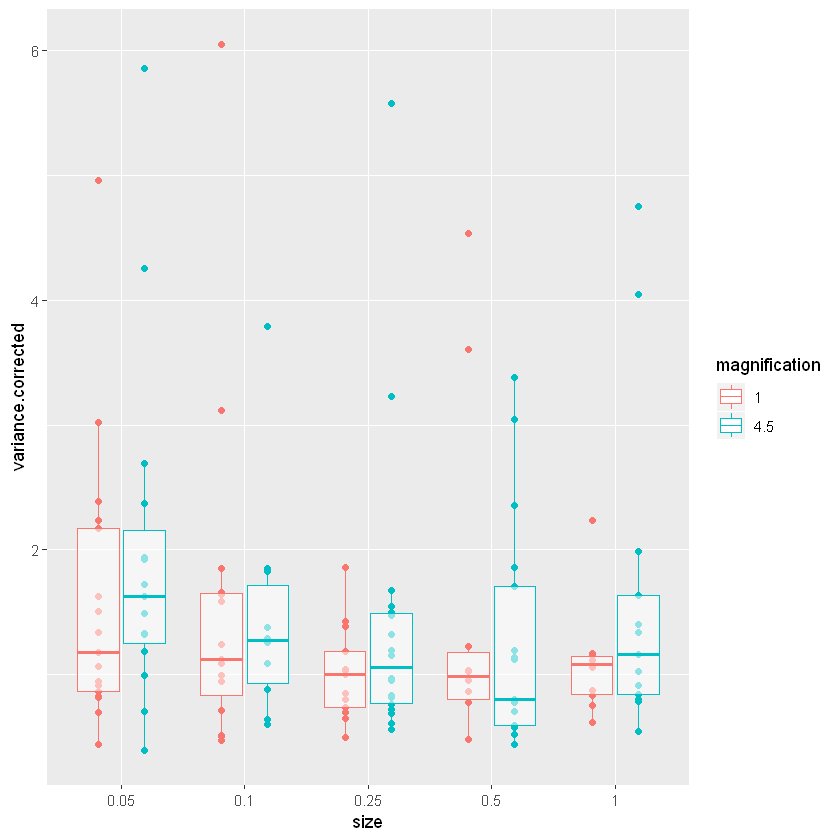

In [304]:
bl.cc.local <- subset(bl.data, submat=='CC')
var.stats(bl.cc.local,bl=TRUE)
var.plot(bl.cc.local,'BL CC LOCAL',bl=TRUE)


Call:
lm(formula = variance.corrected ~ size + magnification + magnification * 
    size, data = wl.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1807 -0.6770 -0.3604  0.2564  4.3545 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.86782    0.18636  10.023   <2e-16 ***
size                  -0.58556    0.40884  -1.432    0.154    
magnification4.5      -0.10034    0.26807  -0.374    0.709    
size:magnification4.5  0.09258    0.55999   0.165    0.869    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.08 on 134 degrees of freedom
Multiple R-squared:  0.02912,	Adjusted R-squared:  0.007381 
F-statistic:  1.34 on 3 and 134 DF,  p-value: 0.2642



,2.5 %,97.5 %
(Intercept),1.4992324,2.2364010
size,-1.3941835,0.2230630
magnification4.5,-0.6305436,0.4298634
size:magnification4.5,-1.0149799,1.2001301


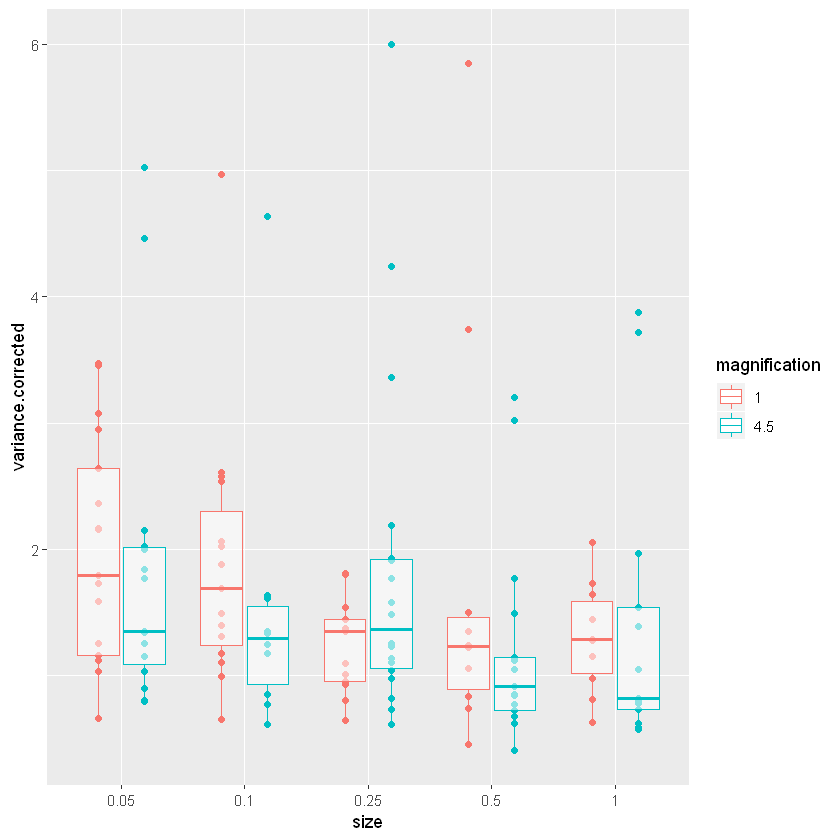

In [305]:
bl.pp.local <- subset(bl.data, submat=='PP')
var.stats(bl.pp.local,bl=TRUE)
var.plot(bl.pp.local,'BL PP LOCAL',bl=TRUE)


Call:
lm(formula = variance.corrected ~ size + magnification + magnification * 
    size, data = wl.data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.29209 -0.12183 -0.04422  0.06684  0.88957 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.476923   0.035759  13.337   <2e-16 ***
size                  -0.079888   0.078451  -1.018    0.310    
magnification4.5       0.004251   0.051439   0.083    0.934    
size:magnification4.5  0.006532   0.107453   0.061    0.952    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2072 on 134 degrees of freedom
Multiple R-squared:  0.01498,	Adjusted R-squared:  -0.007077 
F-statistic: 0.6791 on 3 and 134 DF,  p-value: 0.5663



,2.5 %,97.5 %
(Intercept),0.40619678,0.54764859
size,-0.23505045,0.07527535
magnification4.5,-0.09748729,0.10598922
size:magnification4.5,-0.20599183,0.21905519


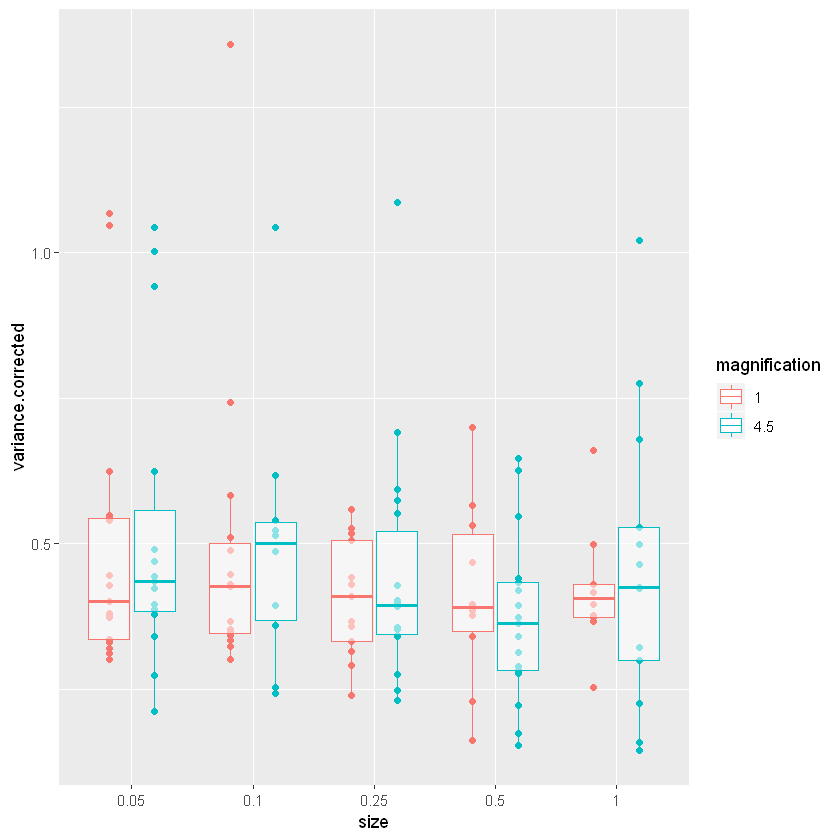

In [320]:
bl.cc.int <- subset(bl.int.data, submat=='CC')
var.stats(bl.cc.int,bl=TRUE)
var.plot(bl.cc.int,'BL CC INT',bl=TRUE)



Call:
lm(formula = variance.corrected ~ size + magnification + magnification * 
    size, data = wl.data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30986 -0.13423 -0.04672  0.08338  0.81850 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.62820    0.03672  17.108  < 2e-16 ***
size                  -0.27923    0.08056  -3.466  0.00071 ***
magnification4.5      -0.14744    0.05282  -2.791  0.00602 ** 
size:magnification4.5  0.19574    0.11034   1.774  0.07833 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2128 on 134 degrees of freedom
Multiple R-squared:  0.127,	Adjusted R-squared:  0.1074 
F-statistic: 6.495 on 3 and 134 DF,  p-value: 0.0003887



,2.5 %,97.5 %
(Intercept),0.55557298,0.70082248
size,-0.43855922,-0.11990179
magnification4.5,-0.25190858,-0.04296914
size:magnification4.5,-0.02248751,0.41397117


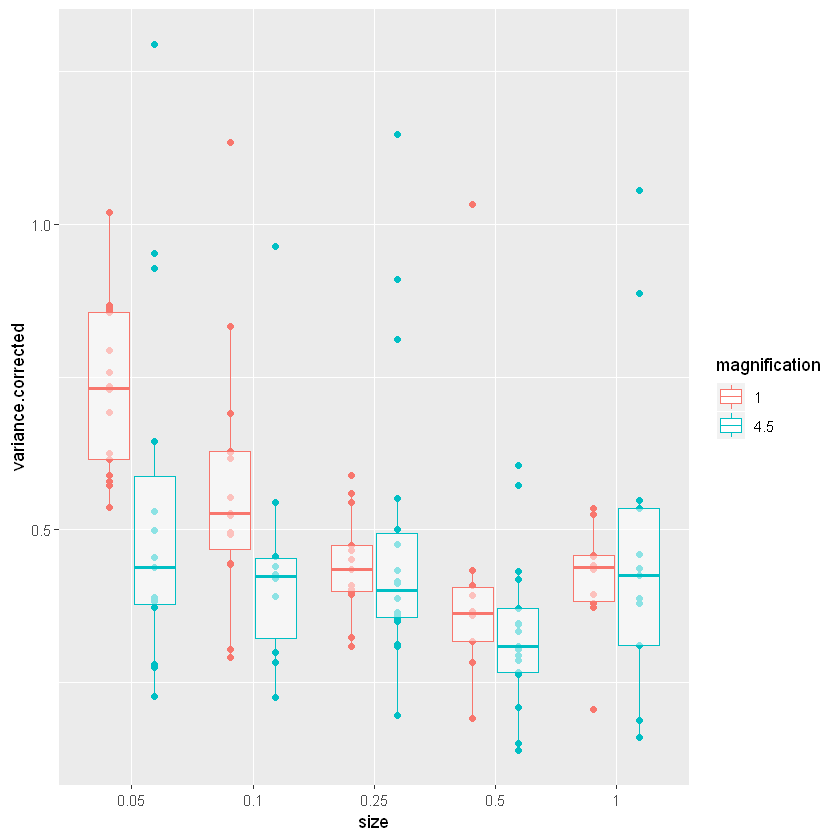

In [321]:
bl.pp.int <- subset(bl.int.data, submat=='PP')
var.stats(bl.pp.int,bl=TRUE)
var.plot(bl.pp.int,'BL PP INT',bl=TRUE)

## Tabulation & Plotting Across Conditions

Two parameters we're interested in - (1) stimulus size and (2) cortical magnification. Want to tabulate how various outcome measures change as these parameters change

### Within-subject correlations for each condition

In [286]:
# first, let's grab the data from compliant participants
cleandf <- subset(datadf, noncompliant == 0)
get_n(cleandf)

[1] "There are 138 unique subjects"


[1] 138

In [201]:
# function to print the mean within-subject correlation for each condition, returns a dataframe to plot them
within_correlations_conditions <- function(cleandf,e1='FF',e2='PP',get.correlations=TRUE,compare=TRUE,test=FALSE){
    
    magnification_list <- sort(unique(cleandf$peripheral_scale))
    stim_sizes <- sort(unique(cleandf$stimulus_radius))
    
    return_df <- data.frame() # initialisation
    
    for(scale in magnification_list){
        temp_scale_df <- subset(cleandf, peripheral_scale == scale)
        for(stim_size in stim_sizes){
            tempdf <- subset(temp_scale_df, stimulus_radius == stim_size)
            
            # mark where we are
            print(paste("Magnification",scale,"Stimulus Radius",stim_size))
            get_n(tempdf) # print n values
            print(paste("Median Trace:",round(median(group_trace(tempdf)),2)))
            print(paste("Median Antitrace:",round(median(group_trace(tempdf,mode='antitrace')),2)))
            
            # do all the comparisons, add to a dataframe to return for plotting
            if(compare){
                subject.data <- within_full_compare(tempdf)
                subject.data$magnification <- as.character(scale)
                subject.data$stimulus_radius <- as.character(stim_size)
                return_df <- rbind(return_df,subject.data)
            }
            
            # check if they're significantly different from shuffled data
            if(test){
                correlations <- eccentricity_compare_list(tempdf, e1, e2)
                
                print("Shuffle comparison:")
                within_shuffled <- eccentricity_compare_shuffled_list(tempdf,mode='shuffle') 
                print(QDM_test(correlations,within_shuffled))
                print("Random swap comparison:")
                within_swapped <- eccentricity_compare_shuffled_list(tempdf,mode='swap') 
                print(QDM_test(correlations,within_swapped))
                print("Inverted comparison:")
                within_swapped <- eccentricity_compare_shuffled_list(tempdf,mode='invert') 
                print(QDM_test(correlations,within_swapped))
                print("Rotated (90) comparison:")
                within_swapped <- eccentricity_compare_shuffled_list(tempdf,mode='rotate') 
                print(QDM_test(correlations,within_swapped))
            }
            print("")
        }
    }
    return(return_df)
}

In [202]:
within_distribution_df <- within_correlations_conditions(cleandf)

[1] "Magnification 1 Stimulus Radius 0.05"
[1] "There are 17 unique subjects"
[1] "Median Trace: 2.33"
[1] "Median Antitrace: 3.94"
[1] "Standard comparisons"
[1] "FF vs PP:  0.37  -  FF vs FP:  0.51  -  FP vs PP:  0.42"
[1] "Swapped comparisons - PP swapped - random"
[1] "FF vs PP:  0.18  -  FF vs FP:  0.01  -  FP vs PP:  0.08"
[1] "Swapped comparisons - PP swapped - invert"
[1] "FF vs PP:  0.23  -  FF vs FP:  -0.15  -  FP vs PP:  -0.11"
[1] "Swapped comparisons - PP swapped - rotate"
[1] "FF vs PP:  0.19  -  FF vs FP:  0.06  -  FP vs PP:  0.1"
[1] ""
[1] "Magnification 1 Stimulus Radius 0.1"
[1] "There are 15 unique subjects"
[1] "Median Trace: 1.11"
[1] "Median Antitrace: 4.89"
[1] "Standard comparisons"
[1] "FF vs PP:  0.59  -  FF vs FP:  0.68  -  FP vs PP:  0.61"
[1] "Swapped comparisons - PP swapped - random"
[1] "FF vs PP:  0.32  -  FF vs FP:  0.09  -  FP vs PP:  0.08"
[1] "Swapped comparisons - PP swapped - invert"
[1] "FF vs PP:  0.56  -  FF vs FP:  0  -  FP vs PP:  -0.03"
[1]

In [203]:
# save the within-subject correlation distributions for future reference & avoiding preprocessing again
within_distribution_identity <- subset(within_distribution_df, mode == 'identity')
save(within_distribution_identity,file="within_global.Rda")

In [208]:
# reminder of what we have
#within_distribution_identity$stimulus_radius <- as.numeric(within_distribution_identity$stimulus_radius)
head(within_distribution_identity,2)
class(within_distribution_identity$stimulus_radius)

ID,mode,FFvPP,FFvFP,FPvPP,magnification,stimulus_radius
11005010,identity,0.5805429,0.8355364,0.9042033,1,0.05
64413254,identity,0.5404108,1.0700658,0.6251156,1,0.05


[1] "character"

In [216]:
# make sure things are numeric that should be
within_distribution_identity$stimulus_radius <- as.numeric(within_distribution_identity$stimulus_radius)
within_distribution_identity$magnification <- as.character(within_distribution_identity$magnification)
within_distribution_identity$FFvPP <- as.numeric(within_distribution_identity$FFvPP)

# do the actual modelling on the correlational data
global.fit <- lm(formula = FFvPP ~ stimulus_radius + magnification + magnification*stimulus_radius, data = within_distribution_identity)
summary(global.fit)
confint(global.fit,level=0.95)

# test not including size
size.fit <- lm(formula = FFvPP ~ magnification + magnification*stimulus_radius, data = within_distribution_identity)
summary(size.fit)
confint(size.fit,level=0.95)


Call:
lm(formula = FFvPP ~ stimulus_radius + magnification + magnification * 
    stimulus_radius, data = within_distribution_identity)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22104 -0.30975  0.05356  0.37964  0.96446 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.62229    0.08897   6.994 1.15e-10 ***
stimulus_radius                   0.77535    0.19520   3.972 0.000116 ***
magnification4.5                  0.40004    0.12799   3.126 0.002176 ** 
stimulus_radius:magnification4.5 -0.61228    0.26736  -2.290 0.023576 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5156 on 134 degrees of freedom
Multiple R-squared:  0.1445,	Adjusted R-squared:  0.1253 
F-statistic: 7.542 on 3 and 134 DF,  p-value: 0.0001061


,2.5 %,97.5 %
(Intercept),0.4463162,0.79826659
stimulus_radius,0.3892856,1.16141626
magnification4.5,0.1468984,0.65317420
stimulus_radius:magnification4.5,-1.1410673,-0.08349548



Call:
lm(formula = FFvPP ~ magnification + magnification * stimulus_radius, 
    data = within_distribution_identity)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22104 -0.30975  0.05356  0.37964  0.96446 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.62229    0.08897   6.994 1.15e-10 ***
magnification4.5                  0.40004    0.12799   3.126 0.002176 ** 
stimulus_radius                   0.77535    0.19520   3.972 0.000116 ***
magnification4.5:stimulus_radius -0.61228    0.26736  -2.290 0.023576 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5156 on 134 degrees of freedom
Multiple R-squared:  0.1445,	Adjusted R-squared:  0.1253 
F-statistic: 7.542 on 3 and 134 DF,  p-value: 0.0001061


,2.5 %,97.5 %
(Intercept),0.4463162,0.79826659
magnification4.5,0.1468984,0.65317420
stimulus_radius,0.3892856,1.16141626
magnification4.5:stimulus_radius,-1.1410673,-0.08349548


In [321]:
# make a plot of all the within-subject correlation distributions across eccentricity & magnification
distribution.plots <- function(distributions,swaps=TRUE,transform=FALSE){
    
    # fisher transform control
    if(transform){
        transform.string <- "_transformed"
    } else {
        transform.string <- ""
    }
    
    # plot swaps control
    if(!swaps){
        distributions <- subset(distributions, mode=="identity")
        swaps.string <- ""
    } else {
        swaps.string <- "_swapped"
    }
    
    
    fixed.df <- subset(distributions, magnification == 1)
    magnified.df <- subset(distributions, magnification != 1)
    
    fixed.FFvPP.plot <- r_distribution_plot(fixed.df, comparison='FFvPP',fisher=transform,swaps=swaps)
    fixed.FFvFP.plot <- r_distribution_plot(fixed.df, comparison='FFvFP',fisher=transform,swaps=swaps)
    fixed.FPvPP.plot <- r_distribution_plot(fixed.df, comparison='FPvPP',fisher=transform,swaps=swaps)
    magnified.FFvPP.plot <- r_distribution_plot(magnified.df, comparison='FFvPP',fisher=transform,swaps=swaps)
    magnified.FFvFP.plot <- r_distribution_plot(magnified.df, comparison='FFvFP',fisher=transform,swaps=swaps)
    magnified.FPvPP.plot <- r_distribution_plot(magnified.df, comparison='FPvPP',fisher=transform,swaps=swaps)
    
    title <- textGrob("Peripheral Swap", gp=gpar(fontsize=35))
    
    allgrob <- arrangeGrob(fixed.FFvPP.plot, fixed.FFvFP.plot, fixed.FPvPP.plot,
                          magnified.FFvPP.plot, magnified.FFvFP.plot, magnified.FPvPP.plot,
                          nrow = 2, ncol = 3, top = title)
    ggsave(paste(savestr,"_Overall_Summary_Plots/Correlation_Distributions_",
                 swaps.string,transform.string,"_plot.png",sep=""),
          allgrob, height = 20, width = 30)
    
}

In [322]:
#distribution.plots(within_distribution_df,transform=FALSE)
#distribution.plots(within_distribution_df,transform=TRUE)
distribution.plots(within_distribution_df,swaps=FALSE,transform=FALSE)
#distribution.plots(within_distribution_df,swaps=TRUE,transform=FALSE)

In [320]:
#head(within_distribution_df,3)

ID,mode,FFvPP,FFvFP,FPvPP,magnification,stimulus_radius
11005010,identity,0.5805429,0.8355364,0.9042033,1,0.05
64413254,identity,0.5404108,1.0700658,0.6251156,1,0.05
294207097,identity,0.4213636,0.5965211,0.6301706,1,0.05


In [319]:
# make some specific plots for the presentation
# probably just better to modify the code above to generate these on demand...
r_distribution_plot(within_distribution_df,comparison='FFvPP',title=FALSE,fisher=FALSE,scaling=FALSE,swaps=TRUE,connected=TRUE)
#r_distribution_plot(within_distribution_df,comparison='all',title=FALSE,fisher=FALSE,scaling=FALSE,swaps=FALSE)


ERROR: Error in subset.default(datadf, magnification != 1): object 'magnification' not found


In [ ]:
eccentricity.test <- function(datadf,scaled=TRUE){
    if(scaled){
        datadf <- subset(datadf, magnification != 1) # only use the scaled data
    }
    datadf <- subset(datadf, mode == 'identity') # get rid of simulation stuff
    datadf <- datadf %>% gather(comparison, correlations, 3:5) # gather up the comparisons across eccentricities
    test <- aov(correlations ~ comparison, data=datadf)
    n <- length(unique(datadf$ID))
    print(paste("Number of subjects:",n))
    print(summary(test))
}

In [ ]:
eccentricity.test(within_distribution_df)

In [ ]:
scaling.test <- function(datadf){
    datadf <- subset(datadf, mode == 'identity') # get rid of simulation stuff
    test <- aov(FFvPP ~ magnification + stimulus_radius + magnification*stimulus_radius, data = datadf)
    print(summary(test))
}


In [ ]:
scaling.test(within_distribution_df)

In [ ]:
# stat tests on this
within_distribution_tests <- function(datadf, method="non-para"){
    
    datadf <- subset(datadf, magnification != 1) # only use the scaled data
    n <- length(unique(datadf$ID))
    print(paste("Number of subjects:",n))
    
    # setup
    identity <- subset(datadf, mode == "identity")
    identity.FFvPP <- identity$FFvPP
    random <- subset(datadf, mode == "random")
    random.FFvPP <- random$FFvPP
    invert <- subset(datadf, mode == "invert")
    invert.FFvPP <- invert$FFvPP
    rotate <- subset(datadf, mode == "rotate")
    rotate.FFvPP <- rotate$FFvPP
    
    # do the tests
    if(method=='non-para'){
        random.test <- wilcox.test(identity.FFvPP, random.FFvPP, paired = TRUE, alternative = "two.sided")
        invert.test <- wilcox.test(identity.FFvPP, invert.FFvPP, paired = TRUE, alternative = "two.sided")
        rotate.test <- wilcox.test(identity.FFvPP, rotate.FFvPP, paired = TRUE, alternative = "two.sided")
    } else if(method=='para') {
        random.test <- t.test(identity.FFvPP, random.FFvPP, paired = TRUE, alternative = "two.sided")
        invert.test <- t.test(identity.FFvPP, invert.FFvPP, paired = TRUE, alternative = "two.sided")
        rotate.test <- t.test(identity.FFvPP, rotate.FFvPP, paired = TRUE, alternative = "two.sided")
    }
    
    
    # print the tests
    print(random.test)
    print(invert.test)
    print(rotate.test)
    
    #print bonferroni-corrected p-values
    values <- c(random.test$p.value, invert.test$p.value, rotate.test$p.value)
    print("Bonferroni-corrected p-values:")
    print(p.adjust(values, "bonferroni"))
    
}

In [ ]:
#r_distribution_plot(within_distribution_df,comparison='FFvPP',title=FALSE,fisher=TRUE,scaling=FALSE,swaps=TRUE)

within_distribution_tests(within_distribution_df)
within_distribution_tests(within_distribution_df,method='para')

In [ ]:
# make a plot of all the full dissimilarity matrices for each subject
dissimplots.subjects <- function(datadf,dependent='dissimilarity'){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    scale.list <- sort(unique(datadf$peripheral_scale))
    stim.list <- sort(unique(datadf$stimulus_radius))
    
    for(scale in scale.list){
        for(stim in stim.list){
            dir.create(paste(savestr,"_Subject_Plots/","Scale_",scale,"_StimSize_",stim,"/",dependent,"/",
                             sep='')) # make a new folder to store the subject plots in
        }
    }
    
    
    for(ID in subjectlist){
        subject.df <- subset(datadf, subject == ID)
        
        subject.plot.standard <- dissimplot.full(color.eccen.mat(dissimdata.subject(subject.df),mode='identity',dependent=dependent),dependent=dependent)
        subject.plot.standard <- subject.plot.standard + ggtitle('Standard') + theme(plot.title = element_text(hjust = 0.5))
        
        subject.plot.random <- dissimplot.full(color.eccen.mat(dissimdata.subject(subject.df),mode='random',dependent=dependent),dependent=dependent)
        subject.plot.random <- subject.plot.random + ggtitle('Random') + theme(plot.title = element_text(hjust = 0.5))
        
        subject.plot.invert <- dissimplot.full(color.eccen.mat(dissimdata.subject(subject.df),mode='invert',dependent=dependent),dependent=dependent)
        subject.plot.invert <- subject.plot.invert + ggtitle('Inverted') + theme(plot.title = element_text(hjust = 0.5))
        
        subject.plot.rotate <- dissimplot.full(color.eccen.mat(dissimdata.subject(subject.df),mode='rotate',dependent=dependent),dependent=dependent)
        subject.plot.rotate <- subject.plot.rotate + ggtitle('Rotated (90)') + theme(plot.title = element_text(hjust = 0.5))
        
        scale <- subject.df$peripheral_scale[1]
        stim.size <- subject.df$stimulus_radius[1]
        title <- textGrob(paste(as.character(ID),"-",
                                "Magnification:", scale,
                                "Stimulus Size:", stim.size
                                ),
                                gp=gpar(fontsize=35))
        
        g <- arrangeGrob(subject.plot.standard, subject.plot.random,
                        subject.plot.invert, subject.plot.rotate,
                        nrow = 2, ncol=2, top = title)
        
        ggsave(paste(savestr,"_Subject_Plots/","Scale_",scale,"_StimSize_",stim.size,"/",dependent,"/",
                     dependent,"_matrix","_ID_",ID,"_",
                     scale,"_",stim.size,
                     "_plot.png",
                     sep=''),g, height = 20, width = 20)
    }
}

In [ ]:
# make a plot of all the dissimilarity & RT matrices


In [ ]:
# make a plot of all the dissimilarity & RT matrices for each subject
QDM.subjects <- function(datadf,RT=TRUE){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    scale.list <- sort(unique(datadf$peripheral_scale))
    stim.list <- sort(unique(datadf$stimulus_radius))
    
    for(scale in scale.list){
        for(stim in stim.list){
            dir.create(paste(savestr,"_Subject_Plots/","Scale_",scale,"_StimSize_",stim,"/",
                             sep='')) # make a new folder to store the subject plots in
        }
    }
    
    
    for(ID in subjectlist){
        subject.df <- subset(datadf, subject == ID)
        
        subject.plot.QDM <- dissimplot.full(color.eccen.mat(dissimdata.subject(subject.df),mode='identity',dependent='dissimilarity'),dependent='dissimilarity')
        subject.plot.QDM <- subject.plot.QDM + ggtitle('Dissimilarity') + theme(plot.title = element_text(hjust = 0.5))
        
        if(RT){
            subject.plot.RT <- dissimplot.full(color.eccen.mat(dissimdata.subject(subject.df),mode='identity',dependent='RT'),dependent='RT')
            subject.plot.RT <- subject.plot.RT + ggtitle('Reaction Time') + theme(plot.title = element_text(hjust = 0.5))
        }
        
        
        #calculate FFvPP Correlation
        matrix1 <- halfmat.v(df2mat.full(subject.df, l2e('Foveal'), l2e('Foveal')))
        matrix2 <- halfmat.v(df2mat.full(subject.df, l2e('Peripheral'), l2e('Peripheral')))
        r <- cor(matrix1, matrix2, method = "spearman")
        
        
        scale <- subject.df$peripheral_scale[1]
        stim.size <- subject.df$stimulus_radius[1]
        title <- textGrob(paste(as.character(ID),"-",
                                "r =",round(r,2),
                                "Magnification:", scale,
                                "Stimulus Size:", stim.size
                                ),
                                gp=gpar(fontsize=35))
        
        if(RT){
            g <- arrangeGrob(subject.plot.QDM, subject.plot.RT,
                        nrow = 2, ncol=1, top = title)
        
            ggsave(paste(savestr,"_Subject_Plots/","Scale_",scale,"_StimSize_",stim.size,"/",
                         "QDM_RT_matrix","_ID_",ID,"_",
                         scale,"_",stim.size,
                         "_plot.png",
                         sep=''),g, height = 20, width = 11.25)
        } else {
            g <- arrangeGrob(subject.plot.QDM,
                        nrow = 1, ncol=1, top = title)
        
            ggsave(paste(savestr,"_Subject_Plots/","Scale_",scale,"_StimSize_",stim.size,"/",
                         "QDM_RT_matrix","_ID_",ID,"_",
                         scale,"_",stim.size,
                         "_plot.png",
                         sep=''),g, height = 13, width = 11.25)
        }
        
    }
}

In [ ]:
QDM.RT.subjects(cleandf, RT = FALSE)
#dissimplots.subjects(cleandf,dependent='RT')
#rsplot_summary(cleandf)
# Make summary QDMs for each population group
#dissimplot.full(color.eccen.mat(dissimdata.subject(cleandf),mode='identity',dependent='RT'),dependent='RT')

In [158]:
# generate the summary QDMs & RTMs for each group
QDM.RT.grouped <- function(datadf,RT=FALSE){
    
    scale.list <- sort(unique(datadf$peripheral_scale))
    stim.list <- sort(unique(datadf$stimulus_radius))
    
    for(scale in scale.list){
        for(stim in stim.list){
            dir.create(paste(savestr,"_Overall_Summary_Plots/QDM_RTMs/",
                             sep='')) # make a new folder to store the summary plots in
            
            tempdf <- subset(datadf, peripheral_scale == scale & stimulus_radius == stim) # select the dataset
            
            group.plot.QDM <- dissimplot.full(color.eccen.mat(dissimdata.subject(tempdf),mode='identity',dependent='dissimilarity'),dependent='dissimilarity')
            group.plot.QDM <- group.plot.QDM + ggtitle('Dissimilarity') + theme(plot.title = element_text(hjust = 0.5))
            
            group.plot.var <- variance.plot(dissimvar.between(tempdf))
            group.plot.var <- group.plot.var + ggtitle('Dissimilarity Variance') + theme(plot.title = element_text(hjust = 0.5))

            if(RT){
                group.plot.RT <- dissimplot.full(color.eccen.mat(dissimdata.subject(tempdf),mode='identity',dependent='RT'),dependent='RT')
                group.plot.RT <- group.plot.RT + ggtitle('Reaction Time') + theme(plot.title = element_text(hjust = 0.5))
            }
            
            
            title <- textGrob(paste("Group Mean -",
                                "Magnification:", scale,
                                "Stimulus Size:", stim
                                ),
                                gp=gpar(fontsize=35))
        
            if(RT){
                g <- arrangeGrob(group.plot.QDM, group.plot.RT,
                                nrow = 2, ncol=1, top = title)

                ggsave(paste(savestr,"_Overall_Summary_Plots/QDM_RTMs/",
                         "QDM_RT_matrix - Scale ",
                         scale," - Stim Size ",stim,
                         " - plot.png",
                         sep=''),g, height = 20, width = 11.25)
                } else {
                    g <- arrangeGrob(group.plot.QDM, group.plot.var,
                                nrow = 2, ncol=1, top = title)

                ggsave(paste(savestr,"_Overall_Summary_Plots/QDM_RTMs/",
                         "QDM_RT_matrix - Scale ",
                         scale," - Stim Size ",stim,
                         " - plot.png",
                         sep=''),g, height = 20, width = 11.25)
            }
        }
    }
    
}

In [159]:
cleandf <- invert.subjects(cleandf)
QDM.RT.grouped(cleandf,RT=FALSE)

In [ ]:
# function to print the mean between-subject correlation for each condition, returns a dataframe to plot them
between_correlations_conditions <- function(cleandf,e1='Foveal',e2='Foveal',test=TRUE){
    
    e1=l2e(e1)
    e2=l2e(e2)
    
    magnification_list <- sort(unique(cleandf$peripheral_scale))
    stim_sizes <- sort(unique(cleandf$stimulus_radius))
    
    return_df <- data.frame() # initialisation
    
    for(scale in magnification_list){
        temp_scale_df <- subset(cleandf, peripheral_scale == scale)
        for(stim_size in stim_sizes){
            tempdf <- subset(temp_scale_df, stimulus_radius == stim_size)
            
            # get the correlations of interest
            correlations <- i_j_list(tempdf, e1, e2)
            print(paste("Magnification",scale,"Stimulus Radius",stim_size,
                        ": mean r = ",average_correlation(correlations)))
            
            # add the correlations to a dataframe for plotting
            correlation_df <- data.frame(correlations, 
                                         magnification = as.character(scale), stimulus_radius = as.character(stim_size))
            return_df <- rbind(return_df,correlation_df)
            
            # check if they're significantly different from shuffled data
            
        }
    }
    return(return_df)
}

In [ ]:
between_distribution_df <- between_correlations_conditions(cleandf)

In [ ]:
# test within-vs-between distributions
within_vs_between <- function(cleandf){
    
    magnification_list <- sort(unique(cleandf$peripheral_scale))
    stim_sizes <- sort(unique(cleandf$stimulus_radius))
    
    return_df <- data.frame() # initialisation
    
    for(scale in magnification_list){
        temp_scale_df <- subset(cleandf, peripheral_scale == scale)
        for(stim_size in stim_sizes){
            tempdf <- subset(temp_scale_df, stimulus_radius == stim_size)
            
            within_correlations <- eccentricity_compare_list(tempdf, 'Foveal', 'Peripheral')
            between_correlations <- i_j_list(tempdf, l2e('Foveal'), l2e('Foveal'))
            
            print(paste("Magnification",scale,"Stimulus Radius",stim_size))
            print(paste("Mean fovea-periphery correlation:",average_correlation(within_correlations)))
            print(paste("Mean between-subject fovea-fovea correlation:",average_correlation(between_correlations)))

            print(QDM_test(within_correlations,between_correlations))
            print("")
        }
    }        
}

In [ ]:
within_vs_between(cleandf)

#### Triangle Inequality Calculations

In [ ]:
# test the violation proportions for a subject's judgments
test.tri.subject <- function(matrix,print=FALSE){
    CCmat <- matrix[1:9,1:9]
    CPmat <- matrix[1:9,10:18]
    PPmat <- matrix[10:18,10:18]
    
    CC.score <- score.tri.violate(CCmat)
    CP.score <- score.tri.violate(CPmat)
    PP.score <- score.tri.violate(PPmat)
    FULL.score <- score.tri.violate(matrix)
    
    if(print){
        print("Triangle Inequality Violations:")
        print(paste("CC:",round(CC.score,5),"CP:",round(CP.score,5),"PP:",round(PP.score,5),"Full:",round(FULL.score,5)))
    }
    return(c(CC.score,CP.score,PP.score,FULL.score))
}

In [ ]:
test.tri.subject(testmat)

In [ ]:
# test unsymmeterised PC/CP data
test.tri.unsymmeterised <- function(matrix,print=FALSE){
    CPmat <- matrix[1:9,10:18]
    PCmat <- t(CPmat)
    
    CP.score <- score.tri.violate(CPmat)
    PC.score <- score.tri.violate(PCmat)
    
    if(print){
        print("Triangle Inequality Violations - Unsymmeterised:")
        print(paste("CP:",round(CP.score,5),"PC:",round(PC.score,5)))
    }
    return(c(CP.score,PC.score))
}

In [ ]:
#testdf <- subset(datadf, subject == 790529144)
#testdata <- dissimdata.subject(testdf,symmeterise=FALSE, duplicate=FALSE)
#testmat <- color.eccen.mat(testdata,output='matrix')
#test.tri.unsymmeterised(testmat,print=TRUE)

In [ ]:
# test a population of subjects
test.tri.population <- function(datadf,sym=TRUE){
    
    # initialise score storage dataframe
    score.df <- data.frame()
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    for(ID in subjectlist){
        subject.df <- subset(datadf, subject == ID)
        if(sym){
            subjectdata <- dissimdata.subject(subject.df)
        } else {
            subjectdata <- dissimdata.subject(subject.df,symmeterise=FALSE, duplicate=FALSE)
        }
        subject.mat <- color.eccen.mat(subjectdata,output='matrix')
        if(sym){
            scores <- test.tri.subject(subject.mat)
        } else {
            scores <- test.tri.unsymmeterised(subject.mat)
        }
        row <- c(ID,scores)
        score.df <- rbind(score.df, row)
    }
    if(sym){
        colnames(score.df) <- c("ID", "CC", "CP", "PP", "FULL")
    } else {
        colnames(score.df) <- c("ID", "CP", "PC")
    }
    
    return(score.df)
}

In [ ]:
#testdf <- subset(cleandf, peripheral_scale == 4.5 & stimulus_radius == 1)
#test.tri.population(testdf,sym=FALSE)

In [ ]:
# test all the subjects in a dataset, stratifying by magnification & stimulus
test.tri.all <- function(datadf,test='mean',sym=TRUE){
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_radius))
    output.df <- data.frame()
    
    print("Testing Triangle Inequality Violations")
    print(paste("Reporting",test,"values"))
    for (stimulus in size_list){
        for (scale in magnification_list){
            tempdf <- subset(datadf, peripheral_scale == scale & stimulus_radius == stimulus)
            
            print(paste("Magnification",scale,"Stimulus",stimulus))
            
            score.df <- test.tri.population(tempdf,sym=sym)
            if(sym==TRUE){
                 if(test=='mean'){
                CC.score <- mean(score.df$CC)
                CP.score <- mean(score.df$CP)
                PP.score <- mean(score.df$PP)
                FULL.score <- mean(score.df$FULL)
                } else if (test=='median'){
                CC.score <- median(score.df$CC)
                CP.score <- median(score.df$CP)
                PP.score <- median(score.df$PP)
                FULL.score <- mean(score.df$FULL)
                }
                print(paste("CC:",round(CC.score,5),"CP:",round(CP.score,5),"PP:",round(PP.score,5),"Full:",round(FULL.score,5)))
                row <- c(scale,stimulus,CC.score,CP.score,PP.score,FULL.score)
                output.df <- rbind(output.df,row)
            }else{
                if(test=='mean'){
                CP.score <- mean(score.df$CP)
                PC.score <- mean(score.df$PC)
                } else if (test=='median'){
                CP.score <- median(score.df$CP)
                PC.score <- median(score.df$PC)
                }
                print(paste("CP:",round(CP.score,5),"PC:",round(PC.score,5)))
            }
           
        }
    }
    colnames(output.df) <- c('magnification','stimulus','CC','CP','PP','Full')
    return(output.df)
}

In [ ]:
# plot triangle inequality violations
tri.violate.plot <- function(output.df,title){
    plot.df <- output.df %>% gather(matrix, tri.violate, 3:6)
    plot.df$stimulus <- as.character(plot.df$stimulus)
    plot.df$matrix <- factor(plot.df$matrix, levels = c('CC','CP','PP','Full'))
    #print(plot.df)
    plot <- ggplot(plot.df, aes(x=stimulus,y=tri.violate,fill=matrix,group=matrix)) + 
    geom_bar(stat='identity',position=position_dodge()) + ggtitle(title) +
    ylim(0,1) + xlab('Stimulus Radius (DVA)') + ylab('Violation Proportion')
    return(plot)
}

In [ ]:
# summary triangle inequality plot across magnifications
tri.violate.plot.mag <- function(output.df){
    fixed.df <- subset(output.df, magnification == 1)
    scaled.df <- subset(output.df, magnification > 1)
    plot.fixed <- tri.violate.plot(fixed.df,'Fixed')
    plot.scaled <- tri.violate.plot(scaled.df,'Scaled')
    g <- arrangeGrob(plot.fixed,plot.scaled, nrow=1,ncol=2)
    return(g)
}

In [ ]:
#tri.violate.plot(output.df)
testgrob <- tri.violate.plot.mag(output.df)
grid.arrange(testgrob)

In [ ]:
test.tri.all(cleandf,test='median',sym=FALSE)

In [ ]:
output.df <- test.tri.all(cleandf,test='median')

In [ ]:
output.df

In [ ]:
test.tri.all(cleandf,test='mean')

In [ ]:
#test <- test.tri.all(testdf)
#test
#median(test$ID)
#median(test$CC)
#median(test$CP)
#median(test$PP)
1/253

### Between-Subjects Explorations

##### Between-subject variance

In [ ]:
testdf <- subset(cleandf, stimulus_radius==1 & peripheral_scale==1)
testplot <- dissimplot.full(color.eccen.mat(dissimdata.subject(testdf,
                                                        duplicate=FALSE,symmeterise=FALSE)))

## Plot Stuff

### Plot summary of all subjects

#### Individual subjects

In [ ]:
# plot summary data for all the subjects individually
allsubjectsplot <- function(datadf,savestr){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects

    dir.create(paste(savestr,"Subject_Plots",sep='_')) # make a new folder to store the subject plots in

    for (subjectid in subjectlist){
        print(paste("Processing subject:",subjectid,sep=' '))
        subjectplot(datadf, subjectid,savestr)
    }
}

In [ ]:
# make a plot of the key summary data for a subject - single trial type version
subjectplot <- function(datadf, subjectid,savestr){
    
    datadf = subset(datadf, subject == subjectid) # select the ID for subject of interest
    for (trial_condition in trial_types){
            subjectdf = subset(datadf, trial_type == trial_condition) # just pick one trial type at a time
    
    
        if(subjectdf$trial_type[1] != 'after_1'){
            FP = TRUE
        } else {
            FP = FALSE
        }

        # FF Matrix plot
        FFmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Foveal'), l2e('Foveal')),colors)



        # PP Matrix plot
        PPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

        # FF CMDS plot
        FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                            abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))



        # PP CMDS plot
        PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

        # FF nMDS plot
        FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                            abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))



        # PP nMDS plot
        PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

        # Similarity judgements
        simplot <- simhistplot(subjectdf)
        # Reaction times
        reactionplot <- rsplot(subjectdf)
        # summary plot
        rainplot <- rsplot_raincloud(subjectdf,'log')

        # trace plots
        traceplot <- trace_plot(subjectdf)
        antiplot <- trace_plot(subjectdf,'antitrace')
        differenceplot <- trace_plot(subjectdf,'difference')

        # asymmetry plot
        asymplot <- asymmetry_plot(subjectdf,l2e('Foveal'),l2e('Foveal'),colors)

        # title
        if(subjectdf$noncompliant[1]){
            title <- textGrob(paste("ID:",as.character(subjectid),"|","Catch Score:",catch_score(datadf),
                              "Screen size:",round(screen_size(subjectdf)/10,1),"cm",
                              "Viewing distance:",round(view_distance(subjectdf)/10,1),"cm"),
                              gp=gpar(col="red",fontsize=35))
        } else {
            title <- textGrob(paste("ID:",as.character(subjectid),"|","Catch Score:",catch_score(datadf),
                              "Screen size:",round(screen_size(subjectdf)/10,1),"cm",
                              "Viewing distance:",round(view_distance(subjectdf)/10,1),"cm"),
                              gp=gpar(col="blue",fontsize=35))
        }
    
        if(FP){

            # FP Matrix plot
            FPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Foveal'), l2e('Peripheral')),colors)

            # FP CMDS plot
            FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # FP nMDS plot
            FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # put all the plots together
            g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, simplot,
                        FFcmds, FPcmds, PPcmds, reactionplot,
                        FFnmds, FPnmds, PPnmds, rainplot,
                        traceplot, antiplot, differenceplot, 
                        nrow = 4, ncol=4, top = title)

            exp_type <- trial_condition
            ggsave(paste(savestr,"_Subject_Plots/",exp_type,"_ID_",subjectid,"_plot.png",sep=''),
                     g, height = 40, width = 40)
        } else {
            # put all the plots together
            g <- arrangeGrob(FFmatrix, PPmatrix, simplot, traceplot,
                        FFcmds, PPcmds, reactionplot, antiplot,
                        FFnmds, PPnmds, rainplot, 
                        nrow = 3, ncol=4, top = title)

            exp_type <- trial_condition
            ggsave(paste(savestr,"_Subject_Plots/",exp_type,"_ID_",subjectid,"_plot.png",
                     sep=''),g, height = 30, width = 40)
        }
    }
}

In [ ]:
if(plotsubjects){
    allsubjectsplot(datadf,savestr)
}

#### New mixed trial type version analysis

In [ ]:
# matrix to define layout for the mixed trial type plot
mixed_hlay <- rbind (c(1,2,3,4,5,6),
                     c(7,8,9,10,11,12),
                     c(13,14,15,16,17,18))

In [ ]:
# names for the x axis
col_plot_list <- c('FF Matrix', 'FF nMDS', 'PP Matrix', 'PP nMDS', 'RT', 'Dissim Freq')

In [ ]:
# make a plot of the key summary data for a subject - mixed trial type version
subject_mixed_plot <- function(datadf,savestr){
    
    dir.create(paste(savestr,"Mixed_Trial_Type_Plots", sep='_'))
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    
    for (subjectid in subjectlist){ # do for each subject
        
        k = 0 # counter
        plot_list <- list() # list to store the plots in as we're making them
        subjectdf = subset(datadf, subject == subjectid) # select the ID for subject of interest

        for (trial_condition in trial_types){
            type_df = subset(subjectdf, trial_type == trial_condition) # just pick one trial type at a time
            
            # FF Matrix plot
            FFmatrix <- dissimplot(dissimdata(type_df, colors, l2e('Foveal'), l2e('Foveal')),colors)
            k = k + 1
            plot_list[[k]] <- as.grob(FFmatrix)
            
            # FF nMDS plot
            FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(type_df,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
            k = k + 1
            plot_list[[k]] <- as.grob(FFnmds)

            # PP Matrix plot
            PPmatrix <- dissimplot(dissimdata(type_df, colors, l2e('Peripheral'), l2e('Peripheral')),colors)
            k = k + 1
            plot_list[[k]] <- as.grob(PPmatrix)

            # PP nMDS plot
            PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(type_df,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
            k = k + 1
            plot_list[[k]] <- as.grob(PPnmds)

            # rt rain plot
            rainplot <- rsplot_raincloud(type_df)
            k = k + 1
            plot_list[[k]] <- as.grob(rainplot)
            # Similarity judgements
            simplot <- simhistplot(subjectdf)
            k = k + 1
            plot_list[[k]] <- as.grob(simplot)

        }

        # save the plots
        yaxis <- textGrob("Trial Type", gp=gpar(fontsize=30), rot=90)
        xaxis <- textGrob("", gp=gpar(fontsize=30))

        title <- textGrob(paste("ID:",subjectid,"|","Catch Score:",catch_score(subjectdf)),gp=gpar(fontsize=35))

        g <- arrangeGrob(grobs = plot_list, ncol = 6,nrow = 3,
                         layout_matrix = mixed_hlay)

        g_rowcol_names <- rbind(tableGrob(t(col_plot_list), theme = ttheme_minimal(), rows = ""),
                    cbind(tableGrob(trial_types, theme = ttheme_minimal()),
                          g, size = "last"), size = "last")


        g_titled <- arrangeGrob(g_rowcol_names, top = title, left = yaxis, bottom = xaxis)
        
        savename <- paste(savestr,"_Mixed_Trial_Type_Plots/",subjectid,"_plot.png",sep='')
        ggsave(savename,g_titled, height = 19, width = 39)
    }
}

In [ ]:
subject_mixed_plot(datadf,savestr)

### Summary plots

In [293]:
dir.create(paste(savestr,"Summary_Plots",sep='_'))

In [294]:
# matrix to use to define the plot layout, specified manually for now
hlay.m <- rbind (c(1,4,7,10),
               c(2,5,8,11)#,
               #c(3,6,9,12)
              )

hlay <- rbind(c(1,3,5,7,9),
             c(2,4,6,8,10))

In [295]:
# correlations summary plot
across_experiment_plot <- function(datadf,savestr,laymatrix,dependent,clean=FALSE,submat='CCvPP'){
    
    dir.create(paste(savestr,"Overall_Summary_Plots",sep='_'))
    submat.print <- FALSE
    
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_radius))
    
    plot_list <- list()
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    # make all the plots
    k = 0
    for (stimulus in size_list){
        for (scale in magnification_list){
            k = k + 1
            if(stimulus == 2){ # 2 stimuli doesn't have any cueing, so it gets an exception
                tempdf <- subset(datadf, stimulus_radius == 2)
            } else {
                tempdf <- subset(datadf, stimulus_radius == stimulus & peripheral_scale == scale)
            }
            
            # make the specific plot
            if(dependent=='correlation'){
                fvp <- fvp_list(tempdf)
                plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
                title <- textGrob("CORRELATION", gp=gpar(fontsize=35))
            } else if (dependent=='RT'){
                plot <- rsplot_summary(tempdf)
                title <- textGrob("REACTION TIME", gp=gpar(fontsize=35))
            } else if (dependent=='dissimilarity'){
                plot <- simhistplot_summary(tempdf)
                title <- textGrob("DISSIMILARITY", gp=gpar(fontsize=35))
            } else if (dependent=='trace'){
                plot <- trace_plot(tempdf)
                title <- textGrob("TRACE", gp=gpar(fontsize=35))
            } else if (dependent=='antitrace'){
                plot <- trace_plot(tempdf,'antitrace')
                title <- textGrob("ANTITRACE", gp=gpar(fontsize=35))
            } else if (dependent=='difference'){
                plot <- trace_plot(tempdf,'difference')
                title <- textGrob("ANTITRACE - TRACE", gp=gpar(fontsize=35))
            } else if (dependent=='asymmetry_matrix'){
                plot <- asymmetry_plot(tempdf,l2e('Foveal'),l2e('Foveal'),colors)
                title <- textGrob("SIMILARITY ASYMMETRY MATRIX", gp=gpar(fontsize=35))
            } else if (dependent == 'trace_by_trial'){
                plot <- trace_by_trial_plot(tempdf,'boxplot')
                title <- textGrob("Trace by Trial", gp=gpar(fontsize=35))
            } else if (dependent == 't'){
                plot <- t.plot(tempdf,submat=submat,title=paste('scale',scale,'size',stimulus))
                title <- textGrob(paste("t score -",submat), gp=gpar(fontsize=35))
                submat.print <- TRUE
            } else if (dependent == 'bayes'){
                plot <- ci.bayes.plot(tempdf,submat=submat,title=paste('scale',scale,'size',stimulus))
                title <- textGrob(paste("credible interval bounds -",submat), gp=gpar(fontsize=35))
                submat.print <- TRUE
            }  else if (dependent == 'permute'){
                plot <- permute.plot(tempdf,submat=submat,title=paste('scale',scale,'size',stimulus))
                title <- textGrob(paste("permute plot -",submat), gp=gpar(fontsize=35))
                submat.print <- TRUE
            } else if (dependent== 'bayes.rank'){
                plot <- ci.bayes.plot(tempdf,mats=TRUE,diff.mats=TRUE,submat=submat,title=paste('scale',scale,'size',stimulus))
                title <- textGrob(paste("credible interval bounds -",submat), gp=gpar(fontsize=35))
                submat.print <- TRUE
            }
            
            
            plot <- plot + xlab(paste(stimulus,scale,sep=' ')) #  add a label
            
            plot_list[[k]] <- as.grob(plot) # add it to the plot_list
        }
        
    }
    
    # save the plots
    yaxis <- textGrob("Magnification", gp=gpar(fontsize=30), rot=90)
    xaxis <- textGrob("Stimulus Radius (DVA)", gp=gpar(fontsize=30))
    
    g <- arrangeGrob(grobs = plot_list, ncol = length(magnification_list),nrow = length(size_list),
                     layout_matrix = hlay)
    
    g_rowcol_names <- rbind(tableGrob(t(size_list), theme = ttheme_minimal(), rows = ""),
                cbind(tableGrob(magnification_list, theme = ttheme_minimal()),
                      g, size = "last"), size = "last")
    
    g_titled <- arrangeGrob(g_rowcol_names, top = title, left = yaxis, bottom = xaxis)
    
    if(clean){
        if(submat.print){
            dependent <- paste(dependent,submat,sep='_')
        }
        savename <- paste(savestr,"_Overall_Summary_Plots/",dependent,"_CLEAN","_plot.png",sep='')
        ggsave(savename,g_titled, height = 20, width = 40)
    }else{
        if(submat.print){
            dependent <- paste(dependent,submat,sep='_')
        }
        savename <- paste(savestr,"_Overall_Summary_Plots/",dependent,"_plot.png",sep='')
        ggsave(savename,g_titled, height = 20, width = 40)
    }
    
    return(g_titled)
}

In [351]:
#across_experiment_plot(cleandf,savestr,hlay,'bayes')
#across_experiment_plot(cleandf,savestr,hlay,'t',submat='CCvPP')
#across_experiment_plot(cleandf,savestr,hlay,'t',submat='CPvPP')
#across_experiment_plot(cleandf,savestr,hlay,'t',submat='CCvCP')
across_experiment_plot(cleandf,savestr,hlay,'bayes',submat='CCvPP')
#across_experiment_plot(cleandf,savestr,hlay,'bayes',submat='CPvPP')
#across_experiment_plot(cleandf,savestr,hlay,'bayes',submat='CCvCP')
#across_experiment_plot(cleandf,savestr,hlay,'permute',submat='CCvPP')
#across_experiment_plot(cleandf,savestr,hlay,'permute',submat='CPvPP')
#across_experiment_plot(cleandf,savestr,hlay,'permute',submat='CCvCP')

#across_experiment_plot(cleandf,savestr,hlay,'bayes.rank',submat='CCvPP')

Known standard deviation :2.572
Known standard deviation :1.272
Known standard deviation :2.315
Known standard deviation :2.293
Known standard deviation :2.338
Known standard deviation :2.418
Known standard deviation :1.928
Known standard deviation :1.621
Known standard deviation :2.088
Known standard deviation :1.272
Known standard deviation :2.601
Known standard deviation :1.863
Known standard deviation :2.417
Known standard deviation :2.784
Known standard deviation :2.216
Known standard deviation :1.978
Known standard deviation :2.757
Known standard deviation :1.667
Known standard deviation :2.315
Known standard deviation :1.863
Known standard deviation :2.783
Known standard deviation :1.621
Known standard deviation :2.33
Known standard deviation :2.292
Known standard deviation :1.526
Known standard deviation :2.061
Known standard deviation :1.914
Known standard deviation :2.293
Known standard deviation :2.417
Known standard deviation :1.621
Known standard deviation :2.186
Known sta

TableGrob (3 x 2) "arrange": 4 grobs
  z     cells    name                 grob
1 1 (2-2,2-2) arrange   gtable[rowhead-fg]
2 2 (1-1,2-2) arrange text[GRID.text.9867]
3 3 (3-3,2-2) arrange text[GRID.text.9924]
4 4 (1-3,1-1) arrange text[GRID.text.9923]

#### Across all experiments

In [ ]:
across_all <- function(datadf,savestr,laymatrix,response_type_list,response_names){
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'RT')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'dissimilarity')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'asymmetry_matrix')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'correlation')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'antitrace')
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'difference')
    
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'RT',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'dissimilarity',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'asymmetry_matrix',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'correlation',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'antitrace',TRUE)
    #across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'difference',TRUE)
}

In [ ]:
if(across){
    across_all(datadf,savestr,hlay,response_type_list,response_names)
}

#### Individual experiment summaries

In [ ]:
# generate a summary plot of all the collected data from all the subjects in the experiment
# NEED TO FINISH THIS
expsummaryplot <- function(datadf,savestr,clean=FALSE){
    
    dir.create(paste(savestr,"Exp_Summary_Plots/",sep='_'))
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    stimuli_list <- sort(unique(datadf$stimuli_count))
    
    # make all the plots
    k = 0
    for (stimulus in stimuli_list){
        for (response in response_type_list){
            
            k = k + 1
            if(stimulus == 2){ # 2 stimuli doesn't have any cueing, so it gets an exception
                tempdf <- subset(datadf, stimuli_count == 2)
            } else {
                tempdf <- subset(datadf, stimuli_count == stimulus & response_type == response)
            }
            
            if(response != 'after_1'){
                FP = TRUE
            } else {
                FP = FALSE
            }
            
            # make the specific summary plot
           
            # MATRICES
            everyonedata <- aggregate_df(tempdf)
            
            stim_time <- everyonedata$stim_display_time[1]
            gap <- everyonedata$stim_cue_gap[1]
            cue_time <- everyonedata$cue_display_time[1]
            
            
            # FF Matrix plot
            FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

            # FP Matrix plot
            FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors)

            # PP Matrix plot
            PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

            # CMDS
            # FF CMDS plot
            FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

            FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # FF CMDS plot
            PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
            # NMDS
            # FF nMDS plot
            FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

            # FP nMDS plot
            FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # PP nMDS plot
            PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

            # AUXILIARY plots
            # Similarity judgements
            simplot <- simhistplot_summary(tempdf)
            # Reaction times v1
            reactionplot <- rsplot_summary(tempdf)
            # summary plot
            raincloudplot <- rsplot_raincloud(tempdf,'log')

            # within_between_plots
            fvp <- fvp_list(tempdf)
            i_j <- i_j_list(tempdf)

            within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
            between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
            #within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
            #between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

            # MORE PLOTS
            # trace plots
            traceplot <- trace_plot(tempdf)
            antiplot <- trace_plot(tempdf,'antitrace')
            differenceplot <- trace_plot(tempdf,'difference')
            
            N <- length(unique(tempdf$subject)) # get number of subjects
            
            # save the plots
            if(clean){
                title <- textGrob(paste(stimulus,response,
                                    "stim_duration",stim_time,"gap",gap,"cue_duration",cue_time,
                                    N,"subjects","CLEAN",
                                    sep="_"), gp=gpar(fontsize=35))
            }else{
                title <- textGrob(paste(stimulus,response,
                                    "stim_duration",stim_time,"gap",gap,"cue_duration",cue_time,
                                    N,"subjects",
                                    sep="_"), gp=gpar(fontsize=35))
            }
            
            # put it all together
            if(FP){
                
                g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, within_plot, between_plot,
                                FFcmds,FPcmds, PPcmds, traceplot, antiplot,
                                FFnmds,FPnmds, PPnmds, raincloudplot, differenceplot,
                                simplot, reactionplot, 
                                nrow = 4, ncol=5, top = title)
            } else {
                
                # asymmetry plot
                asymplot <- asymmetry_plot(tempdf,l2e('Foveal'),l2e('Foveal'),colors)
                
                g <- arrangeGrob(FFmatrix,  PPmatrix, within_plot, between_plot, 
                                FFcmds, PPcmds, traceplot,  antiplot,
                                FFnmds, PPnmds, differenceplot, asymplot,
                                simplot, raincloudplot, reactionplot,
                                nrow = 4, ncol=4, top = title)

                
            }
                # save it
            if(clean){
                savename <- paste(savestr,"_Exp_Summary_Plots/",stimulus,"_",response,
                         "_Summary_",N,"_subjects","_CLEAN","_plot.png",sep='')
            }else {
                savename <- paste(savestr,"_Exp_Summary_Plots/",stimulus,"_",response,
                         "_Summary_",N,"_subjects","_plot.png",sep='')
            }
                
                print(savename)
                ggsave(savename,g, height = 38, width = 48)
        }
            
    }
        
}   

### Across the entire population 

In [ ]:
# entire population plot
population_plot <- function(datadf,savestr,clean=FALSE){
    
    dir.create(paste(savestr,"Population_Summary_Plots/",sep='_'))
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    # MATRICES
    everyonedata <- aggregate_df(datadf)

    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

    # FP Matrix plot
    FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors)

    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

    # CMDS
    # FF CMDS plot
    FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

    FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

    # FF CMDS plot
    PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    # NMDS
    # FF nMDS plot
    FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

    # FP nMDS plot
    FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

    # PP nMDS plot
    PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

    # AUXILIARY plots
    # Similarity judgements
    simplot <- simhistplot_summary(datadf)
    # Reaction times v1
    reactionplot <- rsplot_summary(datadf)
    # summary plot
    raincloudplot <- rsplot_raincloud(datadf,'log')

    # within_between_plots
    fvp <- fvp_list(datadf)
    i_j <- i_j_list(datadf)

    within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
    between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
    #within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
    #between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

    # MORE PLOTS
    # trace plots
    traceplot <- trace_plot(datadf)
    antiplot <- trace_plot(datadf,'antitrace')
    differenceplot <- trace_plot(datadf,'difference')

    N <- length(unique(datadf$subject)) # get number of subjects

    # save the plots
    if(clean){
        title <- textGrob(paste("Population",
                            N,"subjects","CLEAN",
                            sep="_"), gp=gpar(fontsize=35))
    }else{
        title <- textGrob(paste("Population",
                            N,"subjects",
                            sep="_"), gp=gpar(fontsize=35))
    }
    
    
    g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, within_plot, between_plot,
                                FFcmds,FPcmds, PPcmds, traceplot, antiplot,
                                FFnmds,FPnmds, PPnmds, raincloudplot, differenceplot,
                                simplot, reactionplot, 
                                nrow = 4, ncol=5, top = title)
    
     # save it
    if(clean){
        savename <- paste(savestr,"_Exp_Summary_Plots/",
                 "_Summary_",N,"_subjects","_CLEAN","_plot.png",sep='')
    }else {
        savename <- paste(savestr,"_Exp_Summary_Plots/",
                 "_Summary_",N,"_subjects","_plot.png",sep='')
    }

        print(savename)
        ggsave(savename,g, height = 38, width = 48)
}

In [ ]:
test <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

test

In [ ]:
if(plotexpsummary){
    expsummaryplot(datadf,savestr)
    expsummaryplot(datadf,savestr,TRUE)
}

In [ ]:
if(population){
    population_plot(datadf,savestr)
    population_plot(datadf,savestr,TRUE)
}

In [ ]:
# position plot (negative control)
positionplot <- function(datadf){
    # MATRICES
    everyonedata <- aggregate_df(datadf)
    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors, 'position')
    # FP Matrix plot
    FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors, 'position')
    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors, 'position')
    
    g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix,
                    nrow = 1, ncol= 3)
     # save it
    ggsave(paste(savestr,"position negative control","plot.png",sep='_'),g, height = 10, width = 30)
}